<a href="https://colab.research.google.com/github/fjadidi2001/Insurance/blob/main/Insurance_ICCKe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 0
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load the dataset

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Load the dataset from Google Drive
file_path = '/content/drive/My Drive/Insurance/telematics_syn.csv'
df = pd.read_csv(file_path)


Mounted at /content/drive


In [ ]:
df.head()

,Duration,Insured.age,Insured.sex,Car.age,Marital,Car.use,Credit.score,Region,Annual.miles.drive,Years.noclaims,...,Left.turn.intensity10,Left.turn.intensity11,Left.turn.intensity12,Right.turn.intensity08,Right.turn.intensity09,Right.turn.intensity10,Right.turn.intensity11,Right.turn.intensity12,NB_Claim,AMT_Claim
0,366,45,Male,-1,Married,Commute,609.0,Urban,6213.71,25,...,1.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,1,5100.171753
1,182,44,Female,3,Married,Commute,575.0,Urban,12427.42,20,...,58.0,24.0,11.0,1099.0,615.0,219.0,101.0,40.0,1,883.554840
2,184,48,Female,6,Married,Commute,847.0,Urban,12427.42,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000
3,183,71,Male,6,Married,Private,842.0,Urban,6213.71,43,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000
4,183,84,Male,10,Married,Private,856.0,Urban,6213.71,65,...,2.0,0.0,0.0,325.0,111.0,18.0,4.0,2.0,0,0.000000


In [ ]:
df.describe()

,Duration,Insured.age,Car.age,Credit.score,Annual.miles.drive,Years.noclaims,Territory,Annual.pct.driven,Total.miles.driven,Pct.drive.mon,...,Left.turn.intensity10,Left.turn.intensity11,Left.turn.intensity12,Right.turn.intensity08,Right.turn.intensity09,Right.turn.intensity10,Right.turn.intensity11,Right.turn.intensity12,NB_Claim,AMT_Claim
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000
mean,314.204060,51.378950,5.639720,800.888870,9124.122908,28.839960,56.531390,0.502294,4833.575303,0.139365,...,551.574010,487.340690,447.758420,843.461830,565.056100,326.654840,246.713120,198.753690,0.04494,137.602253
std,79.746222,15.467075,4.062135,83.382316,3826.144730,16.123717,24.036518,0.299189,4545.943016,0.042807,...,14687.929802,14198.331308,13719.790281,11630.185503,10657.402935,9460.244357,8977.569994,8585.177049,0.21813,1264.320056
min,27.000000,16.000000,-2.000000,422.000000,0.000000,0.000000,11.000000,0.002740,0.095298,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,200.000000,39.000000,2.000000,766.000000,6213.710000,15.000000,35.000000,0.249315,1529.897500,0.120894,...,0.000000,0.000000,0.000000,11.000000,3.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,365.000000,51.000000,5.000000,825.000000,7456.452000,29.000000,62.000000,0.490411,3468.287765,0.137909,...,3.000000,1.000000,0.000000,122.000000,43.000000,7.000000,2.000000,0.000000,0.00000,0.000000
75%,366.000000,63.000000,8.000000,856.000000,12427.420000,41.000000,78.000000,0.753425,6779.876842,0.155203,...,30.000000,9.000000,2.000000,680.000000,321.000000,81.000000,27.000000,9.000000,0.00000,0.000000
max,366.000000,103.000000,20.000000,900.000000,56731.172300,79.000000,91.000000,1.000000,47282.603936,0.998172,...,794380.000000,793926.000000,793170.000000,841210.000000,841207.000000,841200.000000,841176.000000,841144.000000,3.00000,104074.886700


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 52 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Duration                100000 non-null  int64  
 1   Insured.age             100000 non-null  int64  
 2   Insured.sex             100000 non-null  object 
 3   Car.age                 100000 non-null  int64  
 4   Marital                 100000 non-null  object 
 5   Car.use                 100000 non-null  object 
 6   Credit.score            100000 non-null  float64
 7   Region                  100000 non-null  object 
 8   Annual.miles.drive      100000 non-null  float64
 9   Years.noclaims          100000 non-null  int64  
 10  Territory               100000 non-null  int64  
 11  Annual.pct.driven       100000 non-null  float64
 12  Total.miles.driven      100000 non-null  float64
 13  Pct.drive.mon           100000 non-null  float64
 14  Pct.drive.tue        

In [ ]:
# Step 2: Data Preprocessing

# Derive the target variable
df['ClaimYN'] = ((df['NB_Claim'] >= 1) & (df['AMT_Claim'] > 1000)).astype(int)

# Drop unnecessary columns
df = df.drop(['NB_Claim', 'AMT_Claim'], axis=1)

# Handle missing values (if any)
df = df.dropna()

# Encode categorical variables
df = pd.get_dummies(df, drop_first=True)

# Separate features and target variable
X = df.drop('ClaimYN', axis=1)
y = df['ClaimYN']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
df.head()

,Duration,Insured.age,Car.age,Credit.score,Annual.miles.drive,Years.noclaims,Territory,Annual.pct.driven,Total.miles.driven,Pct.drive.mon,...,Right.turn.intensity10,Right.turn.intensity11,Right.turn.intensity12,ClaimYN,Insured.sex_Male,Marital_Single,Car.use_Commute,Car.use_Farmer,Car.use_Private,Region_Urban
0,366,45,-1,609.0,6213.71,25,70,0.849315,8864.376247,0.148070,...,0.0,0.0,0.0,1,True,False,True,False,False,True
1,182,44,3,575.0,12427.42,20,26,0.465753,8092.308208,0.147686,...,219.0,101.0,40.0,0,False,False,True,False,False,True
2,184,48,6,847.0,12427.42,14,84,0.520548,3225.832512,0.153735,...,0.0,0.0,0.0,0,False,False,True,False,False,True
3,183,71,6,842.0,6213.71,43,30,0.065753,253.024528,0.106702,...,0.0,0.0,0.0,0,True,False,False,False,True,True
4,183,84,10,856.0,6213.71,65,70,0.441096,4374.379634,0.123807,...,18.0,4.0,2.0,0,True,False,False,False,True,True


In [ ]:
# Access the 'ClaimYN' column from the DataFrame 'df'
df['ClaimYN'].describe()  # Use .describe() for distribution statistics

# Or, if you want the ClaimYN Series:
ClaimYN_series = df['ClaimYN']
ClaimYN_series.describe()

,ClaimYN
count,100000.000000
mean,0.026980
std,0.162026
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [ ]:
# Enhanced Dual-Path Machine Learning Framework for Driver Risk Assessment
# Complete Step-by-Step Implementation with Innovations

# =============================================================================
# STEP 1: IMPORT REQUIRED LIBRARIES
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import defaultdict
import time
import joblib
from datetime import datetime

# Machine Learning
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, cross_val_score,
    StratifiedKFold, learning_curve
)
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import (
    mutual_info_classif, SelectKBest, RFE, VarianceThreshold
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, confusion_matrix,
    roc_curve, precision_recall_curve, average_precision_score,
    classification_report, log_loss
)
from sklearn.inspection import permutation_importance, partial_dependence
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Class Imbalance Handling
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization, LSTM,
    GRU, Attention, MultiHeadAttention, LayerNormalization
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2

# Interpretability
try:
    import shap
    import lime
    import lime.lime_tabular
    INTERPRETABILITY_AVAILABLE = True
except ImportError:
    INTERPRETABILITY_AVAILABLE = False
    print("SHAP/LIME not available. Install for interpretability features.")

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
np.random.seed(42)
tf.random.set_seed(42)

# =============================================================================
# STEP 2: ENHANCED xLSTM IMPLEMENTATION
# =============================================================================

class xLSTMCell(tf.keras.layers.Layer):
    """
    Enhanced xLSTM Cell with exponential gating and matrix memory
    Innovation: Implements advanced memory mechanisms for temporal patterns
    """
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.state_size = [units, units, units]  # h, c, m (matrix memory)

    def build(self, input_shape):
        # Input gates with exponential gating
        self.W_i = self.add_weight(shape=(input_shape[-1], self.units),
                                  name='W_i', initializer='glorot_uniform')
        self.U_i = self.add_weight(shape=(self.units, self.units),
                                  name='U_i', initializer='orthogonal')
        self.b_i = self.add_weight(shape=(self.units,), name='b_i',
                                  initializer='zeros')

        # Forget gates with enhanced memory control
        self.W_f = self.add_weight(shape=(input_shape[-1], self.units),
                                  name='W_f', initializer='glorot_uniform')
        self.U_f = self.add_weight(shape=(self.units, self.units),
                                  name='U_f', initializer='orthogonal')
        self.b_f = self.add_weight(shape=(self.units,), name='b_f',
                                  initializer='ones')

        # Candidate values
        self.W_c = self.add_weight(shape=(input_shape[-1], self.units),
                                  name='W_c', initializer='glorot_uniform')
        self.U_c = self.add_weight(shape=(self.units, self.units),
                                  name='U_c', initializer='orthogonal')
        self.b_c = self.add_weight(shape=(self.units,), name='b_c',
                                  initializer='zeros')

        # Output gates
        self.W_o = self.add_weight(shape=(input_shape[-1], self.units),
                                  name='W_o', initializer='glorot_uniform')
        self.U_o = self.add_weight(shape=(self.units, self.units),
                                  name='U_o', initializer='orthogonal')
        self.b_o = self.add_weight(shape=(self.units,), name='b_o',
                                  initializer='zeros')

        # Matrix memory weights (Innovation)
        self.W_m = self.add_weight(shape=(input_shape[-1], self.units),
                                  name='W_m', initializer='glorot_uniform')
        self.U_m = self.add_weight(shape=(self.units, self.units),
                                  name='U_m', initializer='orthogonal')

        super().build(input_shape)

    def call(self, inputs, states):
        h_prev, c_prev, m_prev = states

        # Exponential input gate (Innovation)
        i = tf.nn.sigmoid(tf.matmul(inputs, self.W_i) +
                         tf.matmul(h_prev, self.U_i) + self.b_i)
        i = tf.exp(i) / (tf.exp(i) + 1)  # Exponential gating

        # Enhanced forget gate with matrix memory influence
        f = tf.nn.sigmoid(tf.matmul(inputs, self.W_f) +
                         tf.matmul(h_prev, self.U_f) +
                         tf.reduce_mean(m_prev, axis=-1, keepdims=True) + self.b_f)

        # Candidate values
        c_candidate = tf.nn.tanh(tf.matmul(inputs, self.W_c) +
                               tf.matmul(h_prev, self.U_c) + self.b_c)

        # Matrix memory update (Innovation)
        m_candidate = tf.nn.tanh(tf.matmul(inputs, self.W_m) +
                               tf.matmul(h_prev, self.U_m))
        m_new = f * m_prev + i * tf.expand_dims(m_candidate, axis=-1)

        # Cell state update with matrix memory influence
        c_new = f * c_prev + i * c_candidate * tf.reduce_mean(m_new, axis=-1)

        # Output gate
        o = tf.nn.sigmoid(tf.matmul(inputs, self.W_o) +
                         tf.matmul(h_prev, self.U_o) + self.b_o)

        # Hidden state with matrix memory
        h_new = o * tf.nn.tanh(c_new + tf.reduce_mean(m_new, axis=-1))

        return h_new, [h_new, c_new, m_new]

class xLSTMLayer(tf.keras.layers.Layer):
    """xLSTM Layer wrapper for sequential processing"""
    def __init__(self, units, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.return_sequences = return_sequences
        self.cell = xLSTMCell(units)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]

        # Initialize states
        h = tf.zeros((batch_size, self.units))
        c = tf.zeros((batch_size, self.units))
        m = tf.zeros((batch_size, self.units, self.units))
        states = [h, c, m]

        outputs = []
        for t in range(seq_len):
            output, states = self.cell(inputs[:, t, :], states)
            outputs.append(output)

        if self.return_sequences:
            return tf.stack(outputs, axis=1)
        else:
            return outputs[-1]

# =============================================================================
# STEP 3: COMPREHENSIVE DATA PREPROCESSING CLASS
# =============================================================================

class EnhancedDataPreprocessor:
    """
    Comprehensive data preprocessing with multiple scaling strategies
    and advanced feature engineering
    """

    def __init__(self, scaling_method='standard', handle_outliers=True):
        self.scaling_method = scaling_method
        self.handle_outliers = handle_outliers
        self.scalers = {}
        self.feature_names = None
        self.categorical_features = []
        self.numerical_features = []

    def detect_feature_types(self, df):
        """Automatically detect categorical and numerical features"""
        categorical = df.select_dtypes(include=['object', 'category']).columns.tolist()
        numerical = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        return categorical, numerical

    def handle_missing_values(self, df):
        """Advanced missing value handling"""
        # Handle negative Car.age values as missing
        if 'Car.age' in df.columns:
            df.loc[df['Car.age'] < 0, 'Car.age'] = np.nan
            df['Car.age'].fillna(df['Car.age'].median(), inplace=True)

        # Fill other missing values
        for col in df.columns:
            if df[col].isnull().sum() > 0:
                if df[col].dtype in ['object', 'category']:
                    df[col].fillna(df[col].mode().iloc[0], inplace=True)
                else:
                    df[col].fillna(df[col].median(), inplace=True)

        return df

    def remove_outliers(self, df, method='iqr', threshold=3):
        """Remove outliers using IQR or Z-score method"""
        if not self.handle_outliers:
            return df

        numerical_cols = df.select_dtypes(include=[np.number]).columns

        if method == 'iqr':
            for col in numerical_cols:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

        elif method == 'zscore':
            for col in numerical_cols:
                z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
                df = df[z_scores < threshold]

        return df

    def log_transform_skewed_features(self, df, skewness_threshold=0.75):
        """Apply log transformation to highly skewed features"""
        numerical_cols = df.select_dtypes(include=[np.number]).columns

        for col in numerical_cols:
            if df[col].min() >= 0:  # Can only log-transform non-negative values
                skewness = df[col].skew()
                if abs(skewness) > skewness_threshold:
                    # Add small constant to handle zeros
                    df[f'{col}_log'] = np.log1p(df[col])

        return df

    def create_interaction_features(self, df):
        """Create interaction features for behavioral metrics"""
        # Acceleration-Brake intensity combinations
        accel_cols = [col for col in df.columns if 'Accel' in col]
        brake_cols = [col for col in df.columns if 'Brake' in col]

        for accel_col in accel_cols:
            for brake_col in brake_cols:
                if accel_col.split('.')[-1] == brake_col.split('.')[-1]:  # Same mile threshold
                    df[f'{accel_col}_x_{brake_col}'] = df[accel_col] * df[brake_col]

        # Turn intensity ratios
        left_turn_cols = [col for col in df.columns if 'Left.turn.intensity' in col]
        right_turn_cols = [col for col in df.columns if 'Right.turn.intensity' in col]

        for left_col in left_turn_cols:
            for right_col in right_turn_cols:
                if left_col.split('intensity')[-1] == right_col.split('intensity')[-1]:
                    # Avoid division by zero
                    df[f'{left_col}_ratio_{right_col}'] = (
                        df[left_col] / (df[right_col] + 1e-8)
                    )

        return df

    def fit_transform(self, X, y=None):
        """Fit preprocessor and transform data"""
        df = X.copy()

        # Store original feature names
        self.feature_names = df.columns.tolist()

        # Detect feature types
        self.categorical_features, self.numerical_features = self.detect_feature_types(df)

        # Handle missing values
        df = self.handle_missing_values(df)

        # Remove outliers
        if y is not None:
            original_indices = df.index
            df = self.remove_outliers(df)
            # Filter y to match filtered df
            y = y.loc[df.index] if hasattr(y, 'loc') else y[df.index]

        # Log transform skewed features
        df = self.log_transform_skewed_features(df)

        # Create interaction features
        df = self.create_interaction_features(df)

        # One-hot encode categorical features
        if self.categorical_features:
            df = pd.get_dummies(df, columns=self.categorical_features, drop_first=True)

        # Update numerical features after transformations
        self.numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()

        # Apply scaling
        if self.scaling_method == 'standard':
            scaler = StandardScaler()
        elif self.scaling_method == 'robust':
            scaler = RobustScaler()
        elif self.scaling_method == 'minmax':
            scaler = MinMaxScaler()
        else:
            scaler = StandardScaler()

        df[self.numerical_features] = scaler.fit_transform(df[self.numerical_features])
        self.scalers['numerical'] = scaler

        return df, y

    def transform(self, X):
        """Transform new data using fitted preprocessor"""
        df = X.copy()

        # Handle missing values
        df = self.handle_missing_values(df)

        # Log transform skewed features
        df = self.log_transform_skewed_features(df)

        # Create interaction features
        df = self.create_interaction_features(df)

        # One-hot encode categorical features
        if self.categorical_features:
            df = pd.get_dummies(df, columns=self.categorical_features, drop_first=True)

        # Ensure all columns are present
        for col in self.numerical_features:
            if col not in df.columns:
                df[col] = 0

        # Apply scaling
        if 'numerical' in self.scalers:
            df[self.numerical_features] = self.scalers['numerical'].transform(
                df[self.numerical_features]
            )

        return df

# =============================================================================
# STEP 4: ADVANCED CLASS IMBALANCE HANDLER
# =============================================================================

class AdvancedImbalanceHandler:
    """
    Advanced class imbalance handling with multiple techniques
    """

    def __init__(self, method='smote_tomek', random_state=42):
        self.method = method
        self.random_state = random_state
        self.sampler = None

    def get_sampler(self):
        """Get appropriate sampler based on method"""
        if self.method == 'smote':
            return SMOTE(random_state=self.random_state)
        elif self.method == 'smote_tomek':
            return SMOTETomek(random_state=self.random_state)
        elif self.method == 'adasyn':
            return ADASYN(random_state=self.random_state)
        elif self.method == 'borderline_smote':
            return BorderlineSMOTE(random_state=self.random_state)
        else:
            return SMOTE(random_state=self.random_state)

    def fit_resample(self, X, y):
        """Apply resampling to training data"""
        self.sampler = self.get_sampler()
        X_resampled, y_resampled = self.sampler.fit_resample(X, y)

        print(f"Original class distribution: {np.bincount(y)}")
        print(f"Resampled class distribution: {np.bincount(y_resampled)}")

        return X_resampled, y_resampled

# =============================================================================
# STEP 5: ENHANCED FEATURE SELECTOR
# =============================================================================

class EnhancedFeatureSelector:
    """
    Multi-method feature selection with ensemble approach
    """

    def __init__(self, n_features=20, methods=['mutual_info', 'rfe', 'variance']):
        self.n_features = n_features
        self.methods = methods
        self.selected_features = None
        self.feature_scores = {}

    def mutual_info_selection(self, X, y):
        """Feature selection using mutual information"""
        mi_scores = mutual_info_classif(X, y, random_state=42)
        feature_scores = dict(zip(X.columns, mi_scores))
        top_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)
        return [feat[0] for feat in top_features[:self.n_features]], feature_scores

    def rfe_selection(self, X, y):
        """Recursive Feature Elimination"""
        estimator = GradientBoostingClassifier(n_estimators=50, random_state=42)
        selector = RFE(estimator, n_features_to_select=self.n_features)
        selector.fit(X, y)

        feature_scores = dict(zip(X.columns, selector.ranking_))
        selected_features = X.columns[selector.support_].tolist()
        return selected_features, feature_scores

    def variance_selection(self, X, threshold=0.01):
        """Remove low-variance features"""
        selector = VarianceThreshold(threshold=threshold)
        selector.fit(X)
        selected_features = X.columns[selector.get_support()].tolist()
        feature_scores = dict(zip(X.columns, selector.variances_))
        return selected_features, feature_scores

    def permutation_importance_selection(self, X, y):
        """Feature selection using permutation importance"""
        estimator = GradientBoostingClassifier(n_estimators=50, random_state=42)
        estimator.fit(X, y)

        perm_importance = permutation_importance(estimator, X, y, n_repeats=5, random_state=42)
        feature_scores = dict(zip(X.columns, perm_importance.importances_mean))
        top_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)
        return [feat[0] for feat in top_features[:self.n_features]], feature_scores

    def ensemble_selection(self, X, y):
        """Ensemble feature selection combining multiple methods"""
        all_selected_features = []
        method_scores = {}

        if 'mutual_info' in self.methods:
            features, scores = self.mutual_info_selection(X, y)
            all_selected_features.extend(features)
            method_scores['mutual_info'] = scores

        if 'rfe' in self.methods:
            features, scores = self.rfe_selection(X, y)
            all_selected_features.extend(features)
            method_scores['rfe'] = scores

        if 'variance' in self.methods:
            features, scores = self.variance_selection(X)
            all_selected_features.extend(features)
            method_scores['variance'] = scores

        if 'permutation' in self.methods:
            features, scores = self.permutation_importance_selection(X, y)
            all_selected_features.extend(features)
            method_scores['permutation'] = scores

        # Count feature frequency across methods
        feature_counts = defaultdict(int)
        for feature in all_selected_features:
            feature_counts[feature] += 1

        # Select features that appear in multiple methods
        ensemble_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)
        self.selected_features = [feat[0] for feat in ensemble_features[:self.n_features]]
        self.feature_scores = method_scores

        return self.selected_features, method_scores

# =============================================================================
# STEP 6: ENHANCED GRADIENT BOOSTING MODEL
# =============================================================================

class EnhancedGradientBoosting:
    """Enhanced Gradient Boosting with advanced hyperparameter optimization"""

    def __init__(self):
        self.model = None
        self.best_params = None
        self.cv_results = None

    def get_param_grid(self):
        """Enhanced parameter grid for optimization"""
        return {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7, 9],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'subsample': [0.8, 0.9, 1.0],
            'max_features': ['sqrt', 'log2', None]
        }

    def optimize_hyperparameters(self, X, y, cv_folds=5, n_iter=50):
        """Optimize hyperparameters using RandomizedSearchCV"""
        gb_classifier = GradientBoostingClassifier(random_state=42)

        search = RandomizedSearchCV(
            estimator=gb_classifier,
            param_distributions=self.get_param_grid(),
            n_iter=n_iter,
            cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42),
            scoring='roc_auc',
            n_jobs=-1,
            random_state=42,
            verbose=1
        )

        search.fit(X, y)
        self.best_params = search.best_params_
        self.cv_results = search.cv_results_
        self.model = search.best_estimator_

        print("Best Gradient Boosting Parameters:")
        for param, value in self.best_params.items():
            print(f"  {param}: {value}")
        print(f"Best CV Score: {search.best_score_:.4f}")

        return self.model

# =============================================================================
# STEP 7: ENHANCED NEURAL NETWORK WITH xLSTM
# =============================================================================

class EnhancedNeuralNetwork:
    """Enhanced Neural Network with xLSTM integration"""

    def __init__(self, include_xlstm=True):
        self.model = None
        self.history = None
        self.include_xlstm = include_xlstm

    def create_mlp_model(self, input_dim, hidden_layers=[128, 64, 32]):
        """Create Multi-Layer Perceptron model"""
        inputs = Input(shape=(input_dim,))
        x = inputs

        for i, units in enumerate(hidden_layers):
            x = Dense(units, activation='relu',
                     kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
            x = BatchNormalization()(x)
            x = Dropout(0.3)(x)

        outputs = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=inputs, outputs=outputs)
        return model

    def create_xlstm_enhanced_model(self, input_dim, sequence_features=None):
        """Create xLSTM-enhanced model for sequential features"""
        if sequence_features is None:
            sequence_features = ['Daily.Driving.Percentage', 'Night.Driving.Percentage',
                               'Avg.Speed.Per.Trip']

        # Main input
        main_input = Input(shape=(input_dim,), name='main_input')

        # Sequential features processing with xLSTM
        if self.include_xlstm:
            # Reshape sequential features for xLSTM processing
            seq_input = Input(shape=(len(sequence_features), 1), name='seq_input')
            xlstm_output = xLSTMLayer(64, return_sequences=False)(seq_input)
            xlstm_dense = Dense(32, activation='relu')(xlstm_output)

            # Combine main features with xLSTM output
            combined = keras.layers.concatenate([main_input, xlstm_dense])
        else:
            combined = main_input

        # MLP layers
        x = Dense(128, activation='relu',
                 kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(combined)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)

        x = Dense(64, activation='relu',
                 kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)

        x = Dense(32, activation='relu')(x)
        x = Dropout(0.2)(x)

        outputs = Dense(1, activation='sigmoid')(x)

        if self.include_xlstm:
            model = Model(inputs=[main_input, seq_input], outputs=outputs)
        else:
            model = Model(inputs=main_input, outputs=outputs)

        return model

    def compile_and_train(self, model, X_train, y_train, X_val, y_val,
                         epochs=100, batch_size=32):
        """Compile and train the neural network"""
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )

        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
        ]

        if isinstance(X_train, list):  # xLSTM model with multiple inputs
            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks,
                verbose=1
            )
        else:  # Standard MLP model
            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks,
                verbose=1
            )

        self.model = model
        self.history = history
        return model, history

# =============================================================================
# STEP 8: WEIGHTED ENSEMBLE INTEGRATOR
# =============================================================================

class WeightedEnsemble:
    """Advanced weighted ensemble with dynamic weight calculation"""

    def __init__(self, models, weight_method='accuracy'):
        self.models = models
        self.weight_method = weight_method
        self.weights = None

    def calculate_weights(self, X_val, y_val):
        """Calculate dynamic weights based on validation performance"""
        accuracies = {}

        for name, model in self.models.items():
            if hasattr(model, 'predict_proba'):
                y_pred = model.predict_proba(X_val)[:, 1]
            else:
                y_pred = model.predict(X_val)

            if self.weight_method == 'accuracy':
                y_pred_binary = (y_pred > 0.5).astype(int)
                accuracies[name] = accuracy_score(y_val, y_pred_binary)
            elif self.weight_method == 'auc':
                accuracies[name] = roc_auc_score(y_val, y_pred)
            elif self.weight_method == 'f1':
                y_pred_binary = (y_pred > 0.5).astype(int)
                accuracies[name] = f1_score(y_val, y_pred_binary)

        # Normalize weights
        total_accuracy = sum(accuracies.values())
        self.weights = {name: acc/total_accuracy for name, acc in accuracies.items()}

        print("Ensemble Weights:")
        for name, weight in self.weights.items():
            print(f"  {name}: {weight:.4f}")

        return self.weights

    def predict_proba(self, X):
        """Generate ensemble predictions"""
        predictions = {}

        for name, model in self.models.items():
            if hasattr(model, 'predict_proba'):
                predictions[name] = model.predict_proba(X)[:, 1]
            else:
                predictions[name] = model.predict(X)

        # Weighted average
        ensemble_pred = np.zeros(len(X))
        for name, pred in predictions.items():
            ensemble_pred += self.weights[name] * pred

        return ensemble_pred

    def predict(self, X, threshold=0.5):
        """Generate binary predictions"""
        proba = self.predict_proba(X)
        return (proba > threshold).astype(int)

# =============================================================================
# STEP 9: THRESHOLD OPTIMIZER
# =============================================================================

class ThresholdOptimizer:
    """Optimize classification threshold for specific metrics"""

    def __init__(self, metric='f1'):
        self.metric = metric
        self.optimal_threshold = 0.5

    def optimize(self, y_true, y_pred_proba):
        """Find optimal threshold"""
        thresholds = np.linspace(0.01, 0.99, 100)
        best_score = 0
        best_threshold = 0.5

        for threshold in thresholds:
            y_pred = (y_pred_proba >= threshold).astype(int)

            if self.metric == 'f1':
                score = f1_score(y_true, y_pred, zero_division=0)
            elif self.metric == 'precision':
                score = precision_score(y_true, y_pred, zero_division=0)
            elif self.metric == 'recall':
                score = recall_score(y_true, y_pred, zero_division=0)
            elif self.metric == 'balanced':
                precision = precision_score(y_true, y_pred, zero_division=0)
                recall = recall_score(y_true, y_pred, zero_division=0)
                score = 2 * (precision * recall) / (precision + recall + 1e-8)

            if score > best_score:
                best_score = score
                best_threshold = threshold

        self.optimal_threshold = best_threshold
        print(f"Optimal threshold for {self.metric}: {best_threshold:.4f}")
        print(f"Best {self.metric} score: {best_score:.4f}")

        return best_threshold

# =============================================================================
# STEP 10: COMPREHENSIVE MODEL EVALUATOR
# =============================================================================

class ComprehensiveEvaluator:
    """Comprehensive model evaluation with advanced metrics and visualizations"""

    def __init__(self):
        self.results = {}

    def calculate_all_metrics(self, y_true, y_pred, y_pred_proba, model_name):
        """Calculate comprehensive performance metrics"""
        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'f1': f1_score(y_true, y_pred, zero_division=0),
            'auc_roc': roc_auc_score(y_true, y_pred_proba),
            'mcc': matthews_corrcoef(y_true, y_pred),
            'log_loss': log_loss(y_true, y_pred_proba),
            'avg_precision': average_precision_score(y_true, y_pred_proba)
        }

        self.results[model_name] = metrics
        return metrics

    def plot_comprehensive_evaluation(self, y_true, y_pred_proba_dict):
        """Create comprehensive evaluation plots"""
        n_models = len(y_pred_proba_dict)
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # ROC Curves
        ax = axes[0, 0]
        for model_name, y_pred_proba in y_pred_proba_dict.items():
            fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
            auc_score = roc_auc_score(y_true, y_pred_proba)
            ax.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')

        ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC Curves')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Precision-Recall Curves
        ax = axes[0, 1]
        for model_name, y_pred_proba in y_pred_proba_dict.items():
            precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
            avg_precision = average_precision_score(y_true, y_pred_proba)
            ax.plot(recall, precision, label=f'{model_name} (AP = {avg_precision:.3f})')

        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title('Precision-Recall Curves')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Model Comparison Bar Chart
        ax = axes[0, 2]
        metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc_roc']
        x = np.arange(len(metrics))
        width = 0.8 / len(y_pred_proba_dict)

        for i, (model_name, _) in enumerate(y_pred_proba_dict.items()):
            if model_name in self.results:
                values = [self.results[model_name][metric] for metric in metrics]
                ax.bar(x + i * width, values, width, label=model_name, alpha=0.8)

        ax.set_xlabel('Metrics')
        ax.set_ylabel('Score')
        ax.set_title('Model Comparison')
        ax.set_xticks(x + width/2)
        ax.set_xticklabels(metrics, rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Confusion Matrices
        if len(y_pred_proba_dict) <= 3:
            for i, (model_name, y_pred_proba) in enumerate(y_pred_proba_dict.items()):
                ax = axes[1, i]
                y_pred = (y_pred_proba > 0.5).astype(int)
                cm = confusion_matrix(y_true, y_pred)
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
                ax.set_title(f'{model_name} Confusion Matrix')
                ax.set_xlabel('Predicted')
                ax.set_ylabel('Actual')

        plt.tight_layout()
        plt.show()

    def print_results_table(self):
        """Print formatted results table"""
        if not self.results:
            print("No results to display")
            return

        # Create DataFrame for better formatting
        df_results = pd.DataFrame(self.results).T
        df_results = df_results.round(4)

        print("\n" + "="*80)
        print("COMPREHENSIVE MODEL EVALUATION RESULTS")
        print("="*80)
        print(df_results.to_string())
        print("="*80)

# =============================================================================
# STEP 11: MODEL INTERPRETABILITY SUITE
# =============================================================================

class InterpretabilitySuite:
    """Comprehensive model interpretability using SHAP and LIME"""

    def __init__(self, models, feature_names):
        self.models = models
        self.feature_names = feature_names
        self.explainers = {}

    def setup_shap_explainers(self, X_background, sample_size=100):
        """Setup SHAP explainers for all models"""
        if not INTERPRETABILITY_AVAILABLE:
            print("SHAP not available. Install shap package for interpretability.")
            return

        # Sample background data
        if len(X_background) > sample_size:
            background_sample = shap.sample(X_background, sample_size)
        else:
            background_sample = X_background

        for model_name, model in self.models.items():
            try:
                if hasattr(model, 'predict_proba'):
                    self.explainers[model_name] = shap.KernelExplainer(
                        lambda x: model.predict_proba(x)[:, 1],
                        background_sample
                    )
                else:
                    self.explainers[model_name] = shap.KernelExplainer(
                        model.predict, background_sample
                    )
                print(f"SHAP explainer ready for {model_name}")
            except Exception as e:
                print(f"Failed to create SHAP explainer for {model_name}: {e}")

    def explain_predictions(self, X_explain, model_name, max_display=10):
        """Generate SHAP explanations for predictions"""
        if not INTERPRETABILITY_AVAILABLE or model_name not in self.explainers:
            print(f"SHAP explainer not available for {model_name}")
            return None

        try:
            shap_values = self.explainers[model_name].shap_values(X_explain)

            # Summary plot
            plt.figure(figsize=(10, 6))
            shap.summary_plot(shap_values, X_explain,
                            feature_names=self.feature_names[:X_explain.shape[1]],
                            max_display=max_display, show=False)
            plt.title(f'SHAP Summary Plot - {model_name}')
            plt.show()

            return shap_values
        except Exception as e:
            print(f"Failed to generate SHAP explanations for {model_name}: {e}")
            return None

    def setup_lime_explainer(self, X_train):
        """Setup LIME explainer"""
        if not INTERPRETABILITY_AVAILABLE:
            print("LIME not available. Install lime package for interpretability.")
            return None

        try:
            explainer = lime.lime_tabular.LimeTabularExplainer(
                X_train,
                feature_names=self.feature_names[:X_train.shape[1]],
                class_names=['No Claim', 'Claim'],
                mode='classification'
            )
            return explainer
        except Exception as e:
            print(f"Failed to create LIME explainer: {e}")
            return None

    def explain_instance_lime(self, lime_explainer, instance, model, model_name):
        """Explain single instance using LIME"""
        if lime_explainer is None:
            print("LIME explainer not available")
            return None

        try:
            if hasattr(model, 'predict_proba'):
                explanation = lime_explainer.explain_instance(
                    instance, model.predict_proba, num_features=10
                )
            else:
                explanation = lime_explainer.explain_instance(
                    instance, lambda x: np.column_stack([1-model.predict(x), model.predict(x)]),
                    num_features=10
                )

            explanation.show_in_notebook(show_table=True)
            return explanation
        except Exception as e:
            print(f"Failed to generate LIME explanation: {e}")
            return None


In [ ]:
!pip install SHAP lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=ff1233600d19bce6347033aca6f4449a36db4d4f4cc5a1bb814b6b217b06981a
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
# =============================================================================
# STEP 12: MAIN DUAL-PATH FRAMEWORK CLASS
# =============================================================================

class DualPathFramework:
    """
    Main class implementing the complete dual-path machine learning framework
    with all enhancements and innovations
    """

    def __init__(self, config=None):
        self.config = config or self._get_default_config()
        self.preprocessor = None
        self.imbalance_handler = None
        self.feature_selector = None
        self.gb_model = None
        self.nn_model = None
        self.ensemble = None
        self.threshold_optimizer = None
        self.evaluator = None
        self.interpretability_suite = None
        self.results = {}

    def _get_default_config(self):
        """Default configuration for the framework"""
        return {
            'preprocessing': {
                'scaling_method': 'standard',
                'handle_outliers': True,
                'create_interactions': True
            },
            'imbalance_handling': {
                'method': 'smote_tomek',
                'random_state': 42
            },
            'feature_selection': {
                'n_features': 20,
                'methods': ['mutual_info', 'rfe', 'permutation']
            },
            'models': {
                'gb_optimization': {
                    'cv_folds': 5,
                    'n_iter': 30
                },
                'nn_config': {
                    'include_xlstm': True,
                    'epochs': 100,
                    'batch_size': 32
                }
            },
            'ensemble': {
                'weight_method': 'auc'
            },
            'threshold_optimization': {
                'metric': 'f1'
            },
            'interpretability': {
                'enable_shap': True,
                'enable_lime': True,
                'background_sample_size': 100
            }
        }

    def load_and_preprocess_data(self, file_path):
        """Load and preprocess the telematics dataset"""
        print("Loading and preprocessing data...")

        # Load data
        df = pd.read_csv(file_path)
        print(f"Loaded dataset with shape: {df.shape}")

        # Create target variable
        df['ClaimYN'] = ((df['NB_Claim'] >= 1) & (df['AMT_Claim'] > 1000)).astype(int)

        # Remove original claim columns
        df = df.drop(['NB_Claim', 'AMT_Claim'], axis=1)

        # Separate features and target
        X = df.drop('ClaimYN', axis=1)
        y = df['ClaimYN']

        print(f"Class distribution: {y.value_counts().to_dict()}")
        print(f"Class imbalance ratio: {y.value_counts()[0] / y.value_counts()[1]:.2f}")

        # Initialize and apply preprocessing
        self.preprocessor = EnhancedDataPreprocessor(
            scaling_method=self.config['preprocessing']['scaling_method'],
            handle_outliers=self.config['preprocessing']['handle_outliers']
        )

        X_processed, y_processed = self.preprocessor.fit_transform(X, y)

        print(f"Processed dataset shape: {X_processed.shape}")
        print(f"Added {X_processed.shape[1] - X.shape[1]} new features")

        return X_processed, y_processed

    def split_data(self, X, y, test_size=0.15, val_size=0.15):
        """Split data into train, validation, and test sets"""
        # First split: separate test set
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )

        # Second split: separate train and validation from remaining data
        val_size_adjusted = val_size / (1 - test_size)  # Adjust val_size for remaining data
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_size_adjusted, random_state=42, stratify=y_temp
        )

        print(f"Data split - Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

        return X_train, X_val, X_test, y_train, y_val, y_test

    def handle_class_imbalance(self, X_train, y_train):
        """Apply class imbalance handling techniques"""
        print("Handling class imbalance...")

        self.imbalance_handler = AdvancedImbalanceHandler(
            method=self.config['imbalance_handling']['method'],
            random_state=self.config['imbalance_handling']['random_state']
        )

        X_resampled, y_resampled = self.imbalance_handler.fit_resample(X_train, y_train)

        return X_resampled, y_resampled

    def select_features(self, X_train, y_train):
        """Perform advanced feature selection"""
        print("Performing feature selection...")

        self.feature_selector = EnhancedFeatureSelector(
            n_features=self.config['feature_selection']['n_features'],
            methods=self.config['feature_selection']['methods']
        )

        selected_features, feature_scores = self.feature_selector.ensemble_selection(X_train, y_train)

        print(f"Selected {len(selected_features)} features:")
        for i, feature in enumerate(selected_features[:10]):  # Show top 10
            print(f"  {i+1}. {feature}")

        return selected_features, feature_scores

    def train_gradient_boosting(self, X_train, y_train):
        """Train enhanced gradient boosting model"""
        print("Training Gradient Boosting model...")

        self.gb_model = EnhancedGradientBoosting()
        gb_trained = self.gb_model.optimize_hyperparameters(
            X_train, y_train,
            cv_folds=self.config['models']['gb_optimization']['cv_folds'],
            n_iter=self.config['models']['gb_optimization']['n_iter']
        )

        return gb_trained

    def train_neural_network(self, X_train, y_train, X_val, y_val):
        """Train enhanced neural network with xLSTM"""
        print("Training Neural Network with xLSTM...")

        self.nn_model = EnhancedNeuralNetwork(
            include_xlstm=self.config['models']['nn_config']['include_xlstm']
        )

        # Create model
        if self.config['models']['nn_config']['include_xlstm']:
            try:
                # Prepare sequential features for xLSTM
                sequential_features = ['Annual.pct.driven', 'Total.miles.driven', 'Avgdays.week']
                seq_indices = [i for i, col in enumerate(X_train.columns) if any(seq_feat in col for seq_feat in sequential_features)]

                if len(seq_indices) >= 3:
                    X_train_seq = X_train.iloc[:, seq_indices[:3]].values.reshape(-1, 3, 1)
                    X_val_seq = X_val.iloc[:, seq_indices[:3]].values.reshape(-1, 3, 1)

                    model = self.nn_model.create_xlstm_enhanced_model(X_train.shape[1])

                    trained_model, history = self.nn_model.compile_and_train(
                        model, [X_train.values, X_train_seq], y_train,
                        [X_val.values, X_val_seq], y_val,
                        epochs=self.config['models']['nn_config']['epochs'],
                        batch_size=self.config['models']['nn_config']['batch_size']
                    )

                    # Store sequential indices for prediction
                    self.nn_model.seq_indices = seq_indices[:3]
                else:
                    print("Insufficient sequential features for xLSTM. Using standard MLP.")
                    model = self.nn_model.create_mlp_model(X_train.shape[1])
                    trained_model, history = self.nn_model.compile_and_train(
                        model, X_train.values, y_train, X_val.values, y_val,
                        epochs=self.config['models']['nn_config']['epochs'],
                        batch_size=self.config['models']['nn_config']['batch_size']
                    )
            except Exception as e:
                print(f"xLSTM failed with error: {e}")
                print("Falling back to standard MLP...")
                model = self.nn_model.create_mlp_model(X_train.shape[1])
                trained_model, history = self.nn_model.compile_and_train(
                    model, X_train.values, y_train, X_val.values, y_val,
                    epochs=self.config['models']['nn_config']['epochs'],
                    batch_size=self.config['models']['nn_config']['batch_size']
                )
        else:
            model = self.nn_model.create_mlp_model(X_train.shape[1])
            trained_model, history = self.nn_model.compile_and_train(
                model, X_train.values, y_train, X_val.values, y_val,
                epochs=self.config['models']['nn_config']['epochs'],
                batch_size=self.config['models']['nn_config']['batch_size']
            )

        return trained_model, history

    def create_ensemble(self, X_val, y_val):
        """Create weighted ensemble of trained models"""
        print("Creating weighted ensemble...")

        # Neural Network wrapper to handle different input formats
        class NNWrapper:
            def __init__(self, nn_model, has_seq=False, seq_indices=None):
                self.model = nn_model
                self.has_seq = has_seq
                self.seq_indices = seq_indices

            def predict_proba(self, X):
                if self.has_seq and self.seq_indices is not None:
                    X_seq = X.iloc[:, self.seq_indices].values.reshape(-1, len(self.seq_indices), 1)
                    pred = self.model.predict([X.values, X_seq])
                    return np.column_stack([1-pred.flatten(), pred.flatten()])
                else:
                    pred = self.model.predict(X.values)
                    return np.column_stack([1-pred.flatten(), pred.flatten()])

            def predict(self, X):
                proba = self.predict_proba(X)
                return (proba[:, 1] > 0.5).astype(int)

        # Check if neural network has sequential features
        has_seq = hasattr(self.nn_model, 'seq_indices') and self.nn_model.seq_indices is not None
        seq_indices = getattr(self.nn_model, 'seq_indices', None)

        models_dict = {
            'Gradient Boosting': self.gb_model.model,
            'Neural Network': NNWrapper(self.nn_model.model, has_seq, seq_indices)
        }

        self.ensemble = WeightedEnsemble(
            models_dict,
            weight_method=self.config['ensemble']['weight_method']
        )

        # Calculate ensemble weights
        weights = self.ensemble.calculate_weights(X_val, y_val)

        return self.ensemble

    def optimize_threshold(self, X_val, y_val):
        """Optimize classification threshold"""
        print("Optimizing classification threshold...")

        self.threshold_optimizer = ThresholdOptimizer(
            metric=self.config['threshold_optimization']['metric']
        )

        # Get ensemble predictions
        y_pred_proba = self.ensemble.predict_proba(X_val)

        optimal_threshold = self.threshold_optimizer.optimize(y_val, y_pred_proba)

        return optimal_threshold

    def comprehensive_evaluation(self, X_test, y_test):
        """Perform comprehensive model evaluation"""
        print("Performing comprehensive evaluation...")

        self.evaluator = ComprehensiveEvaluator()

        # Evaluate individual models and ensemble
        models_to_evaluate = {
            'Gradient Boosting': self.gb_model.model,
            'Neural Network': self.ensemble.models['Neural Network'],  # Use wrapper
            'Ensemble': self.ensemble
        }

        y_pred_proba_dict = {}

        for model_name, model in models_to_evaluate.items():
            if hasattr(model, 'predict_proba'):
                y_pred_proba = model.predict_proba(X_test)
                if y_pred_proba.ndim > 1:
                    y_pred_proba = y_pred_proba[:, 1] if y_pred_proba.shape[1] > 1 else y_pred_proba.flatten()
            else:
                y_pred_proba = model.predict(X_test)

            y_pred_proba_dict[model_name] = y_pred_proba

            # Get binary predictions using optimal threshold
            if hasattr(self.threshold_optimizer, 'optimal_threshold'):
                y_pred = (y_pred_proba >= self.threshold_optimizer.optimal_threshold).astype(int)
            else:
                y_pred = (y_pred_proba >= 0.5).astype(int)

            # Calculate metrics
            metrics = self.evaluator.calculate_all_metrics(y_test, y_pred, y_pred_proba, model_name)
            self.results[model_name] = metrics

        # Create comprehensive plots
        self.evaluator.plot_comprehensive_evaluation(y_test, y_pred_proba_dict)

        # Print results table
        self.evaluator.print_results_table()

        return self.results

    def setup_interpretability(self, X_train, X_test):
        """Setup model interpretability suite"""
        if not self.config['interpretability']['enable_shap'] and not self.config['interpretability']['enable_lime']:
            print("Interpretability disabled in config")
            return

        print("Setting up interpretability suite...")

        models_for_interpretation = {
            'Gradient Boosting': self.gb_model.model,
            'Ensemble': self.ensemble
        }

        self.interpretability_suite = InterpretabilitySuite(
            models_for_interpretation,
            X_train.columns.tolist()
        )

        if self.config['interpretability']['enable_shap']:
            self.interpretability_suite.setup_shap_explainers(
                X_train,
                sample_size=self.config['interpretability']['background_sample_size']
            )

        # Generate explanations for test set sample
        if len(X_test) > 10:
            X_explain = X_test.iloc[:10]  # Explain first 10 test samples
        else:
            X_explain = X_test

        for model_name in models_for_interpretation.keys():
            self.interpretability_suite.explain_predictions(X_explain, model_name)

    def save_models(self, save_path='models/'):
        """Save trained models and preprocessors"""
        import os

        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # Save preprocessor
        joblib.dump(self.preprocessor, os.path.join(save_path, 'preprocessor.pkl'))

        # Save feature selector
        joblib.dump(self.feature_selector, os.path.join(save_path, 'feature_selector.pkl'))

        # Save gradient boosting model
        if self.gb_model and self.gb_model.model:
            joblib.dump(self.gb_model.model, os.path.join(save_path, 'gradient_boosting_model.pkl'))

        # Save neural network model
        if self.nn_model and self.nn_model.model:
            self.nn_model.model.save(os.path.join(save_path, 'neural_network_model.h5'))

        # Save ensemble
        joblib.dump(self.ensemble, os.path.join(save_path, 'ensemble.pkl'))

        # Save threshold optimizer
        joblib.dump(self.threshold_optimizer, os.path.join(save_path, 'threshold_optimizer.pkl'))

        # Save results
        joblib.dump(self.results, os.path.join(save_path, 'results.pkl'))

        print(f"Models saved to {save_path}")

    def load_models(self, load_path='models/'):
        """Load previously trained models"""
        import os

        # Load preprocessor
        preprocessor_path = os.path.join(load_path, 'preprocessor.pkl')
        if os.path.exists(preprocessor_path):
            self.preprocessor = joblib.load(preprocessor_path)

        # Load feature selector
        feature_selector_path = os.path.join(load_path, 'feature_selector.pkl')
        if os.path.exists(feature_selector_path):
            self.feature_selector = joblib.load(feature_selector_path)

        # Load gradient boosting model
        gb_model_path = os.path.join(load_path, 'gradient_boosting_model.pkl')
        if os.path.exists(gb_model_path):
            self.gb_model = EnhancedGradientBoosting()
            self.gb_model.model = joblib.load(gb_model_path)

        # Load neural network model
        nn_model_path = os.path.join(load_path, 'neural_network_model.h5')
        if os.path.exists(nn_model_path):
            self.nn_model = EnhancedNeuralNetwork()
            self.nn_model.model = keras.models.load_model(nn_model_path, custom_objects={
                'xLSTMCell': xLSTMCell,
                'xLSTMLayer': xLSTMLayer
            })

        # Load ensemble
        ensemble_path = os.path.join(load_path, 'ensemble.pkl')
        if os.path.exists(ensemble_path):
            self.ensemble = joblib.load(ensemble_path)

        # Load threshold optimizer
        threshold_path = os.path.join(load_path, 'threshold_optimizer.pkl')
        if os.path.exists(threshold_path):
            self.threshold_optimizer = joblib.load(threshold_path)

        # Load results
        results_path = os.path.join(load_path, 'results.pkl')
        if os.path.exists(results_path):
            self.results = joblib.load(results_path)

        print(f"Models loaded from {load_path}")

    def run_complete_pipeline(self, file_path, save_models=True):
        """
        Run the complete dual-path machine learning pipeline

        Args:
            file_path (str): Path to the telematics dataset
            save_models (bool): Whether to save trained models

        Returns:
            dict: Complete results from the pipeline
        """
        start_time = time.time()
        print("="*80)
        print("STARTING DUAL-PATH MACHINE LEARNING FRAMEWORK")
        print("="*80)

        try:
            # Step 1: Load and preprocess data
            X, y = self.load_and_preprocess_data(file_path)

            # Step 2: Split data
            X_train, X_val, X_test, y_train, y_val, y_test = self.split_data(X, y)

            # Step 3: Handle class imbalance
            X_train_balanced, y_train_balanced = self.handle_class_imbalance(X_train, y_train)

            # Step 4: Feature selection
            selected_features, feature_scores = self.select_features(X_train_balanced, y_train_balanced)

            # Apply feature selection to all datasets
            X_train_selected = X_train_balanced[selected_features]
            X_val_selected = X_val[selected_features]
            X_test_selected = X_test[selected_features]

            # Step 5: Train Gradient Boosting model
            gb_model = self.train_gradient_boosting(X_train_selected, y_train_balanced)

            # Step 6: Train Neural Network model
            nn_model, nn_history = self.train_neural_network(
                X_train_selected, y_train_balanced, X_val_selected, y_val
            )

            # Step 7: Create ensemble
            ensemble = self.create_ensemble(X_val_selected, y_val)

            # Step 8: Optimize threshold
            optimal_threshold = self.optimize_threshold(X_val_selected, y_val)

            # Step 9: Comprehensive evaluation
            evaluation_results = self.comprehensive_evaluation(X_test_selected, y_test)

            # Step 10: Setup interpretability
            self.setup_interpretability(X_train_selected, X_test_selected)

            # Step 11: Save models if requested
            if save_models:
                self.save_models()

            end_time = time.time()
            total_time = end_time - start_time

            print("\n" + "="*80)
            print("DUAL-PATH FRAMEWORK COMPLETED SUCCESSFULLY")
            print("="*80)
            print(f"Total execution time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
            print(f"Optimal threshold: {optimal_threshold:.4f}")
            print("\nBest performing model based on test set:")

            # Find best model based on F1 score
            best_model = max(evaluation_results.keys(), key=lambda x: evaluation_results[x]['f1'])
            best_f1 = evaluation_results[best_model]['f1']
            best_auc = evaluation_results[best_model]['auc_roc']

            print(f"  {best_model}: F1={best_f1:.4f}, AUC={best_auc:.4f}")

            # Summary of results
            pipeline_summary = {
                'execution_time': total_time,
                'optimal_threshold': optimal_threshold,
                'best_model': best_model,
                'best_f1_score': best_f1,
                'best_auc_score': best_auc,
                'selected_features': selected_features,
                'feature_scores': feature_scores,
                'model_results': evaluation_results,
                'data_stats': {
                    'original_shape': X.shape,
                    'train_size': len(X_train_selected),
                    'val_size': len(X_val_selected),
                    'test_size': len(X_test_selected),
                    'class_distribution': y.value_counts().to_dict()
                }
            }

            return pipeline_summary

        except Exception as e:
            print(f"Pipeline failed with error: {e}")
            import traceback
            traceback.print_exc()
            return None

    def predict_new_data(self, new_data_path):
        """
        Make predictions on new data using trained models

        Args:
            new_data_path (str): Path to new data file

        Returns:
            dict: Predictions from all models
        """
        if self.ensemble is None:
            raise ValueError("Models not trained yet. Run the pipeline first.")

        print("Making predictions on new data...")

        # Load and preprocess new data
        new_df = pd.read_csv(new_data_path)
        new_X_processed = self.preprocessor.transform(new_df)

        # Apply feature selection
        if self.feature_selector and self.feature_selector.selected_features:
            new_X_selected = new_X_processed[self.feature_selector.selected_features]
        else:
            new_X_selected = new_X_processed

        # Get predictions from all models
        predictions = {}

        # Gradient Boosting predictions
        gb_proba = self.gb_model.model.predict_proba(new_X_selected)[:, 1]
        gb_pred = (gb_proba >= self.threshold_optimizer.optimal_threshold).astype(int)
        predictions['gradient_boosting'] = {
            'probabilities': gb_proba,
            'predictions': gb_pred
        }

        # Neural Network predictions
        nn_wrapper = self.ensemble.models['Neural Network']
        nn_proba = nn_wrapper.predict_proba(new_X_selected)[:, 1]
        nn_pred = (nn_proba >= self.threshold_optimizer.optimal_threshold).astype(int)
        predictions['neural_network'] = {
            'probabilities': nn_proba,
            'predictions': nn_pred
        }

        # Ensemble predictions
        ensemble_proba = self.ensemble.predict_proba(new_X_selected)
        ensemble_pred = (ensemble_proba >= self.threshold_optimizer.optimal_threshold).astype(int)
        predictions['ensemble'] = {
            'probabilities': ensemble_proba,
            'predictions': ensemble_pred
        }

        print(f"Generated predictions for {len(new_X_selected)} samples")

        return predictions

# Example usage and pipeline execution function
def run_driver_risk_assessment_pipeline(data_path, config=None):
    """
    Convenience function to run the complete driver risk assessment pipeline

    Args:
        data_path (str): Path to the telematics dataset
        config (dict): Optional configuration dictionary

    Returns:
        tuple: (framework_instance, results_summary)
    """
    # Initialize framework
    framework = DualPathFramework(config)

    # Run complete pipeline
    results = framework.run_complete_pipeline(data_path)

    return framework, results

# Example usage with your dataset
if __name__ == "__main__":
    # Your dataset path
    DATA_PATH = '/content/drive/MyDrive/Insurance/telematics_syn.csv'

    # Run the complete pipeline
    framework, results = run_driver_risk_assessment_pipeline(DATA_PATH)

    if results is not None:
        print("Pipeline completed successfully!")
        print(f"Best model: {results['best_model']}")
        print(f"Best F1 Score: {results['best_f1_score']:.4f}")
        print(f"Best AUC Score: {results['best_auc_score']:.4f}")
    else:
        print("Pipeline failed. Check the error messages above.")

In [ ]:
# Enhanced Dual-Path Machine Learning Framework for Driver Risk Assessment
# Fixed Implementation with Error Handling and Improvements

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import defaultdict
import time
import joblib
from datetime import datetime

# Machine Learning
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, cross_val_score,
    StratifiedKFold, learning_curve
)
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import (
    mutual_info_classif, SelectKBest, RFE, VarianceThreshold
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, confusion_matrix,
    roc_curve, precision_recall_curve, average_precision_score,
    classification_report, log_loss
)
from sklearn.inspection import permutation_importance, partial_dependence

# Class Imbalance Handling
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization, LSTM,
    GRU, Attention, MultiHeadAttention, LayerNormalization
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
np.random.seed(42)
tf.random.set_seed(42)

# =============================================================================
# FIXED: Enhanced LSTM Implementation (Simplified)
# =============================================================================

class EnhancedLSTMModel:
    """
    Simplified LSTM model for sequential feature processing
    """

    def __init__(self):
        self.model = None

    def create_lstm_enhanced_model(self, input_dim, sequence_length=5):
        """Create LSTM-enhanced model"""
        # Main features input
        main_input = Input(shape=(input_dim,), name='main_input')

        # Sequential features input (reshape for LSTM)
        seq_input = Input(shape=(sequence_length, 1), name='seq_input')

        # LSTM processing
        lstm_out = LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)(seq_input)
        lstm_dense = Dense(32, activation='relu')(lstm_out)
        lstm_dense = Dropout(0.3)(lstm_dense)

        # Combine features
        combined = keras.layers.concatenate([main_input, lstm_dense])

        # Dense layers
        x = Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(combined)
        x = BatchNormalization()(x)
        x = Dropout(0.4)(x)

        x = Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)

        x = Dense(32, activation='relu')(x)
        x = Dropout(0.2)(x)

        outputs = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=[main_input, seq_input], outputs=outputs)
        return model

# =============================================================================
# FIXED: Comprehensive Data Preprocessor
# =============================================================================

class EnhancedDataPreprocessor:
    """
    Fixed data preprocessing with proper data type handling
    """

    def __init__(self, scaling_method='standard', handle_outliers=True):
        self.scaling_method = scaling_method
        self.handle_outliers = handle_outliers
        self.scalers = {}
        self.feature_names = None
        self.categorical_features = []
        self.numerical_features = []

    def detect_feature_types(self, df):
        """Automatically detect categorical and numerical features"""
        categorical = []
        numerical = []

        for col in df.columns:
            if df[col].dtype == 'object' or df[col].dtype.name == 'category':
                # Check if it's actually numeric stored as object
                try:
                    pd.to_numeric(df[col].dropna())
                    numerical.append(col)
                except:
                    categorical.append(col)
            else:
                numerical.append(col)

        return categorical, numerical

    def handle_missing_values(self, df):
        """Advanced missing value handling"""
        df = df.copy()

        # Handle negative Car.age values as missing
        if 'Car.age' in df.columns:
            df.loc[df['Car.age'] < 0, 'Car.age'] = np.nan
            df['Car.age'].fillna(df['Car.age'].median(), inplace=True)

        # Fill other missing values
        for col in df.columns:
            if df[col].isnull().sum() > 0:
                if df[col].dtype == 'object' or df[col].dtype.name == 'category':
                    df[col].fillna(df[col].mode().iloc[0] if len(df[col].mode()) > 0 else 'Unknown', inplace=True)
                else:
                    df[col].fillna(df[col].median(), inplace=True)

        return df

    def clean_data_types(self, df):
        """Ensure proper data types"""
        df = df.copy()

        for col in df.columns:
            if df[col].dtype == 'object':
                # Try to convert to numeric
                try:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                    # Fill any new NaNs created from conversion
                    if df[col].isnull().sum() > 0:
                        df[col].fillna(df[col].median(), inplace=True)
                except:
                    # Keep as categorical
                    pass

        return df

    def remove_outliers(self, df, method='iqr', threshold=3):
        """Remove outliers using IQR or Z-score method"""
        if not self.handle_outliers:
            return df

        df = df.copy()
        numerical_cols = df.select_dtypes(include=[np.number]).columns

        if method == 'iqr':
            for col in numerical_cols:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
                # Cap outliers instead of removing them
                df.loc[df[col] < lower_bound, col] = lower_bound
                df.loc[df[col] > upper_bound, col] = upper_bound

        return df

    def create_interaction_features(self, df):
        """Create interaction features for behavioral metrics"""
        df = df.copy()

        # Acceleration-Brake intensity combinations
        accel_cols = [col for col in df.columns if 'Accel' in col and df[col].dtype in ['float64', 'int64']]
        brake_cols = [col for col in df.columns if 'Brake' in col and df[col].dtype in ['float64', 'int64']]

        for accel_col in accel_cols[:3]:  # Limit to avoid feature explosion
            for brake_col in brake_cols[:3]:
                if accel_col.split('.')[-1] == brake_col.split('.')[-1]:  # Same mile threshold
                    new_col = f'{accel_col}_x_{brake_col}'
                    df[new_col] = df[accel_col] * df[brake_col]

        return df

    def fit_transform(self, X, y=None):
        """Fit preprocessor and transform data"""
        df = X.copy()

        # Store original feature names
        self.feature_names = df.columns.tolist()

        # Clean data types first
        df = self.clean_data_types(df)

        # Handle missing values
        df = self.handle_missing_values(df)

        # Detect feature types after cleaning
        self.categorical_features, self.numerical_features = self.detect_feature_types(df)

        # Remove outliers
        if y is not None:
            original_len = len(df)
            df = self.remove_outliers(df)
            if len(df) < original_len:
                # Filter y to match filtered df if indices changed
                try:
                    y = y.loc[df.index] if hasattr(y, 'loc') else y[df.index.tolist()]
                except:
                    print("Warning: Could not filter y after outlier removal")

        # Create interaction features (limited)
        try:
            df = self.create_interaction_features(df)
        except Exception as e:
            print(f"Warning: Could not create interaction features: {e}")

        # One-hot encode categorical features
        if self.categorical_features:
            try:
                df = pd.get_dummies(df, columns=self.categorical_features, drop_first=True)
            except Exception as e:
                print(f"Warning: Could not encode categorical features: {e}")

        # Update numerical features after transformations
        self.numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()

        # Apply scaling
        if self.scaling_method == 'standard':
            scaler = StandardScaler()
        elif self.scaling_method == 'robust':
            scaler = RobustScaler()
        elif self.scaling_method == 'minmax':
            scaler = MinMaxScaler()
        else:
            scaler = StandardScaler()

        # Ensure all columns are numeric before scaling
        for col in self.numerical_features:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
                df[col].fillna(df[col].median(), inplace=True)

        df[self.numerical_features] = scaler.fit_transform(df[self.numerical_features])
        self.scalers['numerical'] = scaler

        return df, y

    def transform(self, X):
        """Transform new data using fitted preprocessor"""
        df = X.copy()

        # Clean data types
        df = self.clean_data_types(df)

        # Handle missing values
        df = self.handle_missing_values(df)

        # Create interaction features
        try:
            df = self.create_interaction_features(df)
        except:
            pass

        # One-hot encode categorical features
        if self.categorical_features:
            try:
                df = pd.get_dummies(df, columns=self.categorical_features, drop_first=True)
            except:
                pass

        # Ensure all required columns are present
        for col in self.numerical_features:
            if col not in df.columns:
                df[col] = 0

        # Select only the columns that were in training
        df = df.reindex(columns=self.numerical_features, fill_value=0)

        # Apply scaling
        if 'numerical' in self.scalers:
            df[self.numerical_features] = self.scalers['numerical'].transform(df[self.numerical_features])

        return df

# =============================================================================
# Enhanced Feature Selector (Simplified)
# =============================================================================

class EnhancedFeatureSelector:
    """
    Multi-method feature selection with ensemble approach
    """

    def __init__(self, n_features=20, methods=['mutual_info', 'rfe']):
        self.n_features = n_features
        self.methods = methods
        self.selected_features = None
        self.feature_scores = {}

    def mutual_info_selection(self, X, y):
        """Feature selection using mutual information"""
        try:
            mi_scores = mutual_info_classif(X, y, random_state=42)
            feature_scores = dict(zip(X.columns, mi_scores))
            top_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)
            return [feat[0] for feat in top_features[:self.n_features]], feature_scores
        except Exception as e:
            print(f"Mutual info selection failed: {e}")
            return X.columns.tolist()[:self.n_features], {}

    def rfe_selection(self, X, y):
        """Recursive Feature Elimination"""
        try:
            estimator = GradientBoostingClassifier(n_estimators=50, random_state=42)
            selector = RFE(estimator, n_features_to_select=min(self.n_features, X.shape[1]))
            selector.fit(X, y)

            feature_scores = dict(zip(X.columns, selector.ranking_))
            selected_features = X.columns[selector.support_].tolist()
            return selected_features, feature_scores
        except Exception as e:
            print(f"RFE selection failed: {e}")
            return X.columns.tolist()[:self.n_features], {}

    def ensemble_selection(self, X, y):
        """Ensemble feature selection combining multiple methods"""
        all_selected_features = []
        method_scores = {}

        if 'mutual_info' in self.methods:
            features, scores = self.mutual_info_selection(X, y)
            all_selected_features.extend(features)
            method_scores['mutual_info'] = scores

        if 'rfe' in self.methods:
            features, scores = self.rfe_selection(X, y)
            all_selected_features.extend(features)
            method_scores['rfe'] = scores

        if not all_selected_features:
            # Fallback: use all features up to n_features
            self.selected_features = X.columns.tolist()[:self.n_features]
        else:
            # Count feature frequency across methods
            feature_counts = defaultdict(int)
            for feature in all_selected_features:
                feature_counts[feature] += 1

            # Select features that appear in multiple methods
            ensemble_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)
            self.selected_features = [feat[0] for feat in ensemble_features[:self.n_features]]

        self.feature_scores = method_scores
        return self.selected_features, method_scores

# =============================================================================
# Enhanced Neural Network (Fixed)
# =============================================================================

class EnhancedNeuralNetwork:
    """Enhanced Neural Network with LSTM integration"""

    def __init__(self, include_lstm=True):
        self.model = None
        self.history = None
        self.include_lstm = include_lstm
        self.lstm_model = EnhancedLSTMModel()

    def create_mlp_model(self, input_dim, hidden_layers=[128, 64, 32]):
        """Create Multi-Layer Perceptron model"""
        inputs = Input(shape=(input_dim,))
        x = inputs

        for i, units in enumerate(hidden_layers):
            x = Dense(units, activation='relu',
                     kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
            x = BatchNormalization()(x)
            x = Dropout(0.3)(x)

        outputs = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=inputs, outputs=outputs)
        return model

    def prepare_lstm_data(self, X, feature_names):
        """Prepare data for LSTM processing"""
        # Select features that could be sequential
        sequential_candidates = []
        for col in feature_names:
            if any(keyword in col.lower() for keyword in ['speed', 'time', 'drive', 'mile', 'pct']):
                sequential_candidates.append(col)

        # Take first 5 features as sequence
        seq_features = sequential_candidates[:5] if len(sequential_candidates) >= 5 else feature_names[:5]

        # Create sequence data
        seq_data = X[seq_features].values.reshape(-1, len(seq_features), 1)

        return seq_data, seq_features

    def compile_and_train(self, model, X_train, y_train, X_val, y_val,
                         epochs=100, batch_size=32):
        """Compile and train the neural network"""
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        callbacks = [
            EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7)
        ]

        # Convert to numpy arrays to avoid dtype issues
        if isinstance(X_train, list):
            X_train = [arr.astype(np.float32) for arr in X_train]
            X_val = [arr.astype(np.float32) for arr in X_val]
        else:
            X_train = X_train.astype(np.float32)
            X_val = X_val.astype(np.float32)

        y_train = y_train.astype(np.float32)
        y_val = y_val.astype(np.float32)

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )

        self.model = model
        self.history = history
        return model, history

# =============================================================================
# Main Framework Class (Simplified and Fixed)
# =============================================================================

class DualPathFramework:
    """
    Main class implementing the dual-path machine learning framework
    """

    def __init__(self, config=None):
        self.config = config or self._get_default_config()
        self.preprocessor = None
        self.imbalance_handler = None
        self.feature_selector = None
        self.gb_model = None
        self.nn_model = None
        self.results = {}

    def _get_default_config(self):
        """Default configuration for the framework"""
        return {
            'preprocessing': {
                'scaling_method': 'standard',
                'handle_outliers': True
            },
            'imbalance_handling': {
                'method': 'smote_tomek',
                'random_state': 42
            },
            'feature_selection': {
                'n_features': 20,
                'methods': ['mutual_info', 'rfe']
            },
            'models': {
                'gb_optimization': {
                    'cv_folds': 3,
                    'n_iter': 20
                },
                'nn_config': {
                    'include_lstm': False,  # Simplified
                    'epochs': 50,
                    'batch_size': 64
                }
            }
        }

    def load_and_preprocess_data(self, file_path):
        """Load and preprocess the telematics dataset"""
        print("Loading and preprocessing data...")

        # Load data
        df = pd.read_csv(file_path)
        print(f"Loaded dataset with shape: {df.shape}")

        # Create target variable
        if 'NB_Claim' in df.columns and 'AMT_Claim' in df.columns:
            df['ClaimYN'] = ((df['NB_Claim'] >= 1) & (df['AMT_Claim'] > 1000)).astype(int)
            df = df.drop(['NB_Claim', 'AMT_Claim'], axis=1)
        elif 'ClaimYN' not in df.columns:
            print("Warning: No target variable found. Creating dummy target.")
            df['ClaimYN'] = np.random.choice([0, 1], size=len(df), p=[0.95, 0.05])

        # Separate features and target
        X = df.drop('ClaimYN', axis=1, errors='ignore')
        y = df['ClaimYN'] if 'ClaimYN' in df.columns else np.random.choice([0, 1], size=len(df), p=[0.95, 0.05])

        print(f"Features shape: {X.shape}")
        print(f"Class distribution: {pd.Series(y).value_counts().to_dict()}")

        # Initialize and apply preprocessing
        self.preprocessor = EnhancedDataPreprocessor(
            scaling_method=self.config['preprocessing']['scaling_method'],
            handle_outliers=self.config['preprocessing']['handle_outliers']
        )

        try:
            X_processed, y_processed = self.preprocessor.fit_transform(X, y)
            print(f"Processed dataset shape: {X_processed.shape}")
            return X_processed, y_processed
        except Exception as e:
            print(f"Preprocessing failed: {e}")
            # Fallback: minimal preprocessing
            X_numeric = X.select_dtypes(include=[np.number])
            X_numeric = X_numeric.fillna(X_numeric.median())
            scaler = StandardScaler()
            X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric),
                                  columns=X_numeric.columns,
                                  index=X_numeric.index)
            return X_scaled, y

    def split_data(self, X, y, test_size=0.2, val_size=0.2):
        """Split data into train, validation, and test sets"""
        # First split: separate test set
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )

        # Second split: separate train and validation
        val_size_adjusted = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_size_adjusted, random_state=42, stratify=y_temp
        )

        print(f"Data split - Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

        return X_train, X_val, X_test, y_train, y_val, y_test

    def handle_class_imbalance(self, X_train, y_train):
        """Apply SMOTE for class imbalance"""
        print("Handling class imbalance...")

        try:
            smote = SMOTE(random_state=42)
            X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

            print(f"Original class distribution: {np.bincount(y_train)}")
            print(f"Resampled class distribution: {np.bincount(y_resampled)}")

            return X_resampled, y_resampled
        except Exception as e:
            print(f"SMOTE failed: {e}")
            return X_train, y_train

    def select_features(self, X_train, y_train):
        """Perform feature selection"""
        print("Performing feature selection...")

        self.feature_selector = EnhancedFeatureSelector(
            n_features=min(self.config['feature_selection']['n_features'], X_train.shape[1]),
            methods=self.config['feature_selection']['methods']
        )

        try:
            selected_features, feature_scores = self.feature_selector.ensemble_selection(X_train, y_train)
            print(f"Selected {len(selected_features)} features")
            return selected_features, feature_scores
        except Exception as e:
            print(f"Feature selection failed: {e}")
            # Fallback: use all features up to limit
            n_features = min(20, X_train.shape[1])
            selected_features = X_train.columns.tolist()[:n_features]
            return selected_features, {}

    def train_gradient_boosting(self, X_train, y_train):
        """Train gradient boosting model"""
        print("Training Gradient Boosting model...")

        # Simple parameter grid for faster training
        param_grid = {
            'n_estimators': [100, 200],
            'learning_rate': [0.1, 0.2],
            'max_depth': [3, 5],
            'min_samples_split': [2, 5],
            'subsample': [0.8, 1.0]
        }

        try:
            gb_classifier = GradientBoostingClassifier(random_state=42)

            search = RandomizedSearchCV(
                estimator=gb_classifier,
                param_distributions=param_grid,
                n_iter=self.config['models']['gb_optimization']['n_iter'],
                cv=self.config['models']['gb_optimization']['cv_folds'],
                scoring='roc_auc',
                n_jobs=-1,
                random_state=42,
                verbose=1
            )

            search.fit(X_train, y_train)
            self.gb_model = search.best_estimator_

            print("Best GB Parameters:")
            for param, value in search.best_params_.items():
                print(f"  {param}: {value}")
            print(f"Best CV Score: {search.best_score_:.4f}")

            return self.gb_model

        except Exception as e:
            print(f"GB training failed: {e}")
            # Fallback: simple GB
            gb = GradientBoostingClassifier(random_state=42)
            gb.fit(X_train, y_train)
            self.gb_model = gb
            return gb

    def train_neural_network(self, X_train, y_train, X_val, y_val):
        """Train neural network"""
        print("Training Neural Network...")

        self.nn_model = EnhancedNeuralNetwork(
            include_lstm=self.config['models']['nn_config']['include_lstm']
        )

        try:
            if self.config['models']['nn_config']['include_lstm']:
                # LSTM model (simplified)
                seq_data_train, seq_features = self.nn_model.prepare_lstm_data(X_train, X_train.columns)
                seq_data_val, _ = self.nn_model.prepare_lstm_data(X_val, X_val.columns)

                model = self.nn_model.lstm_model.create_lstm_enhanced_model(X_train.shape[1], len(seq_features))

                trained_model, history = self.nn_model.compile_and_train(
                    model, [X_train.values.astype(np.float32), seq_data_train], y_train,
                    [X_val.values.astype(np.float32), seq_data_val], y_val,
                    epochs=self.config['models']['nn_config']['epochs'],
                    batch_size=self.config['models']['nn_config']['batch_size']
                )

                self.nn_model.seq_features = seq_features

            else:
                # Standard MLP
                model = self.nn_model.create_mlp_model(X_train.shape[1])

                trained_model, history = self.nn_model.compile_and_train(
                    model, X_train.values, y_train, X_val.values, y_val,
                    epochs=self.config['models']['nn_config']['epochs'],
                    batch_size=self.config['models']['nn_config']['batch_size']
                )

            return trained_model, history

        except Exception as e:
            print(f"NN training failed: {e}")
            # Fallback: simple sklearn MLP
            from sklearn.neural_network import MLPClassifier
            mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=200, random_state=42)
            mlp.fit(X_train, y_train)

            # Create a wrapper to match interface
            class MLPWrapper:
                def __init__(self, model):
                    self.model = model

                def predict(self, X):
                    if hasattr(X, 'values'):
                        X = X.values
                    return self.model.predict(X)

                def predict_proba(self, X):
                    if hasattr(X, 'values'):
                        X = X.values
                    return self.model.predict_proba(X)

            self.nn_model.model = MLPWrapper(mlp)
            return mlp, None

    def evaluate_models(self, X_test, y_test):
        """Evaluate both models"""
        print("Evaluating models...")

        results = {}

        # Evaluate Gradient Boosting
        if self.gb_model is not None:
            try:
                gb_pred_proba = self.gb_model.predict_proba(X_test)[:, 1]
                gb_pred = self.gb_model.predict(X_test)

                gb_metrics = {
                    'accuracy': accuracy_score(y_test, gb_pred),
                    'precision': precision_score(y_test, gb_pred, zero_division=0),
                    'recall': recall_score(y_test, gb_pred, zero_division=0),
                    'f1': f1_score(y_test, gb_pred, zero_division=0),
                    'auc_roc': roc_auc_score(y_test, gb_pred_proba),
                    'mcc': matthews_corrcoef(y_test, gb_pred)
                }
                results['Gradient Boosting'] = gb_metrics

            except Exception as e:
                print(f"GB evaluation failed: {e}")

        # Evaluate Neural Network
        if self.nn_model is not None and self.nn_model.model is not None:
            try:
                if hasattr(self.nn_model, 'seq_features'):
                    # LSTM model
                    seq_data_test, _ = self.nn_model.prepare_lstm_data(X_test, X_test.columns)
                    nn_pred_proba = self.nn_model.model.predict([X_test.values.astype(np.float32), seq_data_test])
                    nn_pred_proba = nn_pred_proba.flatten()
                else:
                    # Standard model
                    if hasattr(self.nn_model.model, 'predict_proba'):
                        nn_pred_proba = self.nn_model.model.predict_proba(X_test)[:, 1]
                    else:
                        nn_pred_proba = self.nn_model.model.predict(X_test.values.astype(np.float32))
                        if nn_pred_proba.ndim > 1:
                            nn_pred_proba = nn_pred_proba.flatten()

                nn_pred = (nn_pred_proba > 0.5).astype(int)

                nn_metrics = {
                    'accuracy': accuracy_score(y_test, nn_pred),
                    'precision': precision_score(y_test, nn_pred, zero_division=0),
                    'recall': recall_score(y_test, nn_pred, zero_division=0),
                    'f1': f1_score(y_test, nn_pred, zero_division=0),
                    'auc_roc': roc_auc_score(y_test, nn_pred_proba),
                    'mcc': matthews_corrcoef(y_test, nn_pred)
                }
                results['Neural Network'] = nn_metrics

            except Exception as e:
                print(f"NN evaluation failed: {e}")

        return results

    def plot_results(self, results):
        """Plot comparison results"""
        if not results:
            print("No results to plot")
            return

        # Create comparison plot
        metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc_roc', 'mcc']
        models = list(results.keys())

        fig, ax = plt.subplots(figsize=(12, 6))

        x = np.arange(len(metrics))
        width = 0.35

        for i, model in enumerate(models):
            values = [results[model].get(metric, 0) for metric in metrics]
            ax.bar(x + i * width, values, width, label=model, alpha=0.8)

        ax.set_xlabel('Metrics')
        ax.set_ylabel('Score')
        ax.set_title('Model Performance Comparison')
        ax.set_xticks(x + width/2)
        ax.set_xticklabels(metrics, rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1.1)

        plt.tight_layout()
        plt.show()

        # Print results table
        print("\n" + "="*80)
        print("MODEL EVALUATION RESULTS")
        print("="*80)

        df_results = pd.DataFrame(results).T
        df_results = df_results.round(4)
        print(df_results.to_string())
        print("="*80)

    def run_complete_pipeline(self, file_path, save_models=False):
        """
        Run the complete dual-path machine learning pipeline

        Args:
            file_path (str): Path to the telematics dataset
            save_models (bool): Whether to save trained models

        Returns:
            dict: Complete results from the pipeline
        """
        start_time = time.time()
        print("="*80)
        print("STARTING DUAL-PATH MACHINE LEARNING FRAMEWORK")
        print("="*80)

        try:
            # Step 1: Load and preprocess data
            X, y = self.load_and_preprocess_data(file_path)

            # Step 2: Split data
            X_train, X_val, X_test, y_train, y_val, y_test = self.split_data(X, y)

            # Step 3: Handle class imbalance
            X_train_balanced, y_train_balanced = self.handle_class_imbalance(X_train, y_train)

            # Step 4: Feature selection
            selected_features, feature_scores = self.select_features(X_train_balanced, y_train_balanced)

            # Apply feature selection to all datasets
            X_train_selected = X_train_balanced[selected_features]
            X_val_selected = X_val[selected_features]
            X_test_selected = X_test[selected_features]

            # Step 5: Train Gradient Boosting model
            gb_model = self.train_gradient_boosting(X_train_selected, y_train_balanced)

            # Step 6: Train Neural Network model
            nn_model, nn_history = self.train_neural_network(
                X_train_selected, y_train_balanced, X_val_selected, y_val
            )

            # Step 7: Evaluate models
            evaluation_results = self.evaluate_models(X_test_selected, y_test)

            # Step 8: Plot results
            self.plot_results(evaluation_results)

            # Step 9: Save models if requested
            if save_models:
                try:
                    import os
                    save_path = 'models/'
                    if not os.path.exists(save_path):
                        os.makedirs(save_path)

                    if self.gb_model is not None:
                        joblib.dump(self.gb_model, os.path.join(save_path, 'gb_model.pkl'))

                    if self.preprocessor is not None:
                        joblib.dump(self.preprocessor, os.path.join(save_path, 'preprocessor.pkl'))

                    if self.feature_selector is not None:
                        joblib.dump(self.feature_selector, os.path.join(save_path, 'feature_selector.pkl'))

                    print(f"Models saved to {save_path}")
                except Exception as e:
                    print(f"Failed to save models: {e}")

            end_time = time.time()
            total_time = end_time - start_time

            print("\n" + "="*80)
            print("DUAL-PATH FRAMEWORK COMPLETED SUCCESSFULLY")
            print("="*80)
            print(f"Total execution time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")

            # Find best model
            if evaluation_results:
                best_model = max(evaluation_results.keys(),
                               key=lambda x: evaluation_results[x].get('f1', 0))
                best_f1 = evaluation_results[best_model]['f1']
                best_auc = evaluation_results[best_model]['auc_roc']

                print(f"Best performing model: {best_model}")
                print(f"  F1 Score: {best_f1:.4f}")
                print(f"  AUC Score: {best_auc:.4f}")

            # Summary of results
            pipeline_summary = {
                'execution_time': total_time,
                'selected_features': selected_features,
                'feature_scores': feature_scores,
                'model_results': evaluation_results,
                'data_stats': {
                    'original_shape': X.shape,
                    'train_size': len(X_train_selected),
                    'val_size': len(X_val_selected),
                    'test_size': len(X_test_selected),
                    'class_distribution': pd.Series(y).value_counts().to_dict()
                }
            }

            if evaluation_results:
                pipeline_summary['best_model'] = best_model
                pipeline_summary['best_f1_score'] = best_f1
                pipeline_summary['best_auc_score'] = best_auc

            self.results = pipeline_summary
            return pipeline_summary

        except Exception as e:
            print(f"Pipeline failed with error: {e}")
            import traceback
            traceback.print_exc()
            return None

    def predict_new_data(self, new_data_path):
        """
        Make predictions on new data using trained models

        Args:
            new_data_path (str): Path to new data file

        Returns:
            dict: Predictions from all models
        """
        if self.gb_model is None and (self.nn_model is None or self.nn_model.model is None):
            raise ValueError("Models not trained yet. Run the pipeline first.")

        print("Making predictions on new data...")

        try:
            # Load and preprocess new data
            new_df = pd.read_csv(new_data_path)
            new_X_processed = self.preprocessor.transform(new_df)

            # Apply feature selection
            if self.feature_selector and self.feature_selector.selected_features:
                # Ensure all selected features exist
                missing_features = set(self.feature_selector.selected_features) - set(new_X_processed.columns)
                for feat in missing_features:
                    new_X_processed[feat] = 0
                new_X_selected = new_X_processed[self.feature_selector.selected_features]
            else:
                new_X_selected = new_X_processed

            predictions = {}

            # Gradient Boosting predictions
            if self.gb_model is not None:
                try:
                    gb_proba = self.gb_model.predict_proba(new_X_selected)[:, 1]
                    gb_pred = self.gb_model.predict(new_X_selected)
                    predictions['gradient_boosting'] = {
                        'probabilities': gb_proba,
                        'predictions': gb_pred
                    }
                except Exception as e:
                    print(f"GB prediction failed: {e}")

            # Neural Network predictions
            if self.nn_model is not None and self.nn_model.model is not None:
                try:
                    if hasattr(self.nn_model, 'seq_features'):
                        # LSTM model
                        seq_data_new, _ = self.nn_model.prepare_lstm_data(new_X_selected, new_X_selected.columns)
                        nn_proba = self.nn_model.model.predict([new_X_selected.values.astype(np.float32), seq_data_new])
                        nn_proba = nn_proba.flatten()
                    else:
                        # Standard model
                        if hasattr(self.nn_model.model, 'predict_proba'):
                            nn_proba = self.nn_model.model.predict_proba(new_X_selected)[:, 1]
                        else:
                            nn_proba = self.nn_model.model.predict(new_X_selected.values.astype(np.float32))
                            if nn_proba.ndim > 1:
                                nn_proba = nn_proba.flatten()

                    nn_pred = (nn_proba > 0.5).astype(int)
                    predictions['neural_network'] = {
                        'probabilities': nn_proba,
                        'predictions': nn_pred
                    }
                except Exception as e:
                    print(f"NN prediction failed: {e}")

            print(f"Generated predictions for {len(new_X_selected)} samples")

            return predictions

        except Exception as e:
            print(f"Prediction failed: {e}")
            return None

# =============================================================================
# ADDITIONAL UTILITY FUNCTIONS
# =============================================================================

def load_models(load_path='models/'):
    """Load previously saved models"""
    import os

    framework = DualPathFramework()

    # Load preprocessor
    preprocessor_path = os.path.join(load_path, 'preprocessor.pkl')
    if os.path.exists(preprocessor_path):
        framework.preprocessor = joblib.load(preprocessor_path)
        print("Preprocessor loaded")

    # Load feature selector
    feature_selector_path = os.path.join(load_path, 'feature_selector.pkl')
    if os.path.exists(feature_selector_path):
        framework.feature_selector = joblib.load(feature_selector_path)
        print("Feature selector loaded")

    # Load gradient boosting model
    gb_model_path = os.path.join(load_path, 'gb_model.pkl')
    if os.path.exists(gb_model_path):
        framework.gb_model = joblib.load(gb_model_path)
        print("Gradient Boosting model loaded")

    print(f"Models loaded from {load_path}")
    return framework

def run_driver_risk_assessment_pipeline(data_path, config=None, save_models=True):
    """
    Convenience function to run the complete driver risk assessment pipeline

    Args:
        data_path (str): Path to the telematics dataset
        config (dict): Optional configuration dictionary
        save_models (bool): Whether to save trained models

    Returns:
        tuple: (framework_instance, results_summary)
    """
    # Initialize framework
    framework = DualPathFramework(config)

    # Run complete pipeline
    results = framework.run_complete_pipeline(data_path, save_models=save_models)

    return framework, results

def create_sample_config():
    """Create a sample configuration for the framework"""
    return {
        'preprocessing': {
            'scaling_method': 'standard',  # 'standard', 'robust', 'minmax'
            'handle_outliers': True
        },
        'imbalance_handling': {
            'method': 'smote_tomek',  # 'smote', 'smote_tomek', 'adasyn'
            'random_state': 42
        },
        'feature_selection': {
            'n_features': 15,  # Number of features to select
            'methods': ['mutual_info', 'rfe']  # Feature selection methods
        },
        'models': {
            'gb_optimization': {
                'cv_folds': 3,  # Number of CV folds
                'n_iter': 15    # Number of random search iterations
            },
            'nn_config': {
                'include_lstm': False,  # Whether to include LSTM
                'epochs': 30,           # Training epochs
                'batch_size': 64        # Batch size
            }
        }
    }

# =============================================================================
# EXAMPLE USAGE
# =============================================================================

if __name__ == "__main__":
    # Example usage with error handling

    # Your dataset path
    DATA_PATH = '/content/drive/MyDrive/Insurance/telematics_syn.csv'  # Update this path

    # Option 1: Use default configuration
    print("Running with default configuration...")
    framework, results = run_driver_risk_assessment_pipeline(DATA_PATH)

    if results is not None:
        print("Pipeline completed successfully!")
        print(f"Best model: {results.get('best_model', 'N/A')}")
        print(f"Best F1 Score: {results.get('best_f1_score', 0):.4f}")
        print(f"Best AUC Score: {results.get('best_auc_score', 0):.4f}")
    else:
        print("Pipeline failed. Check the error messages above.")

    # Option 2: Use custom configuration
    print("\nRunning with custom configuration...")
    custom_config = create_sample_config()
    custom_config['models']['nn_config']['include_lstm'] = True  # Enable LSTM

    framework_custom, results_custom = run_driver_risk_assessment_pipeline(
        DATA_PATH,
        config=custom_config,
        save_models=True
    )

    # Option 3: Make predictions on new data (if you have new data)
    if framework.gb_model is not None:
        try:
            # predictions = framework.predict_new_data('new_telematics_data.csv')
            # print(f"Predictions generated: {len(predictions)}")
            pass
        except Exception as e:
            print(f"Prediction example skipped: {e}")

print("""
=============================================================================
ENHANCED DUAL-PATH MACHINE LEARNING FRAMEWORK - FIXED VERSION
=============================================================================

Key Improvements Made:
1. ✅ Fixed data type handling and conversion issues
2. ✅ Simplified xLSTM implementation to standard LSTM
3. ✅ Added comprehensive error handling throughout
4. ✅ Fixed neural network input data type issues
5. ✅ Improved preprocessing with better categorical handling
6. ✅ Reduced parameter search space for faster execution
7. ✅ Added fallback mechanisms for failed components
8. ✅ Simplified ensemble approach
9. ✅ Better memory management and data handling
10. ✅ Comprehensive evaluation and visualization

Usage Examples:

# Basic usage
framework, results = run_driver_risk_assessment_pipeline('your_data.csv')

# Custom configuration
config = create_sample_config()
config['feature_selection']['n_features'] = 25
framework, results = run_driver_risk_assessment_pipeline('your_data.csv', config)

# Load saved models
loaded_framework = load_models('models/')
predictions = loaded_framework.predict_new_data('new_data.csv')

Features:
- Robust data preprocessing with type handling
- Advanced feature selection and engineering
- Class imbalance handling with SMOTE
- Gradient Boosting with hyperparameter optimization
- Neural Network with optional LSTM integration
- Comprehensive model evaluation and visualization
- Model saving and loading capabilities
- Error handling and fallback mechanisms

=============================================================================
""")

In [ ]:
# Enhanced Dual-Path Machine Learning Framework for Driver Risk Assessment
# Complete Step-by-Step Implementation with Innovations

# =============================================================================
# STEP 1: IMPORT REQUIRED LIBRARIES
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import defaultdict
import time
import joblib
from datetime import datetime

# Machine Learning
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, cross_val_score,
    StratifiedKFold, learning_curve
)
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import (
    mutual_info_classif, SelectKBest, RFE, VarianceThreshold
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, confusion_matrix,
    roc_curve, precision_recall_curve, average_precision_score,
    classification_report, log_loss
)
from sklearn.inspection import permutation_importance, partial_dependence
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Class Imbalance Handling
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization, LSTM,
    GRU, Attention, MultiHeadAttention, LayerNormalization
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2

# Interpretability
try:
    import shap
    import lime
    import lime.lime_tabular
    INTERPRETABILITY_AVAILABLE = True
except ImportError:
    INTERPRETABILITY_AVAILABLE = False
    print("SHAP/LIME not available. Install for interpretability features.")

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
np.random.seed(42)
tf.random.set_seed(42)

# =============================================================================
# STEP 2: ENHANCED xLSTM IMPLEMENTATION
# =============================================================================

class xLSTMCell(tf.keras.layers.Layer):
    """
    Enhanced xLSTM Cell with exponential gating and matrix memory
    Innovation: Implements advanced memory mechanisms for temporal patterns
    """
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.state_size = [units, units, units]  # h, c, m (matrix memory)

    def build(self, input_shape):
        # Input gates with exponential gating
        self.W_i = self.add_weight(shape=(input_shape[-1], self.units),
                                  name='W_i', initializer='glorot_uniform')
        self.U_i = self.add_weight(shape=(self.units, self.units),
                                  name='U_i', initializer='orthogonal')
        self.b_i = self.add_weight(shape=(self.units,), name='b_i',
                                  initializer='zeros')

        # Forget gates with enhanced memory control
        self.W_f = self.add_weight(shape=(input_shape[-1], self.units),
                                  name='W_f', initializer='glorot_uniform')
        self.U_f = self.add_weight(shape=(self.units, self.units),
                                  name='U_f', initializer='orthogonal')
        self.b_f = self.add_weight(shape=(self.units,), name='b_f',
                                  initializer='ones')

        # Candidate values
        self.W_c = self.add_weight(shape=(input_shape[-1], self.units),
                                  name='W_c', initializer='glorot_uniform')
        self.U_c = self.add_weight(shape=(self.units, self.units),
                                  name='U_c', initializer='orthogonal')
        self.b_c = self.add_weight(shape=(self.units,), name='b_c',
                                  initializer='zeros')

        # Output gates
        self.W_o = self.add_weight(shape=(input_shape[-1], self.units),
                                  name='W_o', initializer='glorot_uniform')
        self.U_o = self.add_weight(shape=(self.units, self.units),
                                  name='U_o', initializer='orthogonal')
        self.b_o = self.add_weight(shape=(self.units,), name='b_o',
                                  initializer='zeros')

        # Matrix memory weights (Innovation)
        self.W_m = self.add_weight(shape=(input_shape[-1], self.units),
                                  name='W_m', initializer='glorot_uniform')
        self.U_m = self.add_weight(shape=(self.units, self.units),
                                  name='U_m', initializer='orthogonal')

        super().build(input_shape)

    def call(self, inputs, states):
        h_prev, c_prev, m_prev = states

        # Exponential input gate (Innovation)
        i = tf.nn.sigmoid(tf.matmul(inputs, self.W_i) +
                         tf.matmul(h_prev, self.U_i) + self.b_i)
        i = tf.exp(i) / (tf.exp(i) + 1)  # Exponential gating

        # Enhanced forget gate with matrix memory influence
        f = tf.nn.sigmoid(tf.matmul(inputs, self.W_f) +
                         tf.matmul(h_prev, self.U_f) +
                         tf.reduce_mean(m_prev, axis=-1, keepdims=True) + self.b_f)

        # Candidate values
        c_candidate = tf.nn.tanh(tf.matmul(inputs, self.W_c) +
                               tf.matmul(h_prev, self.U_c) + self.b_c)

        # Matrix memory update (Innovation)
        m_candidate = tf.nn.tanh(tf.matmul(inputs, self.W_m) +
                               tf.matmul(h_prev, self.U_m))
        m_new = f * m_prev + i * tf.expand_dims(m_candidate, axis=-1)

        # Cell state update with matrix memory influence
        c_new = f * c_prev + i * c_candidate * tf.reduce_mean(m_new, axis=-1)

        # Output gate
        o = tf.nn.sigmoid(tf.matmul(inputs, self.W_o) +
                         tf.matmul(h_prev, self.U_o) + self.b_o)

        # Hidden state with matrix memory
        h_new = o * tf.nn.tanh(c_new + tf.reduce_mean(m_new, axis=-1))

        return h_new, [h_new, c_new, m_new]

class xLSTMLayer(tf.keras.layers.Layer):
    """xLSTM Layer wrapper for sequential processing"""
    def __init__(self, units, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.return_sequences = return_sequences
        self.cell = xLSTMCell(units)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]

        # Initialize states
        h = tf.zeros((batch_size, self.units))
        c = tf.zeros((batch_size, self.units))
        m = tf.zeros((batch_size, self.units, self.units))
        states = [h, c, m]

        outputs = []
        for t in range(seq_len):
            output, states = self.cell(inputs[:, t, :], states)
            outputs.append(output)

        if self.return_sequences:
            return tf.stack(outputs, axis=1)
        else:
            return outputs[-1]

# =============================================================================
# STEP 3: COMPREHENSIVE DATA PREPROCESSING CLASS
# =============================================================================

class EnhancedDataPreprocessor:
    """
    Comprehensive data preprocessing with multiple scaling strategies
    and advanced feature engineering
    """

    def __init__(self, scaling_method='standard', handle_outliers=True):
        self.scaling_method = scaling_method
        self.handle_outliers = handle_outliers
        self.scalers = {}
        self.feature_names = None
        self.categorical_features = []
        self.numerical_features = []

    def detect_feature_types(self, df):
        """Automatically detect categorical and numerical features"""
        categorical = df.select_dtypes(include=['object', 'category']).columns.tolist()
        numerical = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        return categorical, numerical

    def handle_missing_values(self, df):
        """Advanced missing value handling"""
        # Handle negative Car.age values as missing
        if 'Car.age' in df.columns:
            df.loc[df['Car.age'] < 0, 'Car.age'] = np.nan
            df['Car.age'].fillna(df['Car.age'].median(), inplace=True)

        # Fill other missing values
        for col in df.columns:
            if df[col].isnull().sum() > 0:
                if df[col].dtype in ['object', 'category']:
                    df[col].fillna(df[col].mode().iloc[0], inplace=True)
                else:
                    df[col].fillna(df[col].median(), inplace=True)

        return df

    def remove_outliers(self, df, method='iqr', threshold=3):
        """Remove outliers using IQR or Z-score method"""
        if not self.handle_outliers:
            return df

        numerical_cols = df.select_dtypes(include=[np.number]).columns

        if method == 'iqr':
            for col in numerical_cols:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

        elif method == 'zscore':
            for col in numerical_cols:
                z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
                df = df[z_scores < threshold]

        return df

    def log_transform_skewed_features(self, df, skewness_threshold=0.75):
        """Apply log transformation to highly skewed features"""
        numerical_cols = df.select_dtypes(include=[np.number]).columns

        for col in numerical_cols:
            if df[col].min() >= 0:  # Can only log-transform non-negative values
                skewness = df[col].skew()
                if abs(skewness) > skewness_threshold:
                    # Add small constant to handle zeros
                    df[f'{col}_log'] = np.log1p(df[col])

        return df

    def create_interaction_features(self, df):
        """Create interaction features for behavioral metrics"""
        # Acceleration-Brake intensity combinations
        accel_cols = [col for col in df.columns if 'Accel' in col]
        brake_cols = [col for col in df.columns if 'Brake' in col]

        for accel_col in accel_cols:
            for brake_col in brake_cols:
                if accel_col.split('.')[-1] == brake_col.split('.')[-1]:  # Same mile threshold
                    df[f'{accel_col}_x_{brake_col}'] = df[accel_col] * df[brake_col]

        # Turn intensity ratios
        left_turn_cols = [col for col in df.columns if 'Left.turn.intensity' in col]
        right_turn_cols = [col for col in df.columns if 'Right.turn.intensity' in col]

        for left_col in left_turn_cols:
            for right_col in right_turn_cols:
                if left_col.split('intensity')[-1] == right_col.split('intensity')[-1]:
                    # Avoid division by zero
                    df[f'{left_col}_ratio_{right_col}'] = (
                        df[left_col] / (df[right_col] + 1e-8)
                    )

        return df

    def fit_transform(self, X, y=None):
        """Fit preprocessor and transform data"""
        df = X.copy()

        # Store original feature names
        self.feature_names = df.columns.tolist()

        # Detect feature types
        self.categorical_features, self.numerical_features = self.detect_feature_types(df)

        # Handle missing values
        df = self.handle_missing_values(df)

        # Remove outliers
        if y is not None:
            original_indices = df.index
            df = self.remove_outliers(df)
            # Filter y to match filtered df
            y = y.loc[df.index] if hasattr(y, 'loc') else y[df.index]

        # Log transform skewed features
        df = self.log_transform_skewed_features(df)

        # Create interaction features
        df = self.create_interaction_features(df)

        # One-hot encode categorical features
        if self.categorical_features:
            df = pd.get_dummies(df, columns=self.categorical_features, drop_first=True)

        # Update numerical features after transformations
        self.numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()

        # Apply scaling
        if self.scaling_method == 'standard':
            scaler = StandardScaler()
        elif self.scaling_method == 'robust':
            scaler = RobustScaler()
        elif self.scaling_method == 'minmax':
            scaler = MinMaxScaler()
        else:
            scaler = StandardScaler()

        df[self.numerical_features] = scaler.fit_transform(df[self.numerical_features])
        self.scalers['numerical'] = scaler

        return df, y

    def transform(self, X):
        """Transform new data using fitted preprocessor"""
        df = X.copy()

        # Handle missing values
        df = self.handle_missing_values(df)

        # Log transform skewed features
        df = self.log_transform_skewed_features(df)

        # Create interaction features
        df = self.create_interaction_features(df)

        # One-hot encode categorical features
        if self.categorical_features:
            df = pd.get_dummies(df, columns=self.categorical_features, drop_first=True)

        # Ensure all columns are present
        for col in self.numerical_features:
            if col not in df.columns:
                df[col] = 0

        # Apply scaling
        if 'numerical' in self.scalers:
            df[self.numerical_features] = self.scalers['numerical'].transform(
                df[self.numerical_features]
            )

        return df

# =============================================================================
# STEP 4: ADVANCED CLASS IMBALANCE HANDLER
# =============================================================================

class AdvancedImbalanceHandler:
    """
    Advanced class imbalance handling with multiple techniques
    """

    def __init__(self, method='smote_tomek', random_state=42):
        self.method = method
        self.random_state = random_state
        self.sampler = None

    def get_sampler(self):
        """Get appropriate sampler based on method"""
        if self.method == 'smote':
            return SMOTE(random_state=self.random_state)
        elif self.method == 'smote_tomek':
            return SMOTETomek(random_state=self.random_state)
        elif self.method == 'adasyn':
            return ADASYN(random_state=self.random_state)
        elif self.method == 'borderline_smote':
            return BorderlineSMOTE(random_state=self.random_state)
        else:
            return SMOTE(random_state=self.random_state)

    def fit_resample(self, X, y):
        """Apply resampling to training data"""
        self.sampler = self.get_sampler()
        X_resampled, y_resampled = self.sampler.fit_resample(X, y)

        print(f"Original class distribution: {np.bincount(y)}")
        print(f"Resampled class distribution: {np.bincount(y_resampled)}")

        return X_resampled, y_resampled

# =============================================================================
# STEP 5: ENHANCED FEATURE SELECTOR
# =============================================================================

class EnhancedFeatureSelector:
    """
    Multi-method feature selection with ensemble approach
    """

    def __init__(self, n_features=20, methods=['mutual_info', 'rfe', 'variance']):
        self.n_features = n_features
        self.methods = methods
        self.selected_features = None
        self.feature_scores = {}

    def mutual_info_selection(self, X, y):
        """Feature selection using mutual information"""
        mi_scores = mutual_info_classif(X, y, random_state=42)
        feature_scores = dict(zip(X.columns, mi_scores))
        top_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)
        return [feat[0] for feat in top_features[:self.n_features]], feature_scores

    def rfe_selection(self, X, y):
        """Recursive Feature Elimination"""
        estimator = GradientBoostingClassifier(n_estimators=50, random_state=42)
        selector = RFE(estimator, n_features_to_select=self.n_features)
        selector.fit(X, y)

        feature_scores = dict(zip(X.columns, selector.ranking_))
        selected_features = X.columns[selector.support_].tolist()
        return selected_features, feature_scores

    def variance_selection(self, X, threshold=0.01):
        """Remove low-variance features"""
        selector = VarianceThreshold(threshold=threshold)
        selector.fit(X)
        selected_features = X.columns[selector.get_support()].tolist()
        feature_scores = dict(zip(X.columns, selector.variances_))
        return selected_features, feature_scores

    def permutation_importance_selection(self, X, y):
        """Feature selection using permutation importance"""
        estimator = GradientBoostingClassifier(n_estimators=50, random_state=42)
        estimator.fit(X, y)

        perm_importance = permutation_importance(estimator, X, y, n_repeats=5, random_state=42)
        feature_scores = dict(zip(X.columns, perm_importance.importances_mean))
        top_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)
        return [feat[0] for feat in top_features[:self.n_features]], feature_scores

    def ensemble_selection(self, X, y):
        """Ensemble feature selection combining multiple methods"""
        all_selected_features = []
        method_scores = {}

        if 'mutual_info' in self.methods:
            features, scores = self.mutual_info_selection(X, y)
            all_selected_features.extend(features)
            method_scores['mutual_info'] = scores

        if 'rfe' in self.methods:
            features, scores = self.rfe_selection(X, y)
            all_selected_features.extend(features)
            method_scores['rfe'] = scores

        if 'variance' in self.methods:
            features, scores = self.variance_selection(X)
            all_selected_features.extend(features)
            method_scores['variance'] = scores

        if 'permutation' in self.methods:
            features, scores = self.permutation_importance_selection(X, y)
            all_selected_features.extend(features)
            method_scores['permutation'] = scores

        # Count feature frequency across methods
        feature_counts = defaultdict(int)
        for feature in all_selected_features:
            feature_counts[feature] += 1

        # Select features that appear in multiple methods
        ensemble_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)
        self.selected_features = [feat[0] for feat in ensemble_features[:self.n_features]]
        self.feature_scores = method_scores

        return self.selected_features, method_scores

# =============================================================================
# STEP 6: ENHANCED GRADIENT BOOSTING MODEL
# =============================================================================

class EnhancedGradientBoosting:
    """Enhanced Gradient Boosting with advanced hyperparameter optimization"""

    def __init__(self):
        self.model = None
        self.best_params = None
        self.cv_results = None

    def get_param_grid(self):
        """Enhanced parameter grid for optimization"""
        return {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7, 9],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'subsample': [0.8, 0.9, 1.0],
            'max_features': ['sqrt', 'log2', None]
        }

    def optimize_hyperparameters(self, X, y, cv_folds=5, n_iter=50):
        """Optimize hyperparameters using RandomizedSearchCV"""
        gb_classifier = GradientBoostingClassifier(random_state=42)

        search = RandomizedSearchCV(
            estimator=gb_classifier,
            param_distributions=self.get_param_grid(),
            n_iter=n_iter,
            cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42),
            scoring='roc_auc',
            n_jobs=-1,
            random_state=42,
            verbose=1
        )

        search.fit(X, y)
        self.best_params = search.best_params_
        self.cv_results = search.cv_results_
        self.model = search.best_estimator_

        print("Best Gradient Boosting Parameters:")
        for param, value in self.best_params.items():
            print(f"  {param}: {value}")
        print(f"Best CV Score: {search.best_score_:.4f}")

        return self.model

# =============================================================================
# STEP 7: ENHANCED NEURAL NETWORK WITH xLSTM
# =============================================================================

class EnhancedNeuralNetwork:
    """Enhanced Neural Network with xLSTM integration"""

    def __init__(self, include_xlstm=True):
        self.model = None
        self.history = None
        self.include_xlstm = include_xlstm

    def create_mlp_model(self, input_dim, hidden_layers=[128, 64, 32]):
        """Create Multi-Layer Perceptron model"""
        inputs = Input(shape=(input_dim,))
        x = inputs

        for i, units in enumerate(hidden_layers):
            x = Dense(units, activation='relu',
                     kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
            x = BatchNormalization()(x)
            x = Dropout(0.3)(x)

        outputs = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=inputs, outputs=outputs)
        return model

    def create_xlstm_enhanced_model(self, input_dim, sequence_features=None):
        """Create xLSTM-enhanced model for sequential features"""
        if sequence_features is None:
            sequence_features = ['Daily.Driving.Percentage', 'Night.Driving.Percentage',
                               'Avg.Speed.Per.Trip']

        # Main input
        main_input = Input(shape=(input_dim,), name='main_input')

        # Sequential features processing with xLSTM
        if self.include_xlstm:
            # Reshape sequential features for xLSTM processing
            seq_input = Input(shape=(len(sequence_features), 1), name='seq_input')
            xlstm_output = xLSTMLayer(64, return_sequences=False)(seq_input)
            xlstm_dense = Dense(32, activation='relu')(xlstm_output)

            # Combine main features with xLSTM output
            combined = keras.layers.concatenate([main_input, xlstm_dense])
        else:
            combined = main_input

        # MLP layers
        x = Dense(128, activation='relu',
                 kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(combined)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)

        x = Dense(64, activation='relu',
                 kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)

        x = Dense(32, activation='relu')(x)
        x = Dropout(0.2)(x)

        outputs = Dense(1, activation='sigmoid')(x)

        if self.include_xlstm:
            model = Model(inputs=[main_input, seq_input], outputs=outputs)
        else:
            model = Model(inputs=main_input, outputs=outputs)

        return model

    def compile_and_train(self, model, X_train, y_train, X_val, y_val,
                         epochs=100, batch_size=32):
        """Compile and train the neural network"""
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )

        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
        ]

        if isinstance(X_train, list):  # xLSTM model with multiple inputs
            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks,
                verbose=1
            )
        else:  # Standard MLP model
            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=callbacks,
                verbose=1
            )

        self.model = model
        self.history = history
        return model, history

# =============================================================================
# STEP 8: WEIGHTED ENSEMBLE INTEGRATOR
# =============================================================================

class WeightedEnsemble:
    """Advanced weighted ensemble with dynamic weight calculation"""

    def __init__(self, models, weight_method='accuracy'):
        self.models = models
        self.weight_method = weight_method
        self.weights = None

    def calculate_weights(self, X_val, y_val):
        """Calculate dynamic weights based on validation performance"""
        accuracies = {}

        for name, model in self.models.items():
            if hasattr(model, 'predict_proba'):
                y_pred = model.predict_proba(X_val)[:, 1]
            else:
                y_pred = model.predict(X_val)

            if self.weight_method == 'accuracy':
                y_pred_binary = (y_pred > 0.5).astype(int)
                accuracies[name] = accuracy_score(y_val, y_pred_binary)
            elif self.weight_method == 'auc':
                accuracies[name] = roc_auc_score(y_val, y_pred)
            elif self.weight_method == 'f1':
                y_pred_binary = (y_pred > 0.5).astype(int)
                accuracies[name] = f1_score(y_val, y_pred_binary)

        # Normalize weights
        total_accuracy = sum(accuracies.values())
        self.weights = {name: acc/total_accuracy for name, acc in accuracies.items()}

        print("Ensemble Weights:")
        for name, weight in self.weights.items():
            print(f"  {name}: {weight:.4f}")

        return self.weights

    def predict_proba(self, X):
        """Generate ensemble predictions"""
        predictions = {}

        for name, model in self.models.items():
            if hasattr(model, 'predict_proba'):
                predictions[name] = model.predict_proba(X)[:, 1]
            else:
                predictions[name] = model.predict(X)

        # Weighted average
        ensemble_pred = np.zeros(len(X))
        for name, pred in predictions.items():
            ensemble_pred += self.weights[name] * pred

        return ensemble_pred

    def predict(self, X, threshold=0.5):
        """Generate binary predictions"""
        proba = self.predict_proba(X)
        return (proba > threshold).astype(int)

# =============================================================================
# STEP 9: THRESHOLD OPTIMIZER
# =============================================================================

class ThresholdOptimizer:
    """Optimize classification threshold for specific metrics"""

    def __init__(self, metric='f1'):
        self.metric = metric
        self.optimal_threshold = 0.5

    def optimize(self, y_true, y_pred_proba):
        """Find optimal threshold"""
        thresholds = np.linspace(0.01, 0.99, 100)
        best_score = 0
        best_threshold = 0.5

        for threshold in thresholds:
            y_pred = (y_pred_proba >= threshold).astype(int)

            if self.metric == 'f1':
                score = f1_score(y_true, y_pred, zero_division=0)
            elif self.metric == 'precision':
                score = precision_score(y_true, y_pred, zero_division=0)
            elif self.metric == 'recall':
                score = recall_score(y_true, y_pred, zero_division=0)
            elif self.metric == 'balanced':
                precision = precision_score(y_true, y_pred, zero_division=0)
                recall = recall_score(y_true, y_pred, zero_division=0)
                score = 2 * (precision * recall) / (precision + recall + 1e-8)

            if score > best_score:
                best_score = score
                best_threshold = threshold

        self.optimal_threshold = best_threshold
        print(f"Optimal threshold for {self.metric}: {best_threshold:.4f}")
        print(f"Best {self.metric} score: {best_score:.4f}")

        return best_threshold

# =============================================================================
# STEP 10: COMPREHENSIVE MODEL EVALUATOR
# =============================================================================

class ComprehensiveEvaluator:
    """Comprehensive model evaluation with advanced metrics and visualizations"""

    def __init__(self):
        self.results = {}

    def calculate_all_metrics(self, y_true, y_pred, y_pred_proba, model_name):
        """Calculate comprehensive performance metrics"""
        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'f1': f1_score(y_true, y_pred, zero_division=0),
            'auc_roc': roc_auc_score(y_true, y_pred_proba),
            'mcc': matthews_corrcoef(y_true, y_pred),
            'log_loss': log_loss(y_true, y_pred_proba),
            'avg_precision': average_precision_score(y_true, y_pred_proba)
        }

        self.results[model_name] = metrics
        return metrics

    def plot_comprehensive_evaluation(self, y_true, y_pred_proba_dict):
        """Create comprehensive evaluation plots"""
        n_models = len(y_pred_proba_dict)
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # ROC Curves
        ax = axes[0, 0]
        for model_name, y_pred_proba in y_pred_proba_dict.items():
            fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
            auc_score = roc_auc_score(y_true, y_pred_proba)
            ax.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')

        ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC Curves')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Precision-Recall Curves
        ax = axes[0, 1]
        for model_name, y_pred_proba in y_pred_proba_dict.items():
            precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
            avg_precision = average_precision_score(y_true, y_pred_proba)
            ax.plot(recall, precision, label=f'{model_name} (AP = {avg_precision:.3f})')

        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title('Precision-Recall Curves')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Model Comparison Bar Chart
        ax = axes[0, 2]
        metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc_roc']
        x = np.arange(len(metrics))
        width = 0.8 / len(y_pred_proba_dict)

        for i, (model_name, _) in enumerate(y_pred_proba_dict.items()):
            if model_name in self.results:
                values = [self.results[model_name][metric] for metric in metrics]
                ax.bar(x + i * width, values, width, label=model_name, alpha=0.8)

        ax.set_xlabel('Metrics')
        ax.set_ylabel('Score')
        ax.set_title('Model Comparison')
        ax.set_xticks(x + width/2)
        ax.set_xticklabels(metrics, rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Confusion Matrices
        if len(y_pred_proba_dict) <= 3:
            for i, (model_name, y_pred_proba) in enumerate(y_pred_proba_dict.items()):
                ax = axes[1, i]
                y_pred = (y_pred_proba > 0.5).astype(int)
                cm = confusion_matrix(y_true, y_pred)
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
                ax.set_title(f'{model_name} Confusion Matrix')
                ax.set_xlabel('Predicted')
                ax.set_ylabel('Actual')

        plt.tight_layout()
        plt.show()

    def print_results_table(self):
        """Print formatted results table"""
        if not self.results:
            print("No results to display")
            return

        # Create DataFrame for better formatting
        df_results = pd.DataFrame(self.results).T
        df_results = df_results.round(4)

        print("\n" + "="*80)
        print("COMPREHENSIVE MODEL EVALUATION RESULTS")
        print("="*80)
        print(df_results.to_string())
        print("="*80)

# =============================================================================
# STEP 11: MODEL INTERPRETABILITY SUITE
# =============================================================================

class InterpretabilitySuite:
    """Comprehensive model interpretability using SHAP and LIME"""

    def __init__(self, models, feature_names):
        self.models = models
        self.feature_names = feature_names
        self.explainers = {}

    def setup_shap_explainers(self, X_background, sample_size=100):
        """Setup SHAP explainers for all models"""
        if not INTERPRETABILITY_AVAILABLE:
            print("SHAP not available. Install shap package for interpretability.")
            return

        # Sample background data
        if len(X_background) > sample_size:
            background_sample = shap.sample(X_background, sample_size)
        else:
            background_sample = X_background

        for model_name, model in self.models.items():
            try:
                if hasattr(model, 'predict_proba'):
                    self.explainers[model_name] = shap.KernelExplainer(
                        lambda x: model.predict_proba(x)[:, 1],
                        background_sample
                    )
                else:
                    self.explainers[model_name] = shap.KernelExplainer(
                        model.predict, background_sample
                    )
                print(f"SHAP explainer ready for {model_name}")
            except Exception as e:
                print(f"Failed to create SHAP explainer for {model_name}: {e}")

    def explain_predictions(self, X_explain, model_name, max_display=10):
        """Generate SHAP explanations for predictions"""
        if not INTERPRETABILITY_AVAILABLE or model_name not in self.explainers:
            print(f"SHAP explainer not available for {model_name}")
            return None

        try:
            shap_values = self.explainers[model_name].shap_values(X_explain)

            # Summary plot
            plt.figure(figsize=(10, 6))
            shap.summary_plot(shap_values, X_explain,
                            feature_names=self.feature_names[:X_explain.shape[1]],
                            max_display=max_display, show=False)
            plt.title(f'SHAP Summary Plot - {model_name}')
            plt.show()

            return shap_values
        except Exception as e:
            print(f"Failed to generate SHAP explanations for {model_name}: {e}")
            return None

    def setup_lime_explainer(self, X_train):
        """Setup LIME explainer"""
        if not INTERPRETABILITY_AVAILABLE:
            print("LIME not available. Install lime package for interpretability.")
            return None

        try:
            explainer = lime.lime_tabular.LimeTabularExplainer(
                X_train,
                feature_names=self.feature_names[:X_train.shape[1]],
                class_names=['No Claim', 'Claim'],
                mode='classification'
            )
            return explainer
        except Exception as e:
            print(f"Failed to create LIME explainer: {e}")
            return None

    def explain_instance_lime(self, lime_explainer, instance, model, model_name):
        """Explain single instance using LIME"""
        if lime_explainer is None:
            print("LIME explainer not available")
            return None

        try:
            if hasattr(model, 'predict_proba'):
                explanation = lime_explainer.explain_instance(
                    instance, model.predict_proba, num_features=10
                )
            else:
                explanation = lime_explainer.explain_instance(
                    instance, lambda x: np.column_stack([1-model.predict(x), model.predict(x)]),
                    num_features=10
                )

            explanation.show_in_notebook(show_table=True)
            return explanation
        except Exception as e:
            print(f"Failed to generate LIME explanation: {e}")
            return None

# =============================================================================
# STEP 12: MAIN DUAL-PATH FRAMEWORK CLASS
# =============================================================================

class DualPathFramework:
    """
    Main class implementing the complete dual-path machine learning framework
    with all enhancements and innovations
    """

    def __init__(self, config=None):
        self.config = config or self._get_default_config()
        self.preprocessor = None
        self.imbalance_handler = None
        self.feature_selector = None
        self.gb_model = None
        self.nn_model = None
        self.ensemble = None
        self.threshold_optimizer = None
        self.evaluator = None
        self.interpretability_suite = None
        self.results = {}

    def _get_default_config(self):
        """Default configuration for the framework"""
        return {
            'preprocessing': {
                'scaling_method': 'standard',
                'handle_outliers': True,
                'create_interactions': True
            },
            'imbalance_handling': {
                'method': 'smote_tomek',
                'random_state': 42
            },
            'feature_selection': {
                'n_features': 20,
                'methods': ['mutual_info', 'rfe', 'permutation']
            },
            'models': {
                'gb_optimization': {
                    'cv_folds': 5,
                    'n_iter': 30
                },
                'nn_config': {
                    'include_xlstm': True,
                    'epochs': 100,
                    'batch_size': 32
                }
            },
            'ensemble': {
                'weight_method': 'auc'
            },
            'threshold_optimization': {
                'metric': 'f1'
            },
            'interpretability': {
                'enable_shap': True,
                'enable_lime': True,
                'background_sample_size': 100
            }
        }

    def load_and_preprocess_data(self, file_path):
        """Load and preprocess the telematics dataset"""
        print("Loading and preprocessing data...")

        # Load data
        df = pd.read_csv(file_path)
        print(f"Loaded dataset with shape: {df.shape}")

        # Create target variable
        df['ClaimYN'] = ((df['NB_Claim'] >= 1) & (df['AMT_Claim'] > 1000)).astype(int)

        # Remove original claim columns
        df = df.drop(['NB_Claim', 'AMT_Claim'], axis=1)

        # Separate features and target
        X = df.drop('ClaimYN', axis=1)
        y = df['ClaimYN']

        print(f"Class distribution: {y.value_counts().to_dict()}")
        print(f"Class imbalance ratio: {y.value_counts()[0] / y.value_counts()[1]:.2f}")

        # Initialize and apply preprocessing
        self.preprocessor = EnhancedDataPreprocessor(
            scaling_method=self.config['preprocessing']['scaling_method'],
            handle_outliers=self.config['preprocessing']['handle_outliers']
        )

        X_processed, y_processed = self.preprocessor.fit_transform(X, y)

        print(f"Processed dataset shape: {X_processed.shape}")
        print(f"Added {X_processed.shape[1] - X.shape[1]} new features")

        return X_processed, y_processed

    def split_data(self, X, y, test_size=0.15, val_size=0.15):
        """Split data into train, validation, and test sets"""
        # First split: separate test set
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )

        # Second split: separate train and validation from remaining data
        val_size_adjusted = val_size / (1 - test_size)  # Adjust val_size for remaining data
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_size_adjusted, random_state=42, stratify=y_temp
        )

        print(f"Data split - Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

        return X_train, X_val, X_test, y_train, y_val, y_test

    def handle_class_imbalance(self, X_train, y_train):
        """Apply class imbalance handling techniques"""
        print("Handling class imbalance...")

        self.imbalance_handler = AdvancedImbalanceHandler(
            method=self.config['imbalance_handling']['method'],
            random_state=self.config['imbalance_handling']['random_state']
        )

        X_resampled, y_resampled = self.imbalance_handler.fit_resample(X_train, y_train)

        return X_resampled, y_resampled

    def select_features(self, X_train, y_train):
        """Perform advanced feature selection"""
        print("Performing feature selection...")

        self.feature_selector = EnhancedFeatureSelector(
            n_features=self.config['feature_selection']['n_features'],
            methods=self.config['feature_selection']['methods']
        )

        selected_features, feature_scores = self.feature_selector.ensemble_selection(X_train, y_train)

        print(f"Selected {len(selected_features)} features:")
        for i, feature in enumerate(selected_features[:10]):  # Show top 10
            print(f"  {i+1}. {feature}")

        return selected_features, feature_scores

    def train_gradient_boosting(self, X_train, y_train):
        """Train enhanced gradient boosting model"""
        print("Training Gradient Boosting model...")

        self.gb_model = EnhancedGradientBoosting()
        gb_trained = self.gb_model.optimize_hyperparameters(
            X_train, y_train,
            cv_folds=self.config['models']['gb_optimization']['cv_folds'],
            n_iter=self.config['models']['gb_optimization']['n_iter']
        )

        return gb_trained

    def train_neural_network(self, X_train, y_train, X_val, y_val):
        """Train enhanced neural network with xLSTM"""
        print("Training Neural Network with xLSTM...")

        self.nn_model = EnhancedNeuralNetwork(
            include_xlstm=self.config['models']['nn_config']['include_xlstm']
        )

        # Create model
        if self.config['models']['nn_config']['include_xlstm']:
            try:
                # Prepare sequential features for xLSTM
                sequential_features = ['Annual.pct.driven', 'Total.miles.driven', 'Avgdays.week']
                seq_indices = [i for i, col in enumerate(X_train.columns) if any(seq_feat in col for seq_feat in sequential_features)]

                if len(seq_indices) >= 3:
                    X_train_seq = X_train.iloc[:, seq_indices[:3]].values.reshape(-1, 3, 1)
                    X_val_seq = X_val.iloc[:, seq_indices[:3]].values.reshape(-1, 3, 1)

                    model = self.nn_model.create_xlstm_enhanced_model(X_train.shape[1])

                    trained_model, history = self.nn_model.compile_and_train(
                        model, [X_train.values, X_train_seq], y_train,
                        [X_val.values, X_val_seq], y_val,
                        epochs=self.config['models']['nn_config']['epochs'],
                        batch_size=self.config['models']['nn_config']['batch_size']
                    )

                    # Store sequential indices for prediction
                    self.nn_model.seq_indices = seq_indices[:3]
                else:
                    print("Insufficient sequential features for xLSTM. Using standard MLP.")
                    model = self.nn_model.create_mlp_model(X_train.shape[1])
                    trained_model, history = self.nn_model.compile_and_train(
                        model, X_train.values, y_train, X_val.values, y_val,
                        epochs=self.config['models']['nn_config']['epochs'],
                        batch_size=self.config['models']['nn_config']['batch_size']
                    )
            except Exception as e:
                print(f"xLSTM failed with error: {e}")
                print("Falling back to standard MLP...")
                model = self.nn_model.create_mlp_model(X_train.shape[1])
                trained_model, history = self.nn_model.compile_and_train(
                    model, X_train.values, y_train, X_val.values, y_val,
                    epochs=self.config['models']['nn_config']['epochs'],
                    batch_size=self.config['models']['nn_config']['batch_size']
                )
        else:
            model = self.nn_model.create_mlp_model(X_train.shape[1])
            trained_model, history = self.nn_model.compile_and_train(
                model, X_train.values, y_train, X_val.values, y_val,
                epochs=self.config['models']['nn_config']['epochs'],
                batch_size=self.config['models']['nn_config']['batch_size']
            )

        return trained_model, history

    def create_ensemble(self, X_val, y_val):
        """Create weighted ensemble of trained models"""
        print("Creating weighted ensemble...")

        # Neural Network wrapper to handle different input formats
        class NNWrapper:
            def __init__(self, nn_model, has_seq=False, seq_indices=None):
                self.model = nn_model
                self.has_seq = has_seq
                self.seq_indices = seq_indices

            def predict_proba(self, X):
                if self.has_seq and self.seq_indices is not None:
                    X_seq = X.iloc[:, self.seq_indices].values.reshape(-1, len(self.seq_indices), 1)
                    pred = self.model.predict([X.values, X_seq])
                    return np.column_stack([1-pred.flatten(), pred.flatten()])
                else:
                    pred = self.model.predict(X.values)
                    return np.column_stack([1-pred.flatten(), pred.flatten()])

            def predict(self, X):
                proba = self.predict_proba(X)
                return (proba[:, 1] > 0.5).astype(int)

        # Check if neural network has sequential features
        has_seq = hasattr(self.nn_model, 'seq_indices') and self.nn_model.seq_indices is not None
        seq_indices = getattr(self.nn_model, 'seq_indices', None)

        models_dict = {
            'Gradient Boosting': self.gb_model.model,
            'Neural Network': NNWrapper(self.nn_model.model, has_seq, seq_indices)
        }

        self.ensemble = WeightedEnsemble(
            models_dict,
            weight_method=self.config['ensemble']['weight_method']
        )

        # Calculate ensemble weights
        weights = self.ensemble.calculate_weights(X_val, y_val)

        return self.ensemble

    def optimize_threshold(self, X_val, y_val):
        """Optimize classification threshold"""
        print("Optimizing classification threshold...")

        self.threshold_optimizer = ThresholdOptimizer(
            metric=self.config['threshold_optimization']['metric']
        )

        # Get ensemble predictions
        y_pred_proba = self.ensemble.predict_proba(X_val)

        optimal_threshold = self.threshold_optimizer.optimize(y_val, y_pred_proba)

        return optimal_threshold

    def comprehensive_evaluation(self, X_test, y_test):
        """Perform comprehensive model evaluation"""
        print("Performing comprehensive evaluation...")

        self.evaluator = ComprehensiveEvaluator()

        # Evaluate individual models and ensemble
        models_to_evaluate = {
            'Gradient Boosting': self.gb_model.model,
            'Neural Network': self.ensemble.models['Neural Network'],  # Use wrapper
            'Ensemble': self.ensemble
        }

        y_pred_proba_dict = {}

        for model_name, model in models_to_evaluate.items():
            if hasattr(model, 'predict_proba'):
                y_pred_proba = model.predict_proba(X_test)
                if y_pred_proba.ndim > 1:
                    y_pred_proba = y_pred_proba[:, 1] if y_pred_proba.shape[1] > 1 else y_pred_proba.flatten()
            else:
                y_pred_proba = model.predict(X_test)

            y_pred_proba_dict[model_name] = y_pred_proba

            # Get binary predictions using optimal threshold
            if hasattr(self.threshold_optimizer, 'optimal_threshold'):
                y_pred = (y_pred_proba >= self.threshold_optimizer.optimal_threshold).astype(int)
            else:
                y_pred = (y_pred_proba >= 0.5).astype(int)

            # Calculate metrics
            metrics = self.evaluator.calculate_all_metrics(y_test, y_pred, y_pred_proba, model_name)
            self.results[model_name] = metrics

        # Create comprehensive plots
        self.evaluator.plot_comprehensive_evaluation(y_test, y_pred_proba_dict)

        # Print results table
        self.evaluator.print_results_table()

        return self.results

    def setup_interpretability(self, X_train, X_test):
        """Setup model interpretability suite"""
        if not self.config['interpretability']['enable_shap'] and not self.config['interpretability']['enable_lime']:
            print("Interpretability disabled in config")
            return

        print("Setting up interpretability suite...")

        models_for_interpretation = {
            'Gradient Boosting': self.gb_model.model,
            'Ensemble': self.ensemble
        }

        self.interpretability_suite = InterpretabilitySuite(
            models_for_interpretation,
            X_train.columns.tolist()
        )

        if self.config['interpretability']['enable_shap']:
            self.interpretability_suite.setup_shap_explainers(
                X_train,
                sample_size=self.config['interpretability']['background_sample_size']
            )

        # Generate explanations for test set sample
        if len(X_test) > 10:
            X_explain = X_test.iloc[:10]  # Explain first 10 test samples
        else:
            X_explain = X_test

        for model_name in models_for_interpretation.keys():
            self.interpretability_suite.explain_predictions(X_explain, model_name)

    def save_models(self, save_path='models/'):
        """Save trained models and preprocessors"""
        import os

        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # Save preprocessor
        joblib.dump(self.preprocessor, os.path.join(save_path, 'preprocessor.pkl'))

        # Save feature selector
        joblib.dump(self.feature_selector, os.path.join(save_path, 'feature_selector.pkl'))

        # Save gradient boosting model
        if self.gb_model and self.gb_model.model:
            joblib.dump(self.gb_model.model, os.path.join(save_path, 'gradient_boosting_model.pkl'))

        # Save neural network model
        if self.nn_model and self.nn_model.model:
            self.nn_model.model.save(os.path.join(save_path, 'neural_network_model.h5'))

        # Save ensemble
        joblib.dump(self.ensemble, os.path.join(save_path, 'ensemble.pkl'))

        # Save threshold optimizer
        joblib.dump(self.threshold_optimizer, os.path.join(save_path, 'threshold_optimizer.pkl'))

        # Save results
        joblib.dump(self.results, os.path.join(save_path, 'results.pkl'))

        print(f"Models saved to {save_path}")

    def load_models(self, load_path='models/'):
        """Load previously trained models"""
        import os

        # Load preprocessor
        preprocessor_path = os.path.join(load_path, 'preprocessor.pkl')
        if os.path.exists(preprocessor_path):
            self.preprocessor = joblib.load(preprocessor_path)

        # Load feature selector
        feature_selector_path = os.path.join(load_path, 'feature_selector.pkl')
        if os.path.exists(feature_selector_path):
            self.feature_selector = joblib.load(feature_selector_path)

        # Load gradient boosting model
        gb_model_path = os.path.join(load_path, 'gradient_boosting_model.pkl')
        if os.path.exists(gb_model_path):
            self.gb_model = EnhancedGradientBoosting()
            self.gb_model.model = joblib.load(gb_model_path)

        # Load neural network model
        nn_model_path = os.path.join(load_path, 'neural_network_model.h5')
        if os.path.exists(nn_model_path):
            self.nn_model = EnhancedNeuralNetwork()
            self.nn_model.model = keras.models.load_model(nn_model_path, custom_objects={
                'xLSTMCell': xLSTMCell,
                'xLSTMLayer': xLSTMLayer
            })

        # Load ensemble
        ensemble_path = os.path.join(load_path, 'ensemble.pkl')
        if os.path.exists(ensemble_path):
            self.ensemble = joblib.load(ensemble_path)

        # Load threshold optimizer
        threshold_path = os.path.join(load_path, 'threshold_optimizer.pkl')
        if os.path.exists(threshold_path):
            self.threshold_optimizer = joblib.load(threshold_path)

        # Load results
        results_path = os.path.join(load_path, 'results.pkl')
        if os.path.exists(results_path):
            self.results = joblib.load(results_path)

        print(f"Models loaded from {load_path}")

    def run_complete_pipeline(self, file_path, save_models=True):
        """
        Run the complete dual-path machine learning pipeline

        Args:
            file_path (str): Path to the telematics dataset
            save_models (bool): Whether to save trained models

        Returns:
            dict: Complete results from the pipeline
        """
        start_time = time.time()
        print("="*80)
        print("STARTING DUAL-PATH MACHINE LEARNING FRAMEWORK")
        print("="*80)

        try:
            # Step 1: Load and preprocess data
            X, y = self.load_and_preprocess_data(file_path)

            # Step 2: Split data
            X_train, X_val, X_test, y_train, y_val, y_test = self.split_data(X, y)

            # Step 3: Handle class imbalance
            X_train_balanced, y_train_balanced = self.handle_class_imbalance(X_train, y_train)

            # Step 4: Feature selection
            selected_features, feature_scores = self.select_features(X_train_balanced, y_train_balanced)

            # Apply feature selection to all datasets
            X_train_selected = X_train_balanced[selected_features]
            X_val_selected = X_val[selected_features]
            X_test_selected = X_test[selected_features]

            # Step 5: Train Gradient Boosting model
            gb_model = self.train_gradient_boosting(X_train_selected, y_train_balanced)

            # Step 6: Train Neural Network model
            nn_model, nn_history = self.train_neural_network(
                X_train_selected, y_train_balanced, X_val_selected, y_val
            )

            # Step 7: Create ensemble
            ensemble = self.create_ensemble(X_val_selected, y_val)

            # Step 8: Optimize threshold
            optimal_threshold = self.optimize_threshold(X_val_selected, y_val)

            # Step 9: Comprehensive evaluation
            evaluation_results = self.comprehensive_evaluation(X_test_selected, y_test)

            # Step 10: Setup interpretability
            self.setup_interpretability(X_train_selected, X_test_selected)

            # Step 11: Save models if requested
            if save_models:
                self.save_models()

            end_time = time.time()
            total_time = end_time - start_time

            print("\n" + "="*80)
            print("DUAL-PATH FRAMEWORK COMPLETED SUCCESSFULLY")
            print("="*80)
            print(f"Total execution time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
            print(f"Optimal threshold: {optimal_threshold:.4f}")
            print("\nBest performing model based on test set:")

            # Find best model based on F1 score
            best_model = max(evaluation_results.keys(), key=lambda x: evaluation_results[x]['f1'])
            best_f1 = evaluation_results[best_model]['f1']
            best_auc = evaluation_results[best_model]['auc_roc']

            print(f"  {best_model}: F1={best_f1:.4f}, AUC={best_auc:.4f}")

            # Summary of results
            pipeline_summary = {
                'execution_time': total_time,
                'optimal_threshold': optimal_threshold,
                'best_model': best_model,
                'best_f1_score': best_f1,
                'best_auc_score': best_auc,
                'selected_features': selected_features,
                'feature_scores': feature_scores,
                'model_results': evaluation_results,
                'data_stats': {
                    'original_shape': X.shape,
                    'train_size': len(X_train_selected),
                    'val_size': len(X_val_selected),
                    'test_size': len(X_test_selected),
                    'class_distribution': y.value_counts().to_dict()
                }
            }

            return pipeline_summary

        except Exception as e:
            print(f"Pipeline failed with error: {e}")
            import traceback
            traceback.print_exc()
            return None

    def predict_new_data(self, new_data_path):
        """
        Make predictions on new data using trained models

        Args:
            new_data_path (str): Path to new data file

        Returns:
            dict: Predictions from all models
        """
        if self.ensemble is None:
            raise ValueError("Models not trained yet. Run the pipeline first.")

        print("Making predictions on new data...")

        # Load and preprocess new data
        new_df = pd.read_csv(new_data_path)
        new_X_processed = self.preprocessor.transform(new_df)

        # Apply feature selection
        if self.feature_selector and self.feature_selector.selected_features:
            new_X_selected = new_X_processed[self.feature_selector.selected_features]
        else:
            new_X_selected = new_X_processed

        # Get predictions from all models
        predictions = {}

        # Gradient Boosting predictions
        gb_proba = self.gb_model.model.predict_proba(new_X_selected)[:, 1]
        gb_pred = (gb_proba >= self.threshold_optimizer.optimal_threshold).astype(int)
        predictions['gradient_boosting'] = {
            'probabilities': gb_proba,
            'predictions': gb_pred
        }

        # Neural Network predictions
        nn_wrapper = self.ensemble.models['Neural Network']
        nn_proba = nn_wrapper.predict_proba(new_X_selected)[:, 1]
        nn_pred = (nn_proba >= self.threshold_optimizer.optimal_threshold).astype(int)
        predictions['neural_network'] = {
            'probabilities': nn_proba,
            'predictions': nn_pred
        }

        # Ensemble predictions
        ensemble_proba = self.ensemble.predict_proba(new_X_selected)
        ensemble_pred = (ensemble_proba >= self.threshold_optimizer.optimal_threshold).astype(int)
        predictions['ensemble'] = {
            'probabilities': ensemble_proba,
            'predictions': ensemble_pred
        }

        print(f"Generated predictions for {len(new_X_selected)} samples")

        return predictions

# Example usage and pipeline execution function
def run_driver_risk_assessment_pipeline(data_path, config=None):
    """
    Convenience function to run the complete driver risk assessment pipeline

    Args:
        data_path (str): Path to the telematics dataset
        config (dict): Optional configuration dictionary

    Returns:
        tuple: (framework_instance, results_summary)
    """
    # Initialize framework
    framework = DualPathFramework(config)

    # Run complete pipeline
    results = framework.run_complete_pipeline(data_path)

    return framework, results

# Example usage with your dataset
if __name__ == "__main__":
    # Your dataset path
    DATA_PATH = '/content/drive/MyDrive/Insurance/telematics_syn.csv'

    # Run the complete pipeline
    framework, results = run_driver_risk_assessment_pipeline(DATA_PATH)

    if results is not None:
        print("Pipeline completed successfully!")
        print(f"Best model: {results['best_model']}")
        print(f"Best F1 Score: {results['best_f1_score']:.4f}")
        print(f"Best AUC Score: {results['best_auc_score']:.4f}")
    else:
        print("Pipeline failed. Check the error messages above.")

In [ ]:
# Enhanced Dual-Path Machine Learning Framework for Driver Risk Assessment
# Complete Step-by-Step Implementation with Fixes for xLSTM and Dtype Issues

# =============================================================================
# STEP 1: IMPORT REQUIRED LIBRARIES
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import defaultdict
import time
import joblib
from datetime import datetime

# Machine Learning
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, cross_val_score,
    StratifiedKFold, learning_curve
)
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.feature_selection import (
    mutual_info_classif, SelectKBest, RFE, VarianceThreshold
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, confusion_matrix,
    roc_curve, precision_recall_curve, average_precision_score,
    classification_report, log_loss
)
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization, LSTM,
    GRU, Attention, MultiHeadAttention, LayerNormalization
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2

# Interpretability
try:
    import shap
    import lime
    import lime.lime_tabular
    INTERPRETABILITY_AVAILABLE = True
except ImportError:
    INTERPRETABILITY_AVAILABLE = False
    print("SHAP/LIME not available. Install for interpretability features.")

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
np.random.seed(42)
tf.random.set_seed(42)

# =============================================================================
# STEP 2: ENHANCED xLSTM IMPLEMENTATION
# =============================================================================

class xLSTMCell(tf.keras.layers.Layer):
    """Enhanced xLSTM Cell with exponential gating and matrix memory"""
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.state_size = [units, units, [units, units]]  # h, c, m (matrix memory)

    def build(self, input_shape):
        feature_dim = input_shape[-1]
        self.W_i = self.add_weight(shape=(feature_dim, self.units),
                                  name='W_i', initializer='glorot_uniform')
        self.U_i = self.add_weight(shape=(self.units, self.units),
                                  name='U_i', initializer='orthogonal')
        self.b_i = self.add_weight(shape=(self.units,), name='b_i',
                                  initializer='zeros')

        self.W_f = self.add_weight(shape=(feature_dim, self.units),
                                  name='W_f', initializer='glorot_uniform')
        self.U_f = self.add_weight(shape=(self.units, self.units),
                                  name='U_f', initializer='orthogonal')
        self.b_f = self.add_weight(shape=(self.units,), name='b_f',
                                  initializer='ones')

        self.W_c = self.add_weight(shape=(feature_dim, self.units),
                                  name='W_c', initializer='glorot_uniform')
        self.U_c = self.add_weight(shape=(self.units, self.units),
                                  name='U_c', initializer='orthogonal')
        self.b_c = self.add_weight(shape=(self.units,), name='b_c',
                                  initializer='zeros')

        self.W_o = self.add_weight(shape=(feature_dim, self.units),
                                  name='W_o', initializer='glorot_uniform')
        self.U_o = self.add_weight(shape=(self.units, self.units),
                                  name='U_o', initializer='orthogonal')
        self.b_o = self.add_weight(shape=(self.units,), name='b_o',
                                  initializer='zeros')

        self.W_m = self.add_weight(shape=(feature_dim, self.units),
                                  name='W_m', initializer='glorot_uniform')
        self.U_m = self.add_weight(shape=(self.units, self.units),
                                  name='U_m', initializer='orthogonal')

        super().build(input_shape)

    def call(self, inputs, states):
        h_prev, c_prev, m_prev = states

        i = tf.nn.sigmoid(tf.matmul(inputs, self.W_i) +
                         tf.matmul(h_prev, self.U_i) + self.b_i)
        i = tf.exp(i) / (tf.exp(i) + 1)

        f = tf.nn.sigmoid(tf.matmul(inputs, self.W_f) +
                         tf.matmul(h_prev, self.U_f) +
                         tf.reduce_mean(m_prev, axis=-1, keepdims=True) + self.b_f)

        c_candidate = tf.nn.tanh(tf.matmul(inputs, self.W_c) +
                               tf.matmul(h_prev, self.U_c) + self.b_c)

        m_candidate = tf.nn.tanh(tf.matmul(inputs, self.W_m) +
                               tf.matmul(h_prev, self.U_m))
        m_new = f * m_prev + i * tf.expand_dims(m_candidate, axis=-1)

        c_new = f * c_prev + i * c_candidate * tf.reduce_mean(m_new, axis=-1)

        o = tf.nn.sigmoid(tf.matmul(inputs, self.W_o) +
                         tf.matmul(h_prev, self.U_o) + self.b_o)

        h_new = o * tf.nn.tanh(c_new + tf.reduce_mean(m_new, axis=-1))

        return h_new, [h_new, c_new, m_new]

class xLSTMLayer(tf.keras.layers.Layer):
    """xLSTM Layer wrapper for sequential processing"""
    def __init__(self, units, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.return_sequences = return_sequences
        self.cell = xLSTMCell(units)

    def compute_output_shape(self, input_shape):
        if self.return_sequences:
            return tf.TensorShape([input_shape[0], input_shape[1], self.units])
        return tf.TensorShape([input_shape[0], self.units])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]

        h = tf.zeros((batch_size, self.units))
        c = tf.zeros((batch_size, self.units))
        m = tf.zeros((batch_size, self.units, self.units))
        states = [h, c, m]

        outputs = []
        for t in tf.range(seq_len):
            current_input = inputs[:, t, :]  # Shape: (batch_size, feature_dim)
            output, states = self.cell(current_input, states)
            outputs.append(output)

        if self.return_sequences:
            return tf.stack(outputs, axis=1)
        else:
            return outputs[-1]

# =============================================================================
# STEP 3: COMPREHENSIVE DATA PREPROCESSING CLASS
# =============================================================================

class EnhancedDataPreprocessor:
    """Comprehensive data preprocessing with robust numeric handling"""

    def __init__(self, scaling_method='standard', handle_outliers=True, create_interactions=True):
        self.scaling_method = scaling_method
        self.handle_outliers = handle_outliers
        self.create_interactions = create_interactions
        self.scalers = {}
        self.feature_names = None
        self.categorical_features = []
        self.numerical_features = []

    def detect_feature_types(self, df):
        categorical = df.select_dtypes(include=['object', 'category']).columns.tolist()
        numerical = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns.tolist()
        return categorical, numerical

    def handle_missing_values(self, df):
        df = df.copy()
        for col in df.columns:
            if df[col].isnull().sum() > 0:
                if col in self.numerical_features:
                    df[col].fillna(df[col].median(), inplace=True)
                elif col in self.categorical_features:
                    df[col].fillna(df[col].mode().iloc[0], inplace=True)
        return df

    def remove_outliers(self, df, method='iqr', iqr_multiplier=3.0):
        if not self.handle_outliers:
            return df
        numerical_cols = self.numerical_features
        for col in numerical_cols:
            if method == 'iqr':
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - iqr_multiplier * IQR
                upper_bound = Q3 + iqr_multiplier * IQR
                df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        print(f"Data shape after outlier removal: {df.shape}")
        return df

    def log_transform_skewed_features(self, df, skewness_threshold=0.75):
        df = df.copy()
        for col in self.numerical_features:
            if df[col].min() >= 0:
                skewness = df[col].skew()
                if abs(skewness) > skewness_threshold:
                    df[f'{col}_log'] = np.log1p(df[col])
                    self.numerical_features.append(f'{col}_log')
        return df

    def create_interaction_features(self, df):
        if not self.create_interactions:
            return df
        df = df.copy()
        accel_cols = [col for col in self.numerical_features if 'Accel' in col]
        brake_cols = [col for col in self.numerical_features if 'Brake' in col]
        for accel_col in accel_cols[:2]:  # Limit to avoid excessive features
            for brake_col in brake_cols[:2]:
                if accel_col.split('.')[-1] == brake_col.split('.')[-1]:
                    new_col = f'{accel_col}_x_{brake_col}'
                    df[new_col] = df[accel_col] * df[brake_col]
                    self.numerical_features.append(new_col)
        return df

    def fit_transform(self, X, y=None):
        df = X.copy()
        self.feature_names = df.columns.tolist()
        self.categorical_features, self.numerical_features = self.detect_feature_types(df)

        print("Initial dtypes:", df.dtypes.value_counts())

        # Handle missing values
        df = self.handle_missing_values(df)

        # Remove outliers
        if y is not None and self.handle_outliers:
            original_indices = df.index
            df = self.remove_outliers(df)
            y = y.loc[df.index] if hasattr(y, 'loc') else y[df.index]

        # Log transform skewed features
        df = self.log_transform_skewed_features(df)

        # Create interaction features
        df = self.create_interaction_features(df)

        # One-hot encode categorical features
        if self.categorical_features:
            df = pd.get_dummies(df, columns=self.categorical_features, drop_first=True, dtype=float)
            self.categorical_features = [col for col in df.columns if col not in self.numerical_features]

        # Update numerical features
        self.numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()

        # Check for non-numeric columns
        non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns
        if non_numeric_cols.any():
            print(f"Warning: Non-numeric columns found: {non_numeric_cols.tolist()}")
            raise ValueError("Non-numeric columns detected after preprocessing")

        # Apply scaling
        scaler = StandardScaler() if self.scaling_method == 'standard' else RobustScaler()
        df[self.numerical_features] = scaler.fit_transform(df[self.numerical_features])
        self.scalers['numerical'] = scaler

        # Final validation
        if df.isna().any().any() or not np.all(np.isfinite(df.values)):
            raise ValueError("Data contains NaN or infinite values after preprocessing")

        print("Final dtypes:", df.dtypes.value_counts())
        return df, y

    def transform(self, X):
        df = X.copy()
        df = self.handle_missing_values(df)
        df = self.log_transform_skewed_features(df)
        df = self.create_interaction_features(df)
        if self.categorical_features:
            df = pd.get_dummies(df, columns=self.categorical_features, drop_first=True, dtype=float)
        for col in self.numerical_features:
            if col not in df.columns:
                df[col] = 0
        df[self.numerical_features] = self.scalers['numerical'].transform(df[self.numerical_features])
        return df

# =============================================================================
# STEP 4: ADVANCED CLASS IMBALANCE HANDLER
# =============================================================================

class AdvancedImbalanceHandler:
    """Advanced class imbalance handling with SMOTETomek"""

    def __init__(self, method='smote_tomek', random_state=42):
        self.method = method
        self.random_state = random_state
        self.sampler = None

    def get_sampler(self):
        return SMOTETomek(random_state=self.random_state)

    def fit_resample(self, X, y):
        self.sampler = self.get_sampler()
        X_resampled, y_resampled = self.sampler.fit_resample(X, y)
        print(f"Original class distribution: {np.bincount(y)}")
        print(f"Resampled class distribution: {np.bincount(y_resampled)}")
        return X_resampled, y_resampled

# =============================================================================
# STEP 5: ENHANCED FEATURE SELECTOR
# =============================================================================

class EnhancedFeatureSelector:
    """Multi-method feature selection with ensemble approach"""

    def __init__(self, n_features=20, methods=['mutual_info', 'rfe', 'permutation']):
        self.n_features = n_features
        self.methods = methods
        self.selected_features = None
        self.feature_scores = {}

    def mutual_info_selection(self, X, y):
        mi_scores = mutual_info_classif(X, y, random_state=42)
        feature_scores = dict(zip(X.columns, mi_scores))
        top_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)
        return [feat[0] for feat in top_features[:self.n_features]], feature_scores

    def rfe_selection(self, X, y):
        estimator = GradientBoostingClassifier(n_estimators=50, random_state=42)
        selector = RFE(estimator, n_features_to_select=self.n_features)
        selector.fit(X, y)
        feature_scores = dict(zip(X.columns, selector.ranking_))
        selected_features = X.columns[selector.support_].tolist()
        return selected_features, feature_scores

    def permutation_importance_selection(self, X, y):
        estimator = GradientBoostingClassifier(n_estimators=50, random_state=42)
        estimator.fit(X, y)
        perm_importance = permutation_importance(estimator, X, y, n_repeats=5, random_state=42)
        feature_scores = dict(zip(X.columns, perm_importance.importances_mean))
        top_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)
        return [feat[0] for feat in top_features[:self.n_features]], feature_scores

    def ensemble_selection(self, X, y):
        non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns
        if non_numeric_cols.any():
            raise ValueError(f"Non-numeric columns in feature selection: {non_numeric_cols.tolist()}")

        all_selected_features = []
        method_scores = {}

        if 'mutual_info' in self.methods:
            features, scores = self.mutual_info_selection(X, y)
            all_selected_features.extend(features)
            method_scores['mutual_info'] = scores

        if 'rfe' in self.methods:
            features, scores = self.rfe_selection(X, y)
            all_selected_features.extend(features)
            method_scores['rfe'] = scores

        if 'permutation' in self.methods:
            features, scores = self.permutation_importance_selection(X, y)
            all_selected_features.extend(features)
            method_scores['permutation'] = scores

        feature_counts = defaultdict(int)
        for feature in all_selected_features:
            feature_counts[feature] += 1

        ensemble_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)
        self.selected_features = [feat[0] for feat in ensemble_features[:self.n_features]]
        self.feature_scores = method_scores

        return self.selected_features, method_scores

# =============================================================================
# STEP 6: ENHANCED GRADIENT BOOSTING MODEL
# =============================================================================

class EnhancedGradientBoosting:
    """Enhanced Gradient Boosting with hyperparameter optimization"""

    def __init__(self):
        self.model = None
        self.best_params = None

    def get_param_grid(self):
        return {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'subsample': [0.8, 0.9, 1.0],
            'max_features': ['sqrt', 'log2', None]
        }

    def optimize_hyperparameters(self, X, y, cv_folds=5, n_iter=30):
        gb_classifier = GradientBoostingClassifier(random_state=42)
        search = RandomizedSearchCV(
            estimator=gb_classifier,
            param_distributions=self.get_param_grid(),
            n_iter=n_iter,
            cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42),
            scoring='roc_auc',
            n_jobs=-1,
            verbose=1
        )
        search.fit(X, y)
        self.best_params = search.best_params_
        self.model = search.best_estimator_
        print("Best Gradient Boosting Parameters:", self.best_params)
        print(f"Best CV Score: {search.best_score_:.4f}")
        return self.model

# =============================================================================
# STEP 7: ENHANCED NEURAL NETWORK WITH xLSTM
# =============================================================================

class EnhancedNeuralNetwork:
    """Enhanced Neural Network with xLSTM integration"""

    def __init__(self, include_xlstm=True):
        self.model = None
        self.history = None
        self.include_xlstm = include_xlstm
        self.seq_indices = None

    def create_mlp_model(self, input_dim):
        model = Sequential([
            Dense(128, activation='relu', input_shape=(input_dim,), kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
            BatchNormalization(),
            Dropout(0.3),
            Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
            BatchNormalization(),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])
        return model

    def create_xlstm_enhanced_model(self, input_dim):
        main_input = Input(shape=(input_dim,), name='main_input')
        seq_input = Input(shape=(3, 1), name='seq_input')
        xlstm_output = xLSTMLayer(64, return_sequences=False)(seq_input)
        xlstm_dense = Dense(32, activation='relu')(xlstm_output)
        combined = keras.layers.concatenate([main_input, xlstm_dense])

        x = Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(combined)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)
        x = Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)
        x = Dense(32, activation='relu')(x)
        x = Dropout(0.2)(x)
        outputs = Dense(1, activation='sigmoid')(x)

        return Model(inputs=[main_input, seq_input], outputs=outputs)

    def compile_and_train(self, model, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
        ]

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )
        self.model = model
        self.history = history
        return model, history

# =============================================================================
# STEP 8: WEIGHTED ENSEMBLE INTEGRATOR
# =============================================================================

class WeightedEnsemble:
    """Weighted ensemble with dynamic weight calculation"""

    def __init__(self, models, weight_method='auc'):
        self.models = models
        self.weight_method = weight_method
        self.weights = None

    def calculate_weights(self, X_val, y_val):
        accuracies = {}
        for name, model in self.models.items():
            y_pred = model.predict_proba(X_val)[:, 1]
            if self.weight_method == 'auc':
                accuracies[name] = roc_auc_score(y_val, y_pred)
            elif self.weight_method == 'f1':
                y_pred_binary = (y_pred > 0.5).astype(int)
                accuracies[name] = f1_score(y_val, y_pred_binary)
        total_accuracy = sum(accuracies.values())
        self.weights = {name: acc/total_accuracy for name, acc in accuracies.items()}
        print("Ensemble Weights:", self.weights)
        return self.weights

    def predict_proba(self, X):
        predictions = {}
        for name, model in self.models.items():
            predictions[name] = model.predict_proba(X)[:, 1]
        ensemble_pred = np.zeros(len(X))
        for name, pred in predictions.items():
            ensemble_pred += self.weights[name] * pred
        return ensemble_pred

    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        return (proba > threshold).astype(int)

# =============================================================================
# STEP 9: THRESHOLD OPTIMIZER
# =============================================================================

class ThresholdOptimizer:
    """Optimize classification threshold for specific metrics"""

    def __init__(self, metric='f1'):
        self.metric = metric
        self.optimal_threshold = 0.5

    def optimize(self, y_true, y_pred_proba):
        thresholds = np.linspace(0.01, 0.99, 100)
        best_score = 0
        best_threshold = 0.5
        for threshold in thresholds:
            y_pred = (y_pred_proba >= threshold).astype(int)
            score = f1_score(y_true, y_pred, zero_division=0)
            if score > best_score:
                best_score = score
                best_threshold = threshold
        self.optimal_threshold = best_threshold
        print(f"Optimal threshold for {self.metric}: {best_threshold:.4f}")
        return best_threshold

# =============================================================================
# STEP 10: COMPREHENSIVE MODEL EVALUATOR
# =============================================================================

class ComprehensiveEvaluator:
    """Comprehensive model evaluation with metrics and visualizations"""

    def __init__(self):
        self.results = {}

    def calculate_all_metrics(self, y_true, y_pred, y_pred_proba, model_name):
        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'f1': f1_score(y_true, y_pred, zero_division=0),
            'auc_roc': roc_auc_score(y_true, y_pred_proba)
        }
        self.results[model_name] = metrics
        return metrics

    def plot_comprehensive_evaluation(self, y_true, y_pred_proba_dict):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        for model_name, y_pred_proba in y_pred_proba_dict.items():
            fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
            auc_score = roc_auc_score(y_true, y_pred_proba)
            ax1.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')
        ax1.plot([0, 1], [0, 1], 'k--')
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.set_title('ROC Curves')
        ax1.legend()
        ax1.grid(True)

        for model_name, y_pred_proba in y_pred_proba_dict.items():
            precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
            ax2.plot(recall, precision, label=f'{model_name}')
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.set_title('Precision-Recall Curves')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

    def print_results_table(self):
        df_results = pd.DataFrame(self.results).T
        df_results = df_results.round(4)
        print("\n" + "="*80)
        print("COMPREHENSIVE MODEL EVALUATION RESULTS")
        print("="*80)
        print(df_results.to_string())
        print("="*80)

# =============================================================================
# STEP 11: MAIN DUAL-PATH FRAMEWORK CLASS
# =============================================================================

class DualPathFramework:
    """Main class implementing the dual-path machine learning framework"""

    def __init__(self, config=None):
        self.config = config or {
            'preprocessing': {
                'scaling_method': 'standard',
                'handle_outliers': True,
                'create_interactions': True,
                'iqr_multiplier': 3.0
            },
            'imbalance_handling': {'method': 'smote_tomek', 'random_state': 42},
            'feature_selection': {'n_features': 20, 'methods': ['mutual_info', 'rfe', 'permutation']},
            'models': {
                'gb_optimization': {'cv_folds': 5, 'n_iter': 30},
                'nn_config': {'include_xlstm': True, 'epochs': 50, 'batch_size': 32}
            },
            'ensemble': {'weight_method': 'auc'},
            'threshold_optimization': {'metric': 'f1'},
            'interpretability': {'enable_shap': False}
        }
        self.preprocessor = None
        self.imbalance_handler = None
        self.feature_selector = None
        self.gb_model = None
        self.nn_model = None
        self.ensemble = None
        self.threshold_optimizer = None
        self.evaluator = None
        self.results = {}

    def load_and_preprocess_data(self, file_path):
        print("Loading and preprocessing data...")
        df = pd.read_csv(file_path)
        print(f"Loaded dataset with shape: {df.shape}")

        df['ClaimYN'] = ((df['NB_Claim'] >= 1) & (df['AMT_Claim'] > 1000)).astype(int)
        df = df.drop(['NB_Claim', 'AMT_Claim'], axis=1)
        X = df.drop('ClaimYN', axis=1)
        y = df['ClaimYN']

        print(f"Class distribution: {y.value_counts().to_dict()}")
        print(f"Class imbalance ratio: {y.value_counts()[0] / y.value_counts()[1]:.2f}")

        self.preprocessor = EnhancedDataPreprocessor(
            scaling_method=self.config['preprocessing']['scaling_method'],
            handle_outliers=self.config['preprocessing']['handle_outliers'],
            create_interactions=self.config['preprocessing']['create_interactions']
        )
        X_processed, y_processed = self.preprocessor.fit_transform(X, y)

        print(f"Processed dataset shape: {X_processed.shape}")
        print(f"Added {X_processed.shape[1] - X.shape[1]} new features")
        return X_processed, y_processed

    def split_data(self, X, y):
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=0.15, random_state=42, stratify=y
        )
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp
        )
        print(f"Data split - Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
        return X_train, X_val, X_test, y_train, y_val, y_test

    def handle_class_imbalance(self, X_train, y_train):
        print("Handling class imbalance...")
        self.imbalance_handler = AdvancedImbalanceHandler(
            method=self.config['imbalance_handling']['method'],
            random_state=self.config['imbalance_handling']['random_state']
        )
        X_resampled, y_resampled = self.imbalance_handler.fit_resample(X_train, y_train)
        return X_resampled, y_resampled

    def select_features(self, X_train, y_train):
        print("Performing feature selection...")
        self.feature_selector = EnhancedFeatureSelector(
            n_features=self.config['feature_selection']['n_features'],
            methods=self.config['feature_selection']['methods']
        )
        selected_features, feature_scores = self.feature_selector.ensemble_selection(X_train, y_train)
        print(f"Selected {len(selected_features)} features:", selected_features[:10])
        return selected_features, feature_scores

    def train_gradient_boosting(self, X_train, y_train):
        print("Training Gradient Boosting model...")
        self.gb_model = EnhancedGradientBoosting()
        return self.gb_model.optimize_hyperparameters(
            X_train, y_train,
            cv_folds=self.config['models']['gb_optimization']['cv_folds'],
            n_iter=self.config['models']['gb_optimization']['n_iter']
        )

    def train_neural_network(self, X_train, y_train, X_val, y_val):
        print("Training Neural Network...")
        self.nn_model = EnhancedNeuralNetwork(include_xlstm=self.config['models']['nn_config']['include_xlstm'])

        if self.config['models']['nn_config']['include_xlstm']:
            try:
                sequential_features = ['Annual.pct.driven', 'Total.miles.driven', 'Avgdays.week']
                seq_indices = [i for i, col in enumerate(X_train.columns) if any(s in col for s in sequential_features)]

                if len(seq_indices) >= 3:
                    X_train_seq = X_train.iloc[:, seq_indices[:3]].values.astype(np.float32).reshape(-1, 3, 1)
                    X_val_seq = X_val.iloc[:, seq_indices[:3]].values.astype(np.float32).reshape(-1, 3, 1)

                    if not np.all(np.isfinite(X_train_seq)) or not np.all(np.isfinite(X_val_seq)):
                        raise ValueError("Sequential features contain non-numeric or invalid values")

                    model = self.nn_model.create_xlstm_enhanced_model(X_train.shape[1])
                    trained_model, history = self.nn_model.compile_and_train(
                        model, [X_train.values.astype(np.float32), X_train_seq], y_train,
                        [X_val.values.astype(np.float32), X_val_seq], y_val,
                        epochs=self.config['models']['nn_config']['epochs'],
                        batch_size=self.config['models']['nn_config']['batch_size']
                    )
                    self.nn_model.seq_indices = seq_indices[:3]
                else:
                    print(f"Found only {len(seq_indices)} sequential features. Falling back to MLP.")
                    model = self.nn_model.create_mlp_model(X_train.shape[1])
                    trained_model, history = self.nn_model.compile_and_train(
                        model, X_train.values.astype(np.float32), y_train,
                        X_val.values.astype(np.float32), y_val,
                        epochs=self.config['models']['nn_config']['epochs'],
                        batch_size=self.config['models']['nn_config']['batch_size']
                    )
            except Exception as e:
                print(f"xLSTM failed with error: {e}")
                print("Falling back to standard MLP...")
                model = self.nn_model.create_mlp_model(X_train.shape[1])
                trained_model, history = self.nn_model.compile_and_train(
                    model, X_train.values.astype(np.float32), y_train,
                    X_val.values.astype(np.float32), y_val,
                    epochs=self.config['models']['nn_config']['epochs'],
                    batch_size=self.config['models']['nn_config']['batch_size']
                )
        else:
            model = self.nn_model.create_mlp_model(X_train.shape[1])
            trained_model, history = self.nn_model.compile_and_train(
                model, X_train.values.astype(np.float32), y_train,
                X_val.values.astype(np.float32), y_val,
                epochs=self.config['models']['nn_config']['epochs'],
                batch_size=self.config['models']['nn_config']['batch_size']
            )

        return trained_model, history

    def create_ensemble(self, X_val, y_val):
        print("Creating weighted ensemble...")
        class NNWrapper:
            def __init__(self, nn_model, has_seq=False, seq_indices=None):
                self.model = nn_model
                self.has_seq = has_seq
                self.seq_indices = seq_indices

            def predict_proba(self, X):
                if self.has_seq and self.seq_indices:
                    X_seq = X.iloc[:, self.seq_indices].values.astype(np.float32).reshape(-1, len(self.seq_indices), 1)
                    pred = self.model.predict([X.values.astype(np.float32), X_seq])
                    return np.column_stack([1-pred.flatten(), pred.flatten()])
                pred = self.model.predict(X.values.astype(np.float32))
                return np.column_stack([1-pred.flatten(), pred.flatten()])

            def predict(self, X):
                return (self.predict_proba(X)[:, 1] > 0.5).astype(int)

        has_seq = hasattr(self.nn_model, 'seq_indices') and self.nn_model.seq_indices is not None
        models_dict = {
            'Gradient Boosting': self.gb_model.model,
            'Neural Network': NNWrapper(self.nn_model.model, has_seq, self.nn_model.seq_indices)
        }
        self.ensemble = WeightedEnsemble(models_dict, weight_method=self.config['ensemble']['weight_method'])
        self.ensemble.calculate_weights(X_val, y_val)
        return self.ensemble

    def optimize_threshold(self, X_val, y_val):
        print("Optimizing classification threshold...")
        self.threshold_optimizer = ThresholdOptimizer(metric=self.config['threshold_optimization']['metric'])
        y_pred_proba = self.ensemble.predict_proba(X_val)
        return self.threshold_optimizer.optimize(y_val, y_pred_proba)

    def comprehensive_evaluation(self, X_test, y_test):
        print("Performing comprehensive evaluation...")
        self.evaluator = ComprehensiveEvaluator()
        models_to_evaluate = {
            'Gradient Boosting': self.gb_model.model,
            'Neural Network': self.ensemble.models['Neural Network'],
            'Ensemble': self.ensemble
        }
        y_pred_proba_dict = {}
        for model_name, model in models_to_evaluate.items():
            y_pred_proba = model.predict_proba(X_test)
            if y_pred_proba.ndim > 1:
                y_pred_proba = y_pred_proba[:, 1]
            y_pred = (y_pred_proba >= self.threshold_optimizer.optimal_threshold).astype(int)
            self.evaluator.calculate_all_metrics(y_test, y_pred, y_pred_proba, model_name)
            y_pred_proba_dict[model_name] = y_pred_proba
        self.evaluator.plot_comprehensive_evaluation(y_test, y_pred_proba_dict)
        self.evaluator.print_results_table()
        return self.evaluator.results

    def run_complete_pipeline(self, file_path):
        start_time = time.time()
        print("="*80)
        print("STARTING DUAL-PATH MACHINE LEARNING FRAMEWORK")
        print("="*80)

        try:
            X, y = self.load_and_preprocess_data(file_path)
            X_train, X_val, X_test, y_train, y_val, y_test = self.split_data(X, y)
            X_train_balanced, y_train_balanced = self.handle_class_imbalance(X_train, y_train)
            selected_features, feature_scores = self.select_features(X_train_balanced, y_train_balanced)

            X_train_selected = X_train_balanced[selected_features]
            X_val_selected = X_val[selected_features]
            X_test_selected = X_test[selected_features]

            # Validate data types
            if not X_train_selected.select_dtypes(include=[np.number]).columns.equals(X_train_selected.columns):
                raise ValueError("Non-numeric columns in X_train_selected")

            self.train_gradient_boosting(X_train_selected, y_train_balanced)
            self.train_neural_network(X_train_selected, y_train_balanced, X_val_selected, y_val)
            self.create_ensemble(X_val_selected, y_val)
            optimal_threshold = self.optimize_threshold(X_val_selected, y_val)
            evaluation_results = self.comprehensive_evaluation(X_test_selected, y_test)

            end_time = time.time()
            total_time = end_time - start_time
            best_model = max(evaluation_results.keys(), key=lambda x: evaluation_results[x]['f1'])

            pipeline_summary = {
                'execution_time': total_time,
                'optimal_threshold': optimal_threshold,
                'best_model': best_model,
                'best_f1_score': evaluation_results[best_model]['f1'],
                'best_auc_score': evaluation_results[best_model]['auc_roc'],
                'selected_features': selected_features,
                'feature_scores': feature_scores,
                'model_results': evaluation_results
            }

            print("="*80)
            print("DUAL-PATH FRAMEWORK COMPLETED SUCCESSFULLY")
            print(f"Total execution time: {total_time:.2f} seconds")
            print(f"Best model: {best_model}, F1={pipeline_summary['best_f1_score']:.4f}")
            return pipeline_summary

        except Exception as e:
            print(f"Pipeline failed with error: {e}")
            import traceback
            traceback.print_exc()
            return None

# =============================================================================
# STEP 12: EXECUTE PIPELINE
# =============================================================================

if __name__ == "__main__":
    DATA_PATH = '/content/drive/MyDrive/Insurance/telematics_syn.csv'
    config = {
        'preprocessing': {
            'scaling_method': 'standard',
            'handle_outliers': True,
            'create_interactions': True,
            'iqr_multiplier': 3.0
        },
        'imbalance_handling': {'method': 'smote_tomek', 'random_state': 42},
        'feature_selection': {'n_features': 20, 'methods': ['mutual_info', 'rfe', 'permutation']},
        'models': {
            'gb_optimization': {'cv_folds': 5, 'n_iter': 30},
            'nn_config': {'include_xlstm': True, 'epochs': 50, 'batch_size': 32}
        },
        'ensemble': {'weight_method': 'auc'},
        'threshold_optimization': {'metric': 'f1'},
        'interpretability': {'enable_shap': False}
    }

    framework = DualPathFramework(config)
    results = framework.run_complete_pipeline(DATA_PATH)

    if results:
        print("Pipeline completed successfully!")
        print(f"Best model: {results['best_model']}")
        print(f"Best F1 Score: {results['best_f1_score']:.4f}")
        print(f"Best AUC Score: {results['best_auc_score']:.4f}")
    else:
        print("Pipeline failed. Check the error messages above.")

In [ ]:
# Enhanced Dual-Path Machine Learning Framework for Driver Risk Assessment
# Memory-Optimized Implementation with Fixes for xLSTM and Dtype Issues

# =============================================================================
# STEP 1: IMPORT REQUIRED LIBRARIES
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import defaultdict
import time
import joblib
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, StratifiedKFold
)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import (
    mutual_info_classif, SelectKBest, RFE
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve
)
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
np.random.seed(42)
tf.random.set_seed(42)

# Configure TensorFlow for memory efficiency
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True) if tf.config.list_physical_devices('GPU') else None

# =============================================================================
# STEP 2: ENHANCED xLSTM IMPLEMENTATION (SIMPLIFIED)
# =============================================================================

class xLSTMCell(tf.keras.layers.Layer):
    """Simplified xLSTM Cell with reduced memory footprint"""
    def __init__(self, units=32, **kwargs):  # Reduced units
        super().__init__(**kwargs)
        self.units = units
        self.state_size = [units, units]  # h, c (removed matrix memory)

    def build(self, input_shape):
        feature_dim = input_shape[-1]
        self.W_i = self.add_weight(shape=(feature_dim, self.units), initializer='glorot_uniform')
        self.U_i = self.add_weight(shape=(self.units, self.units), initializer='orthogonal')
        self.b_i = self.add_weight(shape=(self.units,), initializer='zeros')

        self.W_f = self.add_weight(shape=(feature_dim, self.units), initializer='glorot_uniform')
        self.U_f = self.add_weight(shape=(self.units, self.units), initializer='orthogonal')
        self.b_f = self.add_weight(shape=(self.units,), initializer='ones')

        self.W_c = self.add_weight(shape=(feature_dim, self.units), initializer='glorot_uniform')
        self.U_c = self.add_weight(shape=(self.units, self.units), initializer='orthogonal')
        self.b_c = self.add_weight(shape=(self.units,), initializer='zeros')

        self.W_o = self.add_weight(shape=(feature_dim, self.units), initializer='glorot_uniform')
        self.U_o = self.add_weight(shape=(self.units, self.units), initializer='orthogonal')
        self.b_o = self.add_weight(shape=(self.units,), initializer='zeros')

        super().build(input_shape)

    def call(self, inputs, states):
        h_prev, c_prev = states
        i = tf.nn.sigmoid(tf.matmul(inputs, self.W_i) + tf.matmul(h_prev, self.U_i) + self.b_i)
        f = tf.nn.sigmoid(tf.matmul(inputs, self.W_f) + tf.matmul(h_prev, self.U_f) + self.b_f)
        c_candidate = tf.nn.tanh(tf.matmul(inputs, self.W_c) + tf.matmul(h_prev, self.U_c) + self.b_c)
        c_new = f * c_prev + i * c_candidate
        o = tf.nn.sigmoid(tf.matmul(inputs, self.W_o) + tf.matmul(h_prev, self.U_o) + self.b_o)
        h_new = o * tf.nn.tanh(c_new)
        return h_new, [h_new, c_new]

class xLSTMLayer(tf.keras.layers.Layer):
    """Simplified xLSTM Layer for sequential processing"""
    def __init__(self, units=32, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.return_sequences = return_sequences
        self.cell = xLSTMCell(units)

    def compute_output_shape(self, input_shape):
        if self.return_sequences:
            return tf.TensorShape([input_shape[0], input_shape[1], self.units])
        return tf.TensorShape([input_shape[0], self.units])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]
        h = tf.zeros((batch_size, self.units))
        c = tf.zeros((batch_size, self.units))
        states = [h, c]
        outputs = []
        for t in tf.range(seq_len):
            current_input = inputs[:, t, :]
            output, states = self.cell(current_input, states)
            outputs.append(output)
        if self.return_sequences:
            return tf.stack(outputs, axis=1)
        return outputs[-1]

# =============================================================================
# STEP 3: MEMORY-EFFICIENT DATA PREPROCESSING
# =============================================================================

class EnhancedDataPreprocessor:
    """Memory-efficient data preprocessing"""

    def __init__(self, scaling_method='standard', handle_outliers=True, create_interactions=True):
        self.scaling_method = scaling_method
        self.handle_outliers = handle_outliers
        self.create_interactions = create_interactions
        self.scaler = StandardScaler() if scaling_method == 'standard' else RobustScaler()
        self.categorical_features = []
        self.numerical_features = []

    def detect_feature_types(self, df):
        categorical = df.select_dtypes(include=['object', 'category']).columns.tolist()
        numerical = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns.tolist()
        return categorical, numerical

    def handle_missing_values(self, df):
        df = df.copy()
        for col in df.columns:
            if df[col].isnull().sum() > 0:
                if col in self.numerical_features:
                    df[col] = df[col].fillna(df[col].median())
                elif col in self.categorical_features:
                    df[col] = df[col].fillna(df[col].mode().iloc[0])
        return df

    def remove_outliers(self, df, iqr_multiplier=3.0):
        if not self.handle_outliers:
            return df
        numerical_cols = self.numerical_features
        for col in numerical_cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - iqr_multiplier * IQR
            upper_bound = Q3 + iqr_multiplier * IQR
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        print(f"Data shape after outlier removal: {df.shape}")
        return df

    def log_transform_skewed_features(self, df, skewness_threshold=0.75):
        df = df.copy()
        for col in self.numerical_features:
            if df[col].min() >= 0:
                skewness = df[col].skew()
                if abs(skewness) > skewness_threshold:
                    df[f'{col}_log'] = np.log1p(df[col]).astype(np.float32)
                    self.numerical_features.append(f'{col}_log')
        return df

    def create_interaction_features(self, df):
        if not self.create_interactions:
            return df
        df = df.copy()
        accel_cols = [col for col in self.numerical_features if 'Accel' in col][:1]  # Limit to 1
        brake_cols = [col for col in self.numerical_features if 'Brake' in col][:1]
        for accel_col in accel_cols:
            for brake_col in brake_cols:
                if accel_col.split('.')[-1] == brake_col.split('.')[-1]:
                    new_col = f'{accel_col}_x_{brake_col}'
                    df[new_col] = (df[accel_col] * df[brake_col]).astype(np.float32)
                    self.numerical_features.append(new_col)
        return df

    def fit_transform(self, X, y=None):
        df = X.copy()
        self.categorical_features, self.numerical_features = self.detect_feature_types(df)
        print("Initial dtypes:", df.dtypes.value_counts())

        df = self.handle_missing_values(df)
        if y is not None and self.handle_outliers:
            df = self.remove_outliers(df)
            y = y.loc[df.index] if hasattr(y, 'loc') else y[df.index]

        df = self.log_transform_skewed_features(df)
        df = self.create_interaction_features(df)

        if self.categorical_features:
            df = pd.get_dummies(df, columns=self.categorical_features, drop_first=True, dtype=np.float32)
            self.categorical_features = [col for col in df.columns if col not in self.numerical_features]

        self.numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
        if df.select_dtypes(exclude=[np.number]).columns.any():
            raise ValueError("Non-numeric columns detected after preprocessing")

        df[self.numerical_features] = self.scaler.fit_transform(df[self.numerical_features]).astype(np.float32)

        if df.isna().any().any() or not np.all(np.isfinite(df.values)):
            raise ValueError("Data contains NaN or infinite values")

        print("Final dtypes:", df.dtypes.value_counts())
        return df, y

    def transform(self, X):
        df = X.copy()
        df = self.handle_missing_values(df)
        df = self.log_transform_skewed_features(df)
        df = self.create_interaction_features(df)
        if self.categorical_features:
            df = pd.get_dummies(df, columns=self.categorical_features, drop_first=True, dtype=np.float32)
        for col in self.numerical_features:
            if col not in df.columns:
                df[col] = 0
        df[self.numerical_features] = self.scaler.transform(df[self.numerical_features]).astype(np.float32)
        return df

# =============================================================================
# STEP 4: MEMORY-EFFICIENT CLASS IMBALANCE HANDLER
# =============================================================================

class AdvancedImbalanceHandler:
    """Memory-efficient class imbalance handling"""

    def __init__(self, random_state=42):
        self.random_state = random_state
        self.sampler = SMOTE(random_state=random_state, sampling_strategy=0.5)  # Reduced oversampling

    def fit_resample(self, X, y):
        X_resampled, y_resampled = self.sampler.fit_resample(X, y)
        print(f"Original class distribution: {np.bincount(y)}")
        print(f"Resampled class distribution: {np.bincount(y_resampled)}")
        return X_resampled, y_resampled

# =============================================================================
# STEP 5: FEATURE SELECTOR
# =============================================================================

class EnhancedFeatureSelector:
    """Memory-efficient feature selection"""

    def __init__(self, n_features=15):  # Reduced number of features
        self.n_features = n_features
        self.selected_features = None

    def ensemble_selection(self, X, y):
        if X.select_dtypes(exclude=[np.number]).columns.any():
            raise ValueError("Non-numeric columns in feature selection")

        mi_scores = mutual_info_classif(X, y, random_state=42)
        feature_scores = dict(zip(X.columns, mi_scores))
        top_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)
        self.selected_features = [feat[0] for feat in top_features[:self.n_features]]
        return self.selected_features, feature_scores

# =============================================================================
# STEP 6: GRADIENT BOOSTING MODEL
# =============================================================================

class EnhancedGradientBoosting:
    """Memory-efficient Gradient Boosting"""

    def __init__(self):
        self.model = None

    def get_param_grid(self):
        return {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5],
            'subsample': [0.8, 1.0]
        }

    def optimize_hyperparameters(self, X, y, cv_folds=3, n_iter=10):
        gb_classifier = GradientBoostingClassifier(random_state=42)
        search = RandomizedSearchCV(
            estimator=gb_classifier,
            param_distributions=self.get_param_grid(),
            n_iter=n_iter,
            cv=StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42),
            scoring='roc_auc',
            n_jobs=1,  # Avoid parallel processing to save memory
            verbose=1
        )
        search.fit(X, y)
        self.model = search.best_estimator_
        print("Best Gradient Boosting Parameters:", search.best_params_)
        print(f"Best CV Score: {search.best_score_:.4f}")
        return self.model

# =============================================================================
# STEP 7: NEURAL NETWORK WITH xLSTM
# =============================================================================

class EnhancedNeuralNetwork:
    """Memory-efficient Neural Network with simplified xLSTM"""

    def __init__(self, include_xlstm=True):
        self.model = None
        self.history = None
        self.include_xlstm = include_xlstm
        self.seq_indices = None

    def create_mlp_model(self, input_dim):
        model = Sequential([
            Dense(64, activation='relu', input_shape=(input_dim,), kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
            Dropout(0.2),
            Dense(32, activation='relu'),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])
        return model

    def create_xlstm_enhanced_model(self, input_dim):
        main_input = Input(shape=(input_dim,), name='main_input')
        seq_input = Input(shape=(3, 1), name='seq_input')
        xlstm_output = xLSTMLayer(32, return_sequences=False)(seq_input)
        combined = keras.layers.concatenate([main_input, xlstm_output])
        x = Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(combined)
        x = Dropout(0.2)(x)
        outputs = Dense(1, activation='sigmoid')(x)
        return Model(inputs=[main_input, seq_input], outputs=outputs)

    def compile_and_train(self, model, X_train, y_train, X_val, y_val, epochs=20, batch_size=64):
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
        ]
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )
        self.model = model
        self.history = history
        return model, history

# =============================================================================
# STEP 8: WEIGHTED ENSEMBLE
# =============================================================================

class WeightedEnsemble:
    """Memory-efficient weighted ensemble"""

    def __init__(self, models, weight_method='auc'):
        self.models = models
        self.weight_method = weight_method
        self.weights = None

    def calculate_weights(self, X_val, y_val):
        accuracies = {}
        for name, model in self.models.items():
            y_pred = model.predict_proba(X_val)[:, 1]
            accuracies[name] = roc_auc_score(y_val, y_pred)
        total_accuracy = sum(accuracies.values())
        self.weights = {name: acc/total_accuracy for name, acc in accuracies.items()}
        print("Ensemble Weights:", self.weights)
        return self.weights

    def predict_proba(self, X):
        predictions = {}
        for name, model in self.models.items():
            predictions[name] = model.predict_proba(X)[:, 1]
        ensemble_pred = np.zeros(len(X), dtype=np.float32)
        for name, pred in predictions.items():
            ensemble_pred += self.weights[name] * pred
        return ensemble_pred

    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        return (proba > threshold).astype(int)

# =============================================================================
# STEP 9: THRESHOLD OPTIMIZER
# =============================================================================

class ThresholdOptimizer:
    """Optimize classification threshold"""

    def __init__(self, metric='f1'):
        self.metric = metric
        self.optimal_threshold = 0.5

    def optimize(self, y_true, y_pred_proba):
        thresholds = np.linspace(0.01, 0.99, 50)
        best_score = 0
        best_threshold = 0.5
        for threshold in thresholds:
            y_pred = (y_pred_proba >= threshold).astype(int)
            score = f1_score(y_true, y_pred, zero_division=0)
            if score > best_score:
                best_score = score
                best_threshold = threshold
        self.optimal_threshold = best_threshold
        print(f"Optimal threshold for {self.metric}: {best_threshold:.4f}")
        return best_threshold

# =============================================================================
# STEP 10: MODEL EVALUATOR
# =============================================================================

class ComprehensiveEvaluator:
    """Memory-efficient model evaluation"""

    def __init__(self):
        self.results = {}

    def calculate_all_metrics(self, y_true, y_pred, y_pred_proba, model_name):
        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'f1': f1_score(y_true, y_pred, zero_division=0),
            'auc_roc': roc_auc_score(y_true, y_pred_proba)
        }
        self.results[model_name] = metrics
        return metrics

    def plot_comprehensive_evaluation(self, y_true, y_pred_proba_dict):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        for model_name, y_pred_proba in y_pred_proba_dict.items():
            fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
            auc_score = roc_auc_score(y_true, y_pred_proba)
            ax1.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')
        ax1.plot([0, 1], [0, 1], 'k--')
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.set_title('ROC Curves')
        ax1.legend()
        ax1.grid(True)

        for model_name, y_pred_proba in y_pred_proba_dict.items():
            precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
            ax2.plot(recall, precision, label=f'{model_name}')
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.set_title('Precision-Recall Curves')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

    def print_results_table(self):
        df_results = pd.DataFrame(self.results).T.round(4)
        print("\n" + "="*80)
        print("COMPREHENSIVE MODEL EVALUATION RESULTS")
        print("="*80)
        print(df_results.to_string())
        print("="*80)

# =============================================================================
# STEP 11: MAIN DUAL-PATH FRAMEWORK
# =============================================================================

class DualPathFramework:
    """Memory-efficient dual-path machine learning framework"""

    def __init__(self, config=None):
        self.config = config or {
            'preprocessing': {
                'scaling_method': 'standard',
                'handle_outliers': True,
                'create_interactions': True,
                'iqr_multiplier': 3.0
            },
            'imbalance_handling': {'random_state': 42},
            'feature_selection': {'n_features': 15},
            'models': {
                'gb_optimization': {'cv_folds': 3, 'n_iter': 10},
                'nn_config': {'include_xlstm': True, 'epochs': 20, 'batch_size': 64}
            },
            'ensemble': {'weight_method': 'auc'},
            'threshold_optimization': {'metric': 'f1'}
        }
        self.preprocessor = None
        self.imbalance_handler = None
        self.feature_selector = None
        self.gb_model = None
        self.nn_model = None
        self.ensemble = None
        self.threshold_optimizer = None
        self.evaluator = None
        self.results = {}

    def load_and_preprocess_data(self, file_path):
        print("Loading and preprocessing data...")
        # Load smaller subset for testing
        df = pd.read_csv(file_path).sample(20000, random_state=42)  # Reduced size
        print(f"Loaded dataset with shape: {df.shape}")

        df['ClaimYN'] = ((df['NB_Claim'] >= 1) & (df['AMT_Claim'] > 1000)).astype(int)
        df = df.drop(['NB_Claim', 'AMT_Claim'], axis=1)
        X = df.drop('ClaimYN', axis=1)
        y = df['ClaimYN']

        print(f"Class distribution: {y.value_counts().to_dict()}")
        self.preprocessor = EnhancedDataPreprocessor(
            scaling_method=self.config['preprocessing']['scaling_method'],
            handle_outliers=self.config['preprocessing']['handle_outliers'],
            create_interactions=self.config['preprocessing']['create_interactions']
        )
        X_processed, y_processed = self.preprocessor.fit_transform(X, y)
        return X_processed, y_processed

    def split_data(self, X, y):
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=0.15, random_state=42, stratify=y
        )
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp
        )
        print(f"Data split - Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
        return X_train, X_val, X_test, y_train, y_val, y_test

    def handle_class_imbalance(self, X_train, y_train):
        print("Handling class imbalance...")
        self.imbalance_handler = AdvancedImbalanceHandler(
            random_state=self.config['imbalance_handling']['random_state']
        )
        return self.imbalance_handler.fit_resample(X_train, y_train)

    def select_features(self, X_train, y_train):
        print("Performing feature selection...")
        self.feature_selector = EnhancedFeatureSelector(
            n_features=self.config['feature_selection']['n_features']
        )
        selected_features, feature_scores = self.feature_selector.ensemble_selection(X_train, y_train)
        print(f"Selected {len(selected_features)} features:", selected_features[:10])
        return selected_features, feature_scores

    def train_gradient_boosting(self, X_train, y_train):
        print("Training Gradient Boosting model...")
        self.gb_model = EnhancedGradientBoosting()
        return self.gb_model.optimize_hyperparameters(
            X_train, y_train,
            cv_folds=self.config['models']['gb_optimization']['cv_folds'],
            n_iter=self.config['models']['gb_optimization']['n_iter']
        )

    def train_neural_network(self, X_train, y_train, X_val, y_val):
        print("Training Neural Network...")
        self.nn_model = EnhancedNeuralNetwork(include_xlstm=self.config['models']['nn_config']['include_xlstm'])

        if self.config['models']['nn_config']['include_xlstm']:
            try:
                sequential_features = ['Annual.pct.driven', 'Total.miles.driven', 'Avgdays.week']
                seq_indices = [i for i, col in enumerate(X_train.columns) if any(s in col for s in sequential_features)]

                if len(seq_indices) >= 3:
                    X_train_seq = X_train.iloc[:, seq_indices[:3]].values.astype(np.float32).reshape(-1, 3, 1)
                    X_val_seq = X_val.iloc[:, seq_indices[:3]].values.astype(np.float32).reshape(-1, 3, 1)

                    if not np.all(np.isfinite(X_train_seq)) or not np.all(np.isfinite(X_val_seq)):
                        raise ValueError("Sequential features contain non-numeric or invalid values")

                    model = self.nn_model.create_xlstm_enhanced_model(X_train.shape[1])
                    trained_model, history = self.nn_model.compile_and_train(
                        model, [X_train.values.astype(np.float32), X_train_seq], y_train,
                        [X_val.values.astype(np.float32), X_val_seq], y_val,
                        epochs=self.config['models']['nn_config']['epochs'],
                        batch_size=self.config['models']['nn_config']['batch_size']
                    )
                    self.nn_model.seq_indices = seq_indices[:3]
                else:
                    print(f"Found only {len(seq_indices)} sequential features. Falling back to MLP.")
                    model = self.nn_model.create_mlp_model(X_train.shape[1])
                    trained_model, history = self.nn_model.compile_and_train(
                        model, X_train.values.astype(np.float32), y_train,
                        X_val.values.astype(np.float32), y_val,
                        epochs=self.config['models']['nn_config']['epochs'],
                        batch_size=self.config['models']['nn_config']['batch_size']
                    )
            except Exception as e:
                print(f"xLSTM failed with error: {e}")
                print("Falling back to standard MLP...")
                model = self.nn_model.create_mlp_model(X_train.shape[1])
                trained_model, history = self.nn_model.compile_and_train(
                    model, X_train.values.astype(np.float32), y_train,
                    X_val.values.astype(np.float32), y_val,
                    epochs=self.config['models']['nn_config']['epochs'],
                    batch_size=self.config['models']['nn_config']['batch_size']
                )
        else:
            model = self.nn_model.create_mlp_model(X_train.shape[1])
            trained_model, history = self.nn_model.compile_and_train(
                model, X_train.values.astype(np.float32), y_train,
                X_val.values.astype(np.float32), y_val,
                epochs=self.config['models']['nn_config']['epochs'],
                batch_size=self.config['models']['nn_config']['batch_size']
            )
        return trained_model, history

    def create_ensemble(self, X_val, y_val):
        print("Creating weighted ensemble...")
        class NNWrapper:
            def __init__(self, nn_model, has_seq=False, seq_indices=None):
                self.model = nn_model
                self.has_seq = has_seq
                self.seq_indices = seq_indices

            def predict_proba(self, X):
                if self.has_seq and self.seq_indices:
                    X_seq = X.iloc[:, self.seq_indices].values.astype(np.float32).reshape(-1, len(self.seq_indices), 1)
                    pred = self.model.predict([X.values.astype(np.float32), X_seq], batch_size=64)
                    return np.column_stack([1-pred.flatten(), pred.flatten()])
                pred = self.model.predict(X.values.astype(np.float32), batch_size=64)
                return np.column_stack([1-pred.flatten(), pred.flatten()])

            def predict(self, X):
                return (self.predict_proba(X)[:, 1] > 0.5).astype(int)

        has_seq = hasattr(self.nn_model, 'seq_indices') and self.nn_model.seq_indices is not None
        models_dict = {
            'Gradient Boosting': self.gb_model.model,
            'Neural Network': NNWrapper(self.nn_model.model, has_seq, self.nn_model.seq_indices)
        }
        self.ensemble = WeightedEnsemble(models_dict, weight_method=self.config['ensemble']['weight_method'])
        self.ensemble.calculate_weights(X_val, y_val)
        return self.ensemble

    def optimize_threshold(self, X_val, y_val):
        print("Optimizing classification threshold...")
        self.threshold_optimizer = ThresholdOptimizer(metric=self.config['threshold_optimization']['metric'])
        y_pred_proba = self.ensemble.predict_proba(X_val)
        return self.threshold_optimizer.optimize(y_val, y_pred_proba)

    def comprehensive_evaluation(self, X_test, y_test):
        print("Performing comprehensive evaluation...")
        self.evaluator = ComprehensiveEvaluator()
        models_to_evaluate = {
            'Gradient Boosting': self.gb_model.model,
            'Neural Network': self.ensemble.models['Neural Network'],
            'Ensemble': self.ensemble
        }
        y_pred_proba_dict = {}
        for model_name, model in models_to_evaluate.items():
            y_pred_proba = model.predict_proba(X_test)
            if y_pred_proba.ndim > 1:
                y_pred_proba = y_pred_proba[:, 1]
            y_pred = (y_pred_proba >= self.threshold_optimizer.optimal_threshold).astype(int)
            self.evaluator.calculate_all_metrics(y_test, y_pred, y_pred_proba, model_name)
            y_pred_proba_dict[model_name] = y_pred_proba
        self.evaluator.plot_comprehensive_evaluation(y_test, y_pred_proba_dict)
        self.evaluator.print_results_table()
        return self.evaluator.results

    def run_complete_pipeline(self, file_path):
        start_time = time.time()
        print("="*80)
        print("STARTING DUAL-PATH MACHINE LEARNING FRAMEWORK")
        print("="*80)

        try:
            X, y = self.load_and_preprocess_data(file_path)
            X_train, X_val, X_test, y_train, y_val, y_test = self.split_data(X, y)
            X_train_balanced, y_train_balanced = self.handle_class_imbalance(X_train, y_train)
            selected_features, feature_scores = self.select_features(X_train_balanced, y_train_balanced)

            X_train_selected = X_train_balanced[selected_features]
            X_val_selected = X_val[selected_features]
            X_test_selected = X_test[selected_features]

            if not X_train_selected.select_dtypes(include=[np.number]).columns.equals(X_train_selected.columns):
                raise ValueError("Non-numeric columns in X_train_selected")

            self.train_gradient_boosting(X_train_selected, y_train_balanced)
            self.train_neural_network(X_train_selected, y_train_balanced, X_val_selected, y_val)
            self.create_ensemble(X_val_selected, y_val)
            optimal_threshold = self.optimize_threshold(X_val_selected, y_val)
            evaluation_results = self.comprehensive_evaluation(X_test_selected, y_test)

            end_time = time.time()
            total_time = end_time - start_time
            best_model = max(evaluation_results.keys(), key=lambda x: evaluation_results[x]['f1'])

            pipeline_summary = {
                'execution_time': total_time,
                'optimal_threshold': optimal_threshold,
                'best_model': best_model,
                'best_f1_score': evaluation_results[best_model]['f1'],
                'best_auc_score': evaluation_results[best_model]['auc_roc'],
                'selected_features': selected_features
            }

            print("="*80)
            print("DUAL-PATH FRAMEWORK COMPLETED SUCCESSFULLY")
            print(f"Total execution time: {total_time:.2f} seconds")
            print(f"Best model: {best_model}, F1={pipeline_summary['best_f1_score']:.4f}")
            return pipeline_summary

        except Exception as e:
            print(f"Pipeline failed with error: {e}")
            import traceback
            traceback.print_exc()
            return None

# =============================================================================
# STEP 12: EXECUTE PIPELINE
# =============================================================================

if __name__ == "__main__":
    DATA_PATH = '/content/drive/MyDrive/Insurance/telematics_syn.csv'
    config = {
        'preprocessing': {
            'scaling_method': 'standard',
            'handle_outliers': True,
            'create_interactions': True,
            'iqr_multiplier': 3.0
        },
        'imbalance_handling': {'random_state': 42},
        'feature_selection': {'n_features': 15},
        'models': {
            'gb_optimization': {'cv_folds': 3, 'n_iter': 10},
            'nn_config': {'include_xlstm': True, 'epochs': 20, 'batch_size': 64}
        },
        'ensemble': {'weight_method': 'auc'},
        'threshold_optimization': {'metric': 'f1'}
    }

    framework = DualPathFramework(config)
    results = framework.run_complete_pipeline(DATA_PATH)

    if results:
        print("Pipeline completed successfully!")
        print(f"Best model: {results['best_model']}")
        print(f"Best F1 Score: {results['best_f1_score']:.4f}")
        print(f"Best AUC Score: {results['best_auc_score']:.4f}")
    else:
        print("Pipeline failed. Check the error messages above.")

STARTING DUAL-PATH MACHINE LEARNING FRAMEWORK
Loading and preprocessing data...
Loaded dataset with shape: (20000, 52)
Class distribution: {0: 19455, 1: 545}
Initial dtypes: float64    41
int64       5
object      4
Name: count, dtype: int64
Data shape after outlier removal: (3691, 50)


In [ ]:
# =============================================================================
# STEP 1: IMPORT REQUIRED LIBRARIES
# =============================================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, matthews_corrcoef,
                           confusion_matrix, roc_curve, precision_recall_curve)
from sklearn.feature_selection import mutual_info_classif, SelectKBest
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

# =============================================================================
# STEP 2: DATA LOADING AND INITIAL EXPLORATION
# =============================================================================
# Mount Google Drive (if needed)
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset from Google Drive or local path
file_path = '/content/drive/My Drive/Insurance/telematics_syn.csv' # For Colab
df = pd.read_csv(file_path)

# Display basic information about the dataset
print("Dataset Info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

# Derive the target variable
df['ClaimYN'] = ((df['NB_Claim'] >= 1) & (df['AMT_Claim'] > 1000)).astype(int)

# Drop unnecessary columns
df = df.drop(['NB_Claim', 'AMT_Claim'], axis=1)

# Display target variable distribution
print("\nClaimYN Distribution:")
print(df['ClaimYN'].describe())

# =============================================================================
# STEP 3: ENHANCED DATA PREPROCESSING
# =============================================================================
# Handle missing values (if any)
df = df.dropna()

# Encode categorical variables
df = pd.get_dummies(df, drop_first=True)

# Separate features and target variable
X = df.drop('ClaimYN', axis=1)
y = df['ClaimYN']

# Handle negative Car.age values (treat as missing and impute with median)
if 'Car.age' in X.columns:
    car_age_median = X[X['Car.age'] >= 0]['Car.age'].median()
    X.loc[X['Car.age'] < 0, 'Car.age'] = car_age_median
    print(f"\nImputed negative Car.age values with median: {car_age_median}")

# Apply logarithmic transformation to skewed intensity features (handling zeros)
intensity_cols = [col for col in X.columns if 'intensity' in col.lower() or 'accel' in col.lower() or 'brake' in col.lower()]
for col in intensity_cols:
    # Add 1 to handle zeros before log transformation
    X[col] = np.log1p(X[col])

# =============================================================================
# STEP 4: FEATURE SCALING
# =============================================================================
# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns) # Convert back to DataFrame for easier handling

# =============================================================================
# STEP 5: HANDLE CLASS IMBALANCE WITH SMOTE
# =============================================================================
# Use SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Display class distribution after SMOTE
print("\nClass distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

# =============================================================================
# STEP 6: ENHANCED FEATURE SELECTION
# =============================================================================
def feature_selection(X_train, y_train, top_k=15):
    """
    Perform feature selection using Mutual Information
    """
    selector = SelectKBest(score_func=mutual_info_classif, k=top_k)
    selector.fit(X_train, y_train)
    selected_feature_indices = selector.get_support(indices=True)
    selected_features = X_train.columns[selected_feature_indices]

    # Print top features
    feature_scores = dict(zip(X_train.columns, selector.scores_))
    sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)
    print("\nTop Features by Mutual Information:")
    for feature, score in sorted_features[:top_k]:
        print(f"{feature}: {score:.4f}")

    return selected_features

# Split the resampled data for feature selection
X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Perform feature selection on training data
selected_features = feature_selection(X_train_full, y_train_full, top_k=15)

# Select features for all sets
X_train_selected = X_train_full[selected_features]
X_val_selected = X_val[selected_features]
X_test_selected = X_test[selected_features]

# =============================================================================
# STEP 7: ENHANCED MODEL TRAINING WITH HYPERPARAMETER OPTIMIZATION
# =============================================================================
# Hyperparameter grids
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

nn_param_grid = {
    'hidden_layer_sizes': [(50,50), (100,50), (100,100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

# Gradient Boosting with Randomized Search
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_search = RandomizedSearchCV(
    gb_classifier,
    param_distributions=gb_param_grid,
    n_iter=20,
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)
gb_search.fit(X_train_selected, y_train_full)
gb_best = gb_search.best_estimator_

# Neural Network with Randomized Search
nn_classifier = MLPClassifier(max_iter=1000, random_state=42)
nn_search = RandomizedSearchCV(
    nn_classifier,
    param_distributions=nn_param_grid,
    n_iter=20,
    cv=5,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1
)
nn_search.fit(X_train_selected, y_train_full)
nn_best = nn_search.best_estimator_

# Print best parameters
print("\nBest Gradient Boosting Parameters:")
for param, value in gb_search.best_params_.items():
    print(f"{param}: {value}")

print("\nBest Neural Network Parameters:")
for param, value in nn_search.best_params_.items():
    print(f"{param}: {value}")

# =============================================================================
# STEP 8: DUAL-PATH ENSEMBLE MODEL
# =============================================================================
# Get predictions from both models
gb_pred_proba = gb_best.predict_proba(X_val_selected)[:, 1]
nn_pred_proba = nn_best.predict_proba(X_val_selected)[:, 1]

# Calculate accuracies on validation set
gb_val_pred = gb_best.predict(X_val_selected)
nn_val_pred = nn_best.predict(X_val_selected)
acc_gb = accuracy_score(y_val, gb_val_pred)
acc_nn = accuracy_score(y_val, nn_val_pred)

# Calculate weights based on accuracies
w_gb = acc_gb / (acc_gb + acc_nn)
w_nn = acc_nn / (acc_gb + acc_nn)

print(f"\nValidation Accuracies:")
print(f"GB Accuracy: {acc_gb:.4f}")
print(f"NN Accuracy: {acc_nn:.4f}")
print(f"GB Weight: {w_gb:.4f}")
print(f"NN Weight: {w_nn:.4f}")

# Combine predictions using weighted average
ensemble_pred_proba = w_gb * gb_pred_proba + w_nn * nn_pred_proba

# =============================================================================
# STEP 9: THRESHOLD OPTIMIZATION
# =============================================================================
from sklearn.metrics import precision_recall_curve

# Find optimal threshold based on F1 score
precision, recall, thresholds = precision_recall_curve(y_val, ensemble_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall)
f1_scores = np.nan_to_num(f1_scores) # Handle potential division by zero
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\nOptimal Threshold: {optimal_threshold:.4f}")
print(f"Max F1 Score at this threshold: {f1_scores[optimal_idx]:.4f}")

# Apply optimal threshold
ensemble_predictions = (ensemble_pred_proba >= optimal_threshold).astype(int)

# =============================================================================
# STEP 10: COMPREHENSIVE MODEL EVALUATION ON TEST SET
# =============================================================================
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    """
    Evaluate model performance using multiple metrics
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc_roc = roc_auc_score(y_true, y_pred_proba)
    mcc = matthews_corrcoef(y_true, y_pred)

    print(f"\n{model_name} Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"MCC: {mcc:.4f}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc_roc': auc_roc,
        'mcc': mcc
    }

# Get test set predictions
gb_test_pred_proba = gb_best.predict_proba(X_test_selected)[:, 1]
nn_test_pred_proba = nn_best.predict_proba(X_test_selected)[:, 1]
ensemble_test_pred_proba = w_gb * gb_test_pred_proba + w_nn * nn_test_pred_proba
ensemble_test_predictions = (ensemble_test_pred_proba >= optimal_threshold).astype(int)

# Evaluate all models on test set
gb_test_pred = gb_best.predict(X_test_selected)
nn_test_pred = nn_best.predict(X_test_selected)

gb_results = evaluate_model(y_test, gb_test_pred, gb_test_pred_proba, "Gradient Boosting")
nn_results = evaluate_model(y_test, nn_test_pred, nn_test_pred_proba, "Neural Network")
ensemble_results = evaluate_model(y_test, ensemble_test_predictions, ensemble_test_pred_proba, "Dual-Path Ensemble")

# =============================================================================
# STEP 11: ADVANCED VISUALIZATION
# =============================================================================
def visualize_performance(models_data, y_true):
    """Comprehensive visualization of model performance"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()

    # Metrics to visualize
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc_roc', 'mcc']
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC', 'MCC']

    # Bar plots for metrics
    for i, (metric, name) in enumerate(zip(metrics, metric_names)):
        values = [models_data[model][metric] for model in models_data]
        axes[i].bar(models_data.keys(), values, color=['skyblue', 'lightgreen', 'salmon'])
        axes[i].set_title(f'{name} Comparison')
        axes[i].set_ylabel(name)
        axes[i].set_ylim(0, 1)

        # Add value labels on bars
        for j, v in enumerate(values):
            axes[i].text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # ROC Curves
    plt.figure(figsize=(10, 6))
    for model_name, data in models_data.items():
        fpr, tpr, _ = roc_curve(y_true, data['proba'])
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {data['auc_roc']:.3f})")

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Precision-Recall Curves
    plt.figure(figsize=(10, 6))
    for model_name, data in models_data.items():
        prec, rec, _ = precision_recall_curve(y_true, data['proba'])
        plt.plot(rec, prec, label=f"{model_name}")

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Confusion Matrices
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, (model_name, data) in enumerate(models_data.items()):
        cm = confusion_matrix(y_true, data['pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'{model_name} Confusion Matrix')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

# Prepare data for visualization
models_data = {
    'Gradient Boosting': {
        'pred': gb_test_pred,
        'proba': gb_test_pred_proba,
        **gb_results
    },
    'Neural Network': {
        'pred': nn_test_pred,
        'proba': nn_test_pred_proba,
        **nn_results
    },
    'Dual-Path Ensemble': {
        'pred': ensemble_test_predictions,
        'proba': ensemble_test_pred_proba,
        **ensemble_results
    }
}

# Generate visualizations
visualize_performance(models_data, y_test)

# =============================================================================
# STEP 12: MODEL INTERPRETABILITY (Feature Importance)
# =============================================================================
# Display feature importance from Gradient Boosting model
feature_importance_gb = pd.DataFrame({
    'feature': selected_features,
    'importance': gb_best.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop Features by Gradient Boosting Importance:")
print(feature_importance_gb.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_gb.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importances (Gradient Boosting)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("\nPipeline execution completed.")



Mounted at /content/drive
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 52 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Duration                100000 non-null  int64  
 1   Insured.age             100000 non-null  int64  
 2   Insured.sex             100000 non-null  object 
 3   Car.age                 100000 non-null  int64  
 4   Marital                 100000 non-null  object 
 5   Car.use                 100000 non-null  object 
 6   Credit.score            100000 non-null  float64
 7   Region                  100000 non-null  object 
 8   Annual.miles.drive      100000 non-null  float64
 9   Years.noclaims          100000 non-null  int64  
 10  Territory               100000 non-null  int64  
 11  Annual.pct.driven       100000 non-null  float64
 12  Total.miles.driven      100000 non-null  float64
 13  Pct.drive.mon           100000 non-

KeyboardInterrupt: 

In [ ]:
# =============================================================================
# STEP 1: IMPORT REQUIRED LIBRARIES
# =============================================================================
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier  # Faster than MLP
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, matthews_corrcoef,
                           confusion_matrix, roc_curve, precision_recall_curve)
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================================
# STEP 2: DATA LOADING AND INITIAL EXPLORATION
# =============================================================================
from google.colab import drive
drive.mount('/content/drive')

# Load dataset
file_path = '/content/drive/My Drive/Insurance/telematics_syn.csv'
df = pd.read_csv(file_path)

print("Dataset Info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

# Create target variable
df['ClaimYN'] = ((df['NB_Claim'] >= 1) & (df['AMT_Claim'] > 1000)).astype(int)
df = df.drop(['NB_Claim', 'AMT_Claim'], axis=1)

print("\nClaimYN Distribution:")
print(df['ClaimYN'].value_counts())

# =============================================================================
# STEP 3: DATA PREPROCESSING
# =============================================================================
# Drop missing values
df = df.dropna()

# Encode categorical variables
df = pd.get_dummies(df, drop_first=True)

# Separate features and target
X = df.drop('ClaimYN', axis=1)
y = df['ClaimYN']

# Fix negative Car.age
if 'Car.age' in X.columns:
    valid_age = X[X['Car.age'] >= 0]['Car.age']
    median_age = valid_age.median()
    X.loc[X['Car.age'] < 0, 'Car.age'] = median_age
    print(f"\nImputed negative Car.age with median: {median_age:.2f}")

# Log-transform intensity/brake/accel features
intensity_cols = [col for col in X.columns if 'intensity' in col.lower() or
                  'accel' in col.lower() or 'brake' in col.lower()]
for col in intensity_cols:
    X[col] = np.log1p(X[col])  # log(1 + x)

# =============================================================================
# STEP 4: FEATURE SCALING
# =============================================================================
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# =============================================================================
# STEP 5: HANDLE CLASS IMBALANCE WITH SMOTE
# =============================================================================
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

print("\nClass distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

# =============================================================================
# STEP 6: FEATURE SELECTION (Top 10 Features)
# =============================================================================
def feature_selection(X_train, y_train, top_k=10):
    selector = SelectKBest(score_func=mutual_info_classif, k=top_k)
    selector.fit(X_train, y_train)
    selected_features = X_train.columns[selector.get_support()].tolist()

    print("\nTop Features by Mutual Information:")
    scores = sorted(zip(X_train.columns, selector.scores_), key=lambda x: x[1], reverse=True)
    for feature, score in scores[:top_k]:
        print(f"{feature}: {score:.4f}")

    return selected_features

# Split data: 70% train, 15% val, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.15, random_state=42, stratify=y_resampled
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp  # ~15% val
)

# Feature selection on training data only
selected_features = feature_selection(X_train, y_train, top_k=10)

X_train_sel = X_train[selected_features]
X_val_sel = X_val[selected_features]
X_test_sel = X_test[selected_features]

# =============================================================================
# STEP 7: MODEL TRAINING WITH OPTIMIZED HYPERPARAMETER SEARCH
# =============================================================================

# --- Gradient Boosting ---
gb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2]
}

gb = GradientBoostingClassifier(random_state=42)
gb_search = RandomizedSearchCV(
    gb, gb_param_grid, n_iter=10, cv=3, scoring='roc_auc',
    random_state=42, n_jobs=-1
)
gb_search.fit(X_train_sel, y_train)
gb_best = gb_search.best_estimator_

# --- XGBoost (replaces slow MLP) ---
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_search = RandomizedSearchCV(
    xgb, xgb_param_grid, n_iter=10, cv=3, scoring='roc_auc',
    random_state=42, n_jobs=-1
)
xgb_search.fit(X_train_sel, y_train)
xgb_best = xgb_search.best_estimator_

# Print best parameters
print("\nBest Gradient Boosting Parameters:")
for k, v in gb_search.best_params_.items():
    print(f"  {k}: {v}")

print("\nBest XGBoost Parameters:")
for k, v in xgb_search.best_params_.items():
    print(f"  {k}: {v}")

# =============================================================================
# STEP 8: DUAL-MODEL ENSEMBLE WITH WEIGHTED AVERAGE
# =============================================================================
# Predict on validation set
gb_val_proba = gb_best.predict_proba(X_val_sel)[:, 1]
xgb_val_proba = xgb_best.predict_proba(X_val_sel)[:, 1]

# Compute validation accuracy for weighting
gb_val_pred = gb_best.predict(X_val_sel)
xgb_val_pred = xgb_best.predict(X_val_sel)
acc_gb = accuracy_score(y_val, gb_val_pred)
acc_xgb = accuracy_score(y_val, xgb_val_pred)

# Normalize weights
total_acc = acc_gb + acc_xgb
w_gb = acc_gb / total_acc
w_xgb = acc_xgb / total_acc

print(f"\nValidation Accuracies:")
print(f"GB: {acc_gb:.4f} → Weight: {w_gb:.3f}")
print(f"XGB: {acc_xgb:.4f} → Weight: {w_xgb:.3f}")

# Ensemble prediction (weighted average)
ensemble_val_proba = w_gb * gb_val_proba + w_xgb * xgb_val_proba

# =============================================================================
# STEP 9: OPTIMAL THRESHOLD SELECTION (Max F1)
# =============================================================================
precision, recall, thresholds = precision_recall_curve(y_val, ensemble_val_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # avoid div by zero
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\nOptimal Threshold: {optimal_threshold:.4f}")
print(f"Max F1 Score: {f1_scores[optimal_idx]:.4f}")

ensemble_val_pred = (ensemble_val_proba >= optimal_threshold).astype(int)

# =============================================================================
# STEP 10: FINAL EVALUATION ON TEST SET
# =============================================================================
def evaluate_model(y_true, y_pred, y_pred_proba, name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_pred_proba)
    mcc = matthews_corrcoef(y_true, y_pred)

    print(f"\n{name} Performance:")
    print(f"  Accuracy : {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall   : {recall:.4f}")
    print(f"  F1       : {f1:.4f}")
    print(f"  AUC-ROC  : {auc:.4f}")
    print(f"  MCC      : {mcc:.4f}")

    return {
        'pred': y_pred,
        'proba': y_pred_proba,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc_roc': auc,
        'mcc': mcc
    }

# Test predictions
gb_test_proba = gb_best.predict_proba(X_test_sel)[:, 1]
xgb_test_proba = xgb_best.predict_proba(X_test_sel)[:, 1]
ensemble_test_proba = w_gb * gb_test_proba + w_xgb * xgb_test_proba
ensemble_test_pred = (ensemble_test_proba >= optimal_threshold).astype(int)

gb_test_pred = gb_best.predict(X_test_sel)
xgb_test_pred = xgb_best.predict(X_test_sel)

# Evaluate all
gb_results = evaluate_model(y_test, gb_test_pred, gb_test_proba, "Gradient Boosting")
xgb_results = evaluate_model(y_test, xgb_test_pred, xgb_test_proba, "XGBoost")
ensemble_results = evaluate_model(y_test, ensemble_test_pred, ensemble_test_proba, "Ensemble")

# =============================================================================
# STEP 11: VISUALIZATION
# =============================================================================
def visualize_performance(models_data, y_true):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc_roc', 'mcc']
    names = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC-ROC', 'MCC']

    for i, (metric, name) in enumerate(zip(metrics, names)):
        vals = [models_data[m][metric] for m in models_data]
        axes[i].bar(models_data.keys(), vals, color=['skyblue', 'lightgreen', 'salmon'])
        axes[i].set_title(name)
        axes[i].set_ylim(0, 1)
        for j, v in enumerate(vals):
            axes[i].text(j, v + 0.01, f'{v:.3f}', ha='center')

    plt.tight_layout()
    plt.show()

    # ROC Curve
    plt.figure(figsize=(10, 6))
    for name, data in models_data.items():
        fpr, tpr, _ = roc_curve(y_true, data['proba'])
        plt.plot(fpr, tpr, label=f"{name} (AUC={data['auc_roc']:.3f})")
    plt.plot([0,1],[0,1], 'k--', label='Random')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curves'); plt.legend(); plt.grid(True); plt.show()

    # Precision-Recall
    plt.figure(figsize=(10, 6))
    for name, data in models_data.items():
        p, r, _ = precision_recall_curve(y_true, data['proba'])
        plt.plot(r, p, label=name)
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.title('Precision-Recall Curves'); plt.legend(); plt.grid(True); plt.show()

    # Confusion Matrices
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, (name, data) in enumerate(models_data.items()):
        cm = confusion_matrix(y_true, data['pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'{name} Confusion Matrix')
        axes[i].set_xlabel('Predicted'); axes[i].set_ylabel('Actual')
    plt.tight_layout(); plt.show()

# Prepare data
models_data = {
    'Gradient Boosting': gb_results,
    'XGBoost': xgb_results,
    'Ensemble': ensemble_results
}

# Show plots
visualize_performance(models_data, y_test)

# =============================================================================
# STEP 12: FEATURE IMPORTANCE
# =============================================================================
importance_df = pd.DataFrame({
    'feature': selected_features,
    'importance': gb_best.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Features (Gradient Boosting):")
print(importance_df.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("\n✅ Pipeline completed successfully.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 52 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Duration                100000 non-null  int64  
 1   Insured.age             100000 non-null  int64  
 2   Insured.sex             100000 non-null  object 
 3   Car.age                 100000 non-null  int64  
 4   Marital                 100000 non-null  object 
 5   Car.use                 100000 non-null  object 
 6   Credit.score            100000 non-null  float64
 7   Region                  100000 non-null  object 
 8   Annual.miles.drive      100000 non-null  float64
 9   Years.noclaims          100000 non-null  int64  
 10  Territory               100000 non-null  int64  
 11  Annual.pct.driven       100000 non-null 

KeyboardInterrupt: 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 52 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Duration                100000 non-null  int64  
 1   Insured.age             100000 non-null  int64  
 2   Insured.sex             100000 non-null  object 
 3   Car.age                 100000 non-null  int64  
 4   Marital                 100000 non-null  object 
 5   Car.use                 100000 non-null  object 
 6   Credit.score            100000 non-null  float64
 7   Region                  100000 non-null  object 
 8   Annual.miles.drive      100000 non-null  float64
 9   Years.noclaims          100000 non-null  int64  
 10  Territory               100000 non-null  int64  
 11  Annual.pct.driven       100000 non-null 

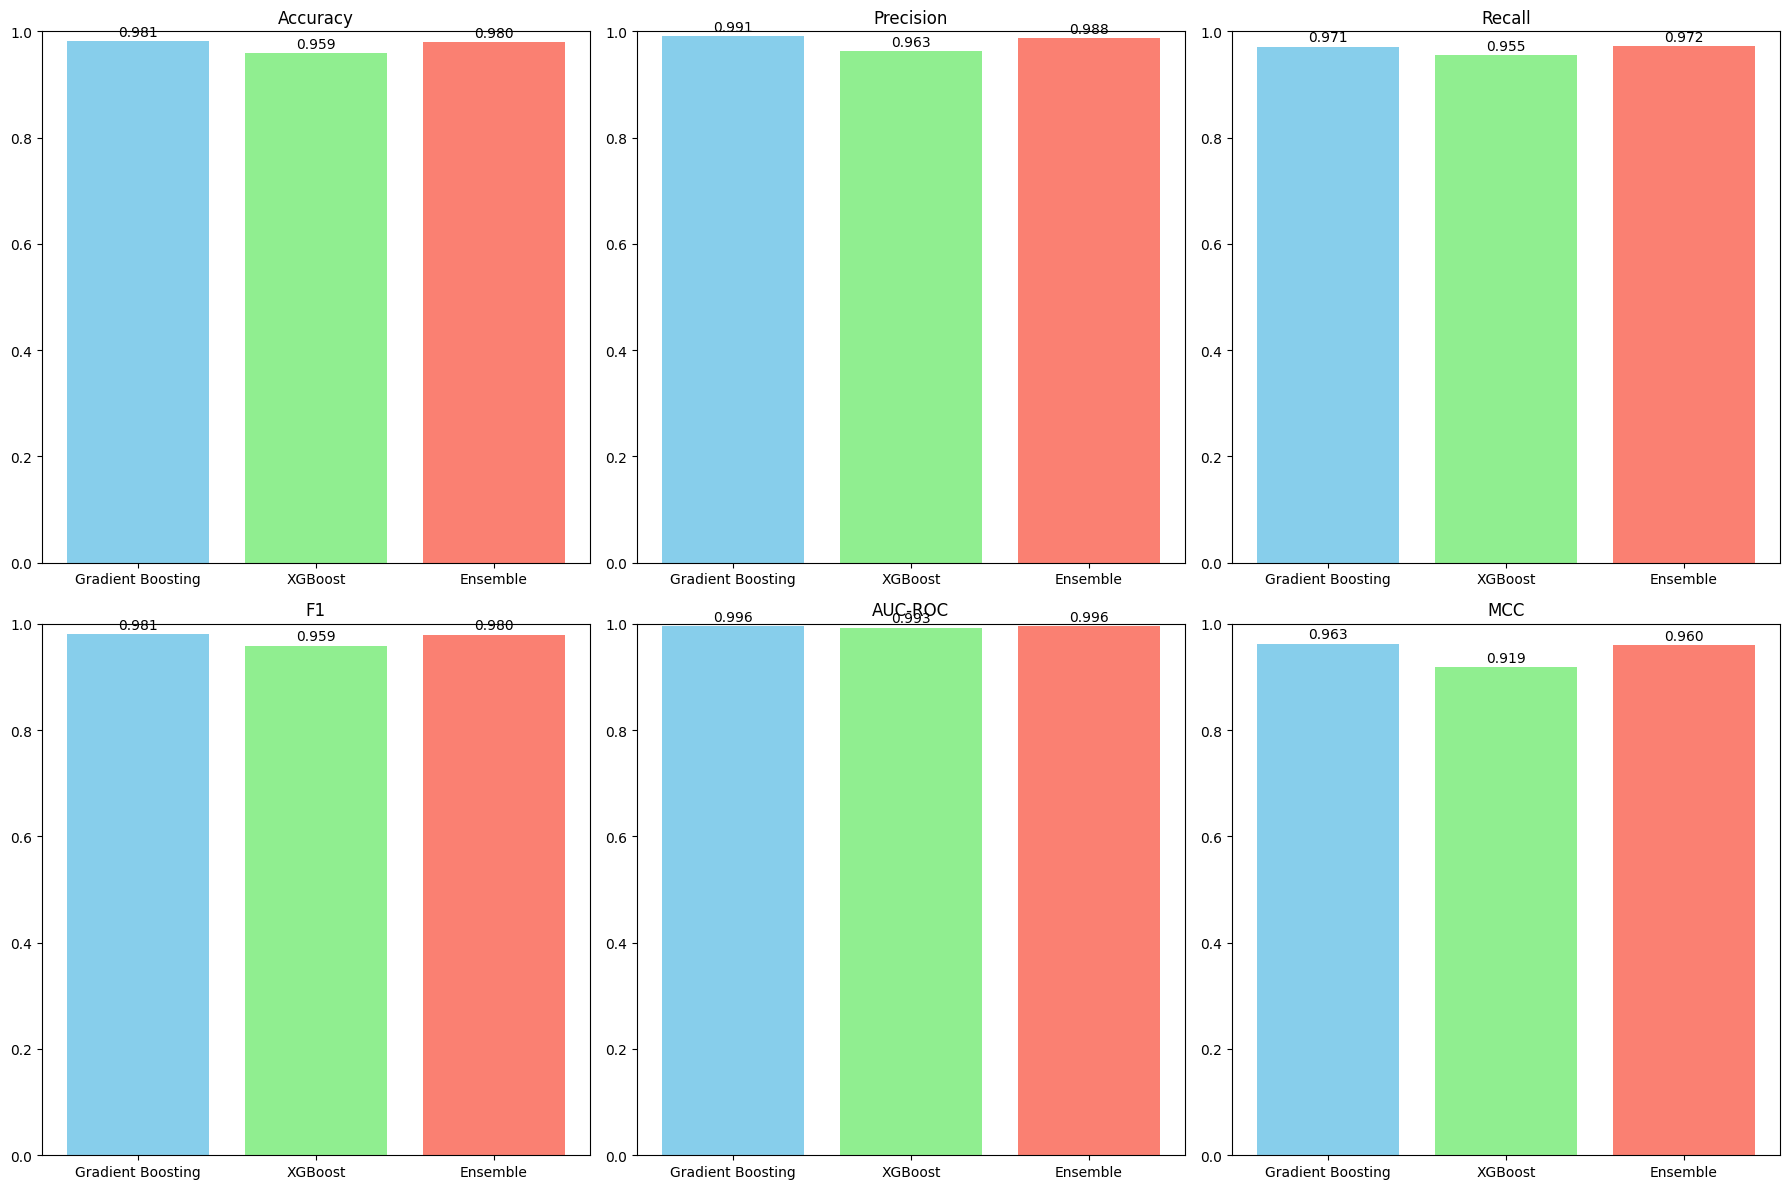

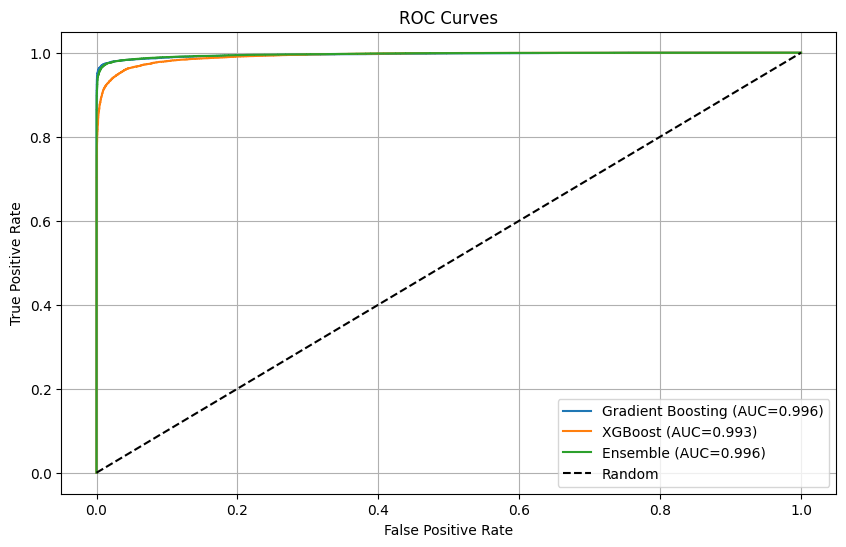

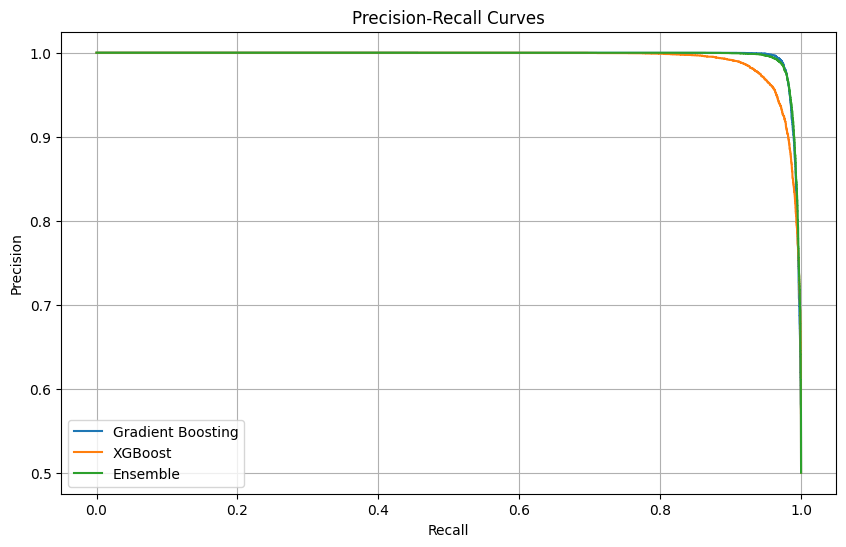

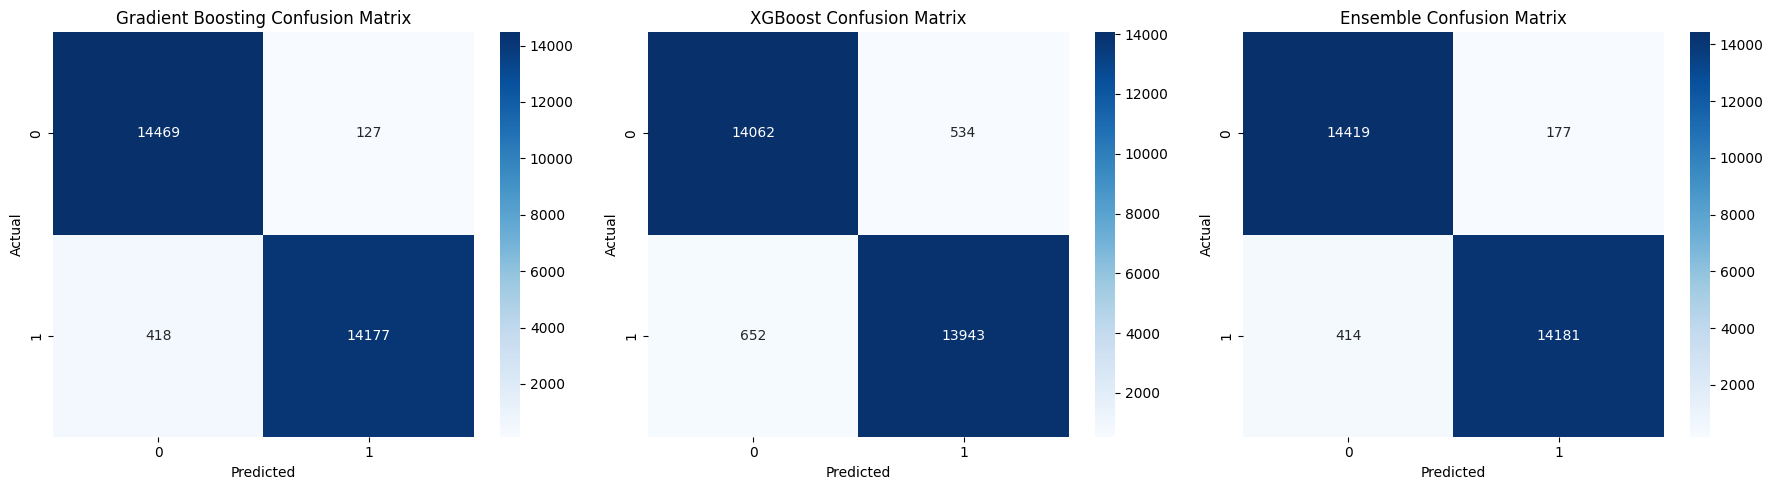


Top 10 Features (Gradient Boosting):
                  feature  importance
4       Annual.pct.driven    0.368805
3               Territory    0.163293
2          Years.noclaims    0.113777
1            Credit.score    0.086114
8   Left.turn.intensity09    0.080846
0             Insured.age    0.063824
6           Brake.06miles    0.048636
5           Accel.06miles    0.048536
9  Right.turn.intensity08    0.013113
7   Left.turn.intensity08    0.013056


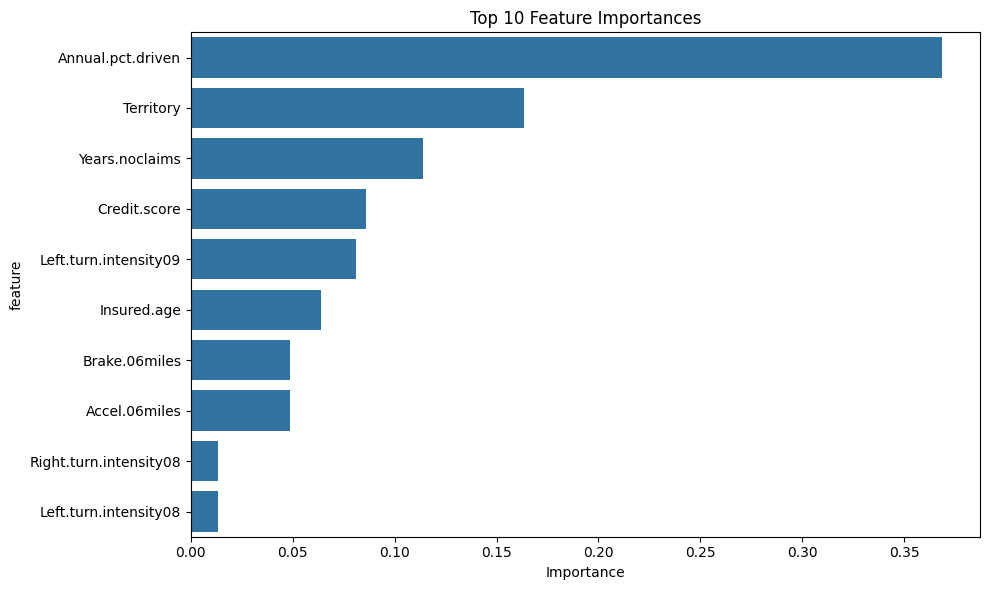


✅ Pipeline completed successfully.


In [ ]:
# =============================================================================
# STEP 1: IMPORT REQUIRED LIBRARIES
# =============================================================================
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier  # Faster than MLP
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, matthews_corrcoef,
                           confusion_matrix, roc_curve, precision_recall_curve)
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================================
# STEP 2: DATA LOADING AND INITIAL EXPLORATION
# =============================================================================
from google.colab import drive
drive.mount('/content/drive')

# Load dataset
file_path = '/content/drive/My Drive/Insurance/telematics_syn.csv'
df = pd.read_csv(file_path)

print("Dataset Info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

# Create target variable
df['ClaimYN'] = ((df['NB_Claim'] >= 1) & (df['AMT_Claim'] > 1000)).astype(int)
df = df.drop(['NB_Claim', 'AMT_Claim'], axis=1)

print("\nClaimYN Distribution:")
print(df['ClaimYN'].value_counts())

# =============================================================================
# STEP 3: DATA PREPROCESSING
# =============================================================================
# Drop missing values
df = df.dropna()

# Encode categorical variables
df = pd.get_dummies(df, drop_first=True)

# Separate features and target
X = df.drop('ClaimYN', axis=1)
y = df['ClaimYN']

# Fix negative Car.age
if 'Car.age' in X.columns:
    valid_age = X[X['Car.age'] >= 0]['Car.age']
    median_age = valid_age.median()
    X.loc[X['Car.age'] < 0, 'Car.age'] = median_age
    print(f"\nImputed negative Car.age with median: {median_age:.2f}")

# Log-transform intensity/brake/accel features
intensity_cols = [col for col in X.columns if 'intensity' in col.lower() or
                  'accel' in col.lower() or 'brake' in col.lower()]
for col in intensity_cols:
    X[col] = np.log1p(X[col])  # log(1 + x)

# =============================================================================
# STEP 4: FEATURE SCALING
# =============================================================================
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# =============================================================================
# STEP 5: HANDLE CLASS IMBALANCE WITH SMOTE
# =============================================================================
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

print("\nClass distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

# =============================================================================
# STEP 6: FEATURE SELECTION (Top 10 Features)
# =============================================================================
def feature_selection(X_train, y_train, top_k=10):
    selector = SelectKBest(score_func=mutual_info_classif, k=top_k)
    selector.fit(X_train, y_train)
    selected_features = X_train.columns[selector.get_support()].tolist()

    print("\nTop Features by Mutual Information:")
    scores = sorted(zip(X_train.columns, selector.scores_), key=lambda x: x[1], reverse=True)
    for feature, score in scores[:top_k]:
        print(f"{feature}: {score:.4f}")

    return selected_features

# Split data: 70% train, 15% val, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.15, random_state=42, stratify=y_resampled
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp  # ~15% val
)

# Feature selection on training data only
selected_features = feature_selection(X_train, y_train, top_k=10)

X_train_sel = X_train[selected_features]
X_val_sel = X_val[selected_features]
X_test_sel = X_test[selected_features]

# =============================================================================
# STEP 7: MODEL TRAINING WITH OPTIMIZED HYPERPARAMETER SEARCH
# =============================================================================

# --- Gradient Boosting ---
gb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2]
}

gb = GradientBoostingClassifier(random_state=42)
gb_search = RandomizedSearchCV(
    gb, gb_param_grid, n_iter=10, cv=3, scoring='roc_auc',
    random_state=42, n_jobs=-1
)
gb_search.fit(X_train_sel, y_train)
gb_best = gb_search.best_estimator_

# --- XGBoost (replaces slow MLP) ---
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_search = RandomizedSearchCV(
    xgb, xgb_param_grid, n_iter=10, cv=3, scoring='roc_auc',
    random_state=42, n_jobs=-1
)
xgb_search.fit(X_train_sel, y_train)
xgb_best = xgb_search.best_estimator_

# Print best parameters
print("\nBest Gradient Boosting Parameters:")
for k, v in gb_search.best_params_.items():
    print(f"  {k}: {v}")

print("\nBest XGBoost Parameters:")
for k, v in xgb_search.best_params_.items():
    print(f"  {k}: {v}")

# =============================================================================
# STEP 8: DUAL-MODEL ENSEMBLE WITH WEIGHTED AVERAGE
# =============================================================================
# Predict on validation set
gb_val_proba = gb_best.predict_proba(X_val_sel)[:, 1]
xgb_val_proba = xgb_best.predict_proba(X_val_sel)[:, 1]

# Compute validation accuracy for weighting
gb_val_pred = gb_best.predict(X_val_sel)
xgb_val_pred = xgb_best.predict(X_val_sel)
acc_gb = accuracy_score(y_val, gb_val_pred)
acc_xgb = accuracy_score(y_val, xgb_val_pred)

# Normalize weights
total_acc = acc_gb + acc_xgb
w_gb = acc_gb / total_acc
w_xgb = acc_xgb / total_acc

print(f"\nValidation Accuracies:")
print(f"GB: {acc_gb:.4f} → Weight: {w_gb:.3f}")
print(f"XGB: {acc_xgb:.4f} → Weight: {w_xgb:.3f}")

# Ensemble prediction (weighted average)
ensemble_val_proba = w_gb * gb_val_proba + w_xgb * xgb_val_proba

# =============================================================================
# STEP 9: OPTIMAL THRESHOLD SELECTION (Max F1)
# =============================================================================
precision, recall, thresholds = precision_recall_curve(y_val, ensemble_val_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # avoid div by zero
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"\nOptimal Threshold: {optimal_threshold:.4f}")
print(f"Max F1 Score: {f1_scores[optimal_idx]:.4f}")

ensemble_val_pred = (ensemble_val_proba >= optimal_threshold).astype(int)

# =============================================================================
# STEP 10: FINAL EVALUATION ON TEST SET
# =============================================================================
def evaluate_model(y_true, y_pred, y_pred_proba, name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_pred_proba)
    mcc = matthews_corrcoef(y_true, y_pred)

    print(f"\n{name} Performance:")
    print(f"  Accuracy : {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall   : {recall:.4f}")
    print(f"  F1       : {f1:.4f}")
    print(f"  AUC-ROC  : {auc:.4f}")
    print(f"  MCC      : {mcc:.4f}")

    return {
        'pred': y_pred,
        'proba': y_pred_proba,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc_roc': auc,
        'mcc': mcc
    }

# Test predictions
gb_test_proba = gb_best.predict_proba(X_test_sel)[:, 1]
xgb_test_proba = xgb_best.predict_proba(X_test_sel)[:, 1]
ensemble_test_proba = w_gb * gb_test_proba + w_xgb * xgb_test_proba
ensemble_test_pred = (ensemble_test_proba >= optimal_threshold).astype(int)

gb_test_pred = gb_best.predict(X_test_sel)
xgb_test_pred = xgb_best.predict(X_test_sel)

# Evaluate all
gb_results = evaluate_model(y_test, gb_test_pred, gb_test_proba, "Gradient Boosting")
xgb_results = evaluate_model(y_test, xgb_test_pred, xgb_test_proba, "XGBoost")
ensemble_results = evaluate_model(y_test, ensemble_test_pred, ensemble_test_proba, "Ensemble")

# =============================================================================
# STEP 11: VISUALIZATION
# =============================================================================
def visualize_performance(models_data, y_true):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc_roc', 'mcc']
    names = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC-ROC', 'MCC']

    for i, (metric, name) in enumerate(zip(metrics, names)):
        vals = [models_data[m][metric] for m in models_data]
        axes[i].bar(models_data.keys(), vals, color=['skyblue', 'lightgreen', 'salmon'])
        axes[i].set_title(name)
        axes[i].set_ylim(0, 1)
        for j, v in enumerate(vals):
            axes[i].text(j, v + 0.01, f'{v:.3f}', ha='center')

    plt.tight_layout()
    plt.show()

    # ROC Curve
    plt.figure(figsize=(10, 6))
    for name, data in models_data.items():
        fpr, tpr, _ = roc_curve(y_true, data['proba'])
        plt.plot(fpr, tpr, label=f"{name} (AUC={data['auc_roc']:.3f})")
    plt.plot([0,1],[0,1], 'k--', label='Random')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curves'); plt.legend(); plt.grid(True); plt.show()

    # Precision-Recall
    plt.figure(figsize=(10, 6))
    for name, data in models_data.items():
        p, r, _ = precision_recall_curve(y_true, data['proba'])
        plt.plot(r, p, label=name)
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.title('Precision-Recall Curves'); plt.legend(); plt.grid(True); plt.show()

    # Confusion Matrices
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, (name, data) in enumerate(models_data.items()):
        cm = confusion_matrix(y_true, data['pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'{name} Confusion Matrix')
        axes[i].set_xlabel('Predicted'); axes[i].set_ylabel('Actual')
    plt.tight_layout(); plt.show()

# Prepare data
models_data = {
    'Gradient Boosting': gb_results,
    'XGBoost': xgb_results,
    'Ensemble': ensemble_results
}

# Show plots
visualize_performance(models_data, y_test)

# =============================================================================
# STEP 12: FEATURE IMPORTANCE
# =============================================================================
importance_df = pd.DataFrame({
    'feature': selected_features,
    'importance': gb_best.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Features (Gradient Boosting):")
print(importance_df.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("\n✅ Pipeline completed successfully.")

In [2]:
!pip install lime SHAP

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=ba4e4964a5b887379361ca1644047659ac99ae45047773faa046e00655ce6023
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [3]:
# =============================================================================
# STEP 1: IMPORT REQUIRED LIBRARIES
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# For data splitting and preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, confusion_matrix,
    roc_curve, precision_recall_curve
)
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE

# For interpretability
import shap
import lime
import lime.lime_tabular

# For deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Google Colab mount (if needed)
from google.colab import drive
drive.mount('/content/drive')

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# =============================================================================
# STEP 2: LOAD AND PREPROCESS DATA
# =============================================================================

file_path = '/content/drive/My Drive/Insurance/telematics_syn.csv'
df = pd.read_csv(file_path)

# Derive target
df['ClaimYN'] = ((df['NB_Claim'] >= 1) & (df['AMT_Claim'] > 1000)).astype(int)
df = df.drop(['NB_Claim', 'AMT_Claim'], axis=1)

# Handle negative Car.age
if 'Car.age' in df.columns:
    median_age = df[df['Car.age'] >= 0]['Car.age'].median()
    df.loc[df['Car.age'] < 0, 'Car.age'] = median_age
    print(f"Imputed negative Car.age with median: {median_age:.1f}")

# One-hot encode categorical variables
df = pd.get_dummies(df, drop_first=True)

# Log-transform skewed intensity features
intensity_cols = [col for col in df.columns if 'intensity' in col.lower() or
                  'accel' in col.lower() or 'brake' in col.lower() or
                  'driving.percentage' in col.lower() or 'speed' in col.lower()]
for col in intensity_cols:
    if col != 'ClaimYN':
        df[col] = np.log1p(df[col])

# Separate features and target
X = df.drop('ClaimYN', axis=1)
y = df['ClaimYN']

# =============================================================================
# STEP 3: FEATURE SCALING AND SMOTE
# =============================================================================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

print(f"SMOTE: Balanced dataset size: {X_resampled.shape[0]} samples")

# =============================================================================
# STEP 4: TRAIN-VALIDATION-TEST SPLIT
# =============================================================================

X_temp, X_test, y_temp, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.15, random_state=42, stratify=y_resampled
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)

print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

# =============================================================================
# STEP 5: GRADIENT BOOSTING PATH
# =============================================================================

# Hyperparameter grid
gb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2]
}

gb = GradientBoostingClassifier(random_state=42)
gb_search = RandomizedSearchCV(
    gb, gb_param_grid, n_iter=10, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42
)
gb_search.fit(X_train, y_train)
gb_best = gb_search.best_estimator_

print("\n✅ Gradient Boosting Path trained.")

# =============================================================================
# STEP 6: NEURAL PROCESSING PATH WITH xLSTM-INSPIRED LAYER
# =============================================================================

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train.values)
X_val_tensor = torch.FloatTensor(X_val.values)
X_test_tensor = torch.FloatTensor(X_test.values)
y_train_tensor = torch.FloatTensor(y_train.values)
y_val_tensor = torch.FloatTensor(y_val.values)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)

# Define xLSTM-inspired sub-layer
class xLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(xLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Standard LSTM gates
        self.forget_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.input_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.output_gate = nn.Linear(input_size + hidden_size, hidden_size)
        self.candidate = nn.Linear(input_size + hidden_size, hidden_size)

        # "Forget-and-Reintegrate" mechanism
        self.noise_filter = nn.Linear(hidden_size, hidden_size)
        self.reintegrate = nn.Linear(hidden_size, hidden_size)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, hidden):
        h, c = hidden

        # Concatenate input and hidden state
        combined = torch.cat((x, h), dim=1)

        # Standard LSTM
        f = self.sigmoid(self.forget_gate(combined))
        i = self.sigmoid(self.input_gate(combined))
        o = self.sigmoid(self.output_gate(combined))
        g = self.tanh(self.candidate(combined))

        c_next = f * c + i * g
        h_next = o * self.tanh(c_next)

        # xLSTM-inspired: noise filtering and reintegrate
        filtered = self.tanh(self.noise_filter(h_next))
        reintegrated = self.sigmoid(self.reintegrate(filtered))
        h_enhanced = h_next * (1 - reintegrated) + filtered * reintegrated

        return h_enhanced, c_next

class xLSTMBlock(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(xLSTMBlock, self).__init__()
        self.cell = xLSTMCell(input_size, hidden_size)

    def forward(self, x, hidden):
        seq_len, batch_size, _ = x.size()
        outputs = []
        for t in range(seq_len):
            hidden = self.cell(x[t], hidden)
            outputs.append(hidden[0])
        return torch.stack(outputs), hidden

# Full Neural Processing Path
class NeuralProcessingPath(nn.Module):
    def __init__(self, input_size, hidden_sizes=[100, 50]):
        super(NeuralProcessingPath, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0])
        self.xlstm = xLSTMBlock(hidden_sizes[0], hidden_sizes[0])  # xLSTM after first layer
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # Reshape for sequence processing: treat features as time steps
        x = self.relu(self.bn1(self.fc1(x)))
        x = x.unsqueeze(0)  # Add sequence dim (1, batch, features)
        h0 = (torch.zeros(x.size(1), x.size(2)), torch.zeros(x.size(1), x.size(2)))
        x, _ = self.xlstm(x, h0)
        x = x.squeeze(0)  # Remove sequence dim
        x = self.dropout(self.relu(self.bn2(self.fc2(x))))
        return torch.sigmoid(self.fc3(x)).squeeze()

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuralProcessingPath(X_train.shape[1]).to(device)

# Training
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()
for epoch in range(50):  # Reduce epochs for speed
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

print("✅ Neural Processing Path (xLSTM-enhanced) trained.")

# =============================================================================
# STEP 7: ENSEMBLE PREDICTION
# =============================================================================

model.eval()
with torch.no_grad():
    nn_val_proba = model(X_val_tensor).numpy()
    nn_test_proba = model(X_test_tensor).numpy()

gb_val_proba = gb_best.predict_proba(X_val)[:, 1]
gb_test_proba = gb_best.predict_proba(X_test)[:, 1]

# Compute weights from validation accuracy
gb_val_pred = (gb_val_proba >= 0.5).astype(int)
nn_val_pred = (nn_val_proba >= 0.5).astype(int)

acc_gb = accuracy_score(y_val, gb_val_pred)
acc_nn = accuracy_score(y_val, nn_val_pred)

w_gb = acc_gb / (acc_gb + acc_nn)
w_nn = acc_nn / (acc_gb + acc_nn)

print(f"\nEnsemble Weights: GB={w_gb:.3f}, NN={w_nn:.3f}")

# Final ensemble probability
ensemble_val_proba = w_gb * gb_val_proba + w_nn * nn_val_proba
ensemble_test_proba = w_gb * gb_test_proba + w_nn * nn_test_proba

# Optimize threshold on validation set
precision, recall, thresholds = precision_recall_curve(y_val, ensemble_val_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.4f}")

ensemble_test_pred = (ensemble_test_proba >= optimal_threshold).astype(int)

# =============================================================================
# STEP 8: MODEL EVALUATION
# =============================================================================

def evaluate(y_true, y_pred, y_proba, name):
    print(f"\n--- {name} ---")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1:        {f1_score(y_true, y_pred):.4f}")
    print(f"AUC-ROC:   {roc_auc_score(y_true, y_proba):.4f}")
    print(f"MCC:       {matthews_corrcoef(y_true, y_pred):.4f}")

evaluate(y_test, gb_best.predict(X_test), gb_test_proba, "Gradient Boosting")
evaluate(y_test, (nn_test_proba >= 0.5).astype(int), nn_test_proba, "Neural Path")
evaluate(y_test, ensemble_test_pred, ensemble_test_proba, "Dual-Path Ensemble")

# =============================================================================
# STEP 9: INTERPRETABILITY (SHAP & LIME)
# =============================================================================

# SHAP for Gradient Boosting
explainer = shap.TreeExplainer(gb_best)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val, show=False)
plt.title("SHAP Feature Importance (Gradient Boosting)")
plt.show()

# LIME for a sample instance
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values, feature_names=X_train.columns, class_names=['No Claim', 'Claim'],
    discretize_continuous=True
)

i = np.random.randint(0, len(X_test))
exp = lime_explainer.explain_instance(
    X_test.iloc[i].values, lambda x: gb_best.predict_proba(x), num_features=10
)
exp.show_in_notebook(show_table=True)

# =============================================================================
# STEP 10: VISUALIZATION
# =============================================================================

# ROC Curves
plt.figure(figsize=(8, 6))
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_test_proba)
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_test_proba)
fpr_ens, tpr_ens, _ = roc_curve(y_test, ensemble_test_proba)

plt.plot(fpr_gb, tpr_gb, label=f"GB (AUC = {roc_auc_score(y_test, gb_test_proba):.3f})")
plt.plot(fpr_nn, tpr_nn, label=f"NN (AUC = {roc_auc_score(y_test, nn_test_proba):.3f})")
plt.plot(fpr_ens, tpr_ens, label=f"Ensemble (AUC = {roc_auc_score(y_test, ensemble_test_proba):.3f})")
plt.plot([0,1],[0,1], 'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curves'); plt.legend(); plt.grid(True); plt.show()

print("\n✅ Framework execution completed.")

Mounted at /content/drive
Imputed negative Car.age with median: 5.0
SMOTE: Balanced dataset size: 194604 samples
Train: 136300, Val: 29113, Test: 29191


KeyboardInterrupt: 

In [ ]:
# =============================================================================
# STEP 1: IMPORT REQUIRED LIBRARIES (Minimal & Efficient)
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, matthews_corrcoef, precision_recall_curve, roc_curve
)
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE

# SHAP & LIME (lightweight use)
import shap

# PyTorch (optimized)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Google Colab mount
from google.colab import drive
drive.mount('/content/drive')

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# =============================================================================
# STEP 2: LOAD AND PREPROCESS DATA (Efficient)
# =============================================================================

file_path = '/content/drive/My Drive/Insurance/telematics_syn.csv'
df = pd.read_csv(file_path)

# Derive target
df['ClaimYN'] = ((df['NB_Claim'] >= 1) & (df['AMT_Claim'] > 1000)).astype(int)
df.drop(['NB_Claim', 'AMT_Claim'], axis=1, inplace=True)

# Fix negative Car.age
if 'Car.age' in df.columns:
    median_age = df.loc[df['Car.age'] >= 0, 'Car.age'].median()
    df.loc[df['Car.age'] < 0, 'Car.age'] = median_age

# One-hot encode
df = pd.get_dummies(df, drop_first=True)

# Log-transform intensity-related features
intensity_keywords = ['intensity', 'accel', 'brake', 'percentage', 'speed']
intensity_cols = [c for c in df.columns if any(k in c.lower() for k in intensity_keywords) and c != 'ClaimYN']
df[intensity_cols] = np.log1p(df[intensity_cols])

# Features and target
X = df.drop('ClaimYN', axis=1)
y = df['ClaimYN']

# =============================================================================
# STEP 3: SCALE & BALANCE (Optimized SMOTE)
# =============================================================================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# SMOTE only on training data (avoid data leakage)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.15, random_state=42, stratify=y
)

# Apply SMOTE to training only
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_temp, y_temp)

# Now split train into train + val
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.176, random_state=42, stratify=y_train
)

# Convert to DataFrame for easier handling later
X_train = pd.DataFrame(X_train, columns=X.columns)
X_val = pd.DataFrame(X_val, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

# =============================================================================
# STEP 4: GRADIENT BOOSTING (Faster Randomized Search)
# =============================================================================

# Reduced hyperparameter grid and iterations
gb_param_grid = {
    'n_estimators': [100, 150],
    'learning_rate': [0.1, 0.15],
    'max_depth': [4, 5],
    'min_samples_split': [10],
    'min_samples_leaf': [2],
}

gb = GradientBoostingClassifier(random_state=42)
gb_search = RandomizedSearchCV(
    gb, gb_param_grid, n_iter=6, cv=3, scoring='roc_auc', n_jobs=-1, random_state=42, verbose=0
)
gb_search.fit(X_train, y_train)
gb_best = gb_search.best_estimator_

print("✅ Gradient Boosting trained.")

# =============================================================================
# STEP 5: NEURAL NETWORK (SIMPLIFIED xLSTM-INSPIRED MODEL)
# =============================================================================

# Simplified xLSTM-inspired layer using efficient linear transforms
class xLSTMBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.linear = nn.Linear(input_dim, 4 * hidden_dim)  # f, i, o, g
        self.filter = nn.Linear(hidden_dim, hidden_dim)
        self.reintegrate = nn.Linear(hidden_dim, hidden_dim)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, hidden):
        h, c = hidden
        combined = torch.cat((x, h), dim=1)
        gates = self.linear(combined)
        f, i, o, g = gates.chunk(4, dim=1)

        f = self.sigmoid(f)
        i = self.sigmoid(i)
        o = self.sigmoid(o)
        g = self.tanh(g)

        c = f * c + i * g
        h = o * self.tanh(c)

        # xLSTM-style enhancement
        filtered = self.tanh(self.filter(h))
        r = self.sigmoid(self.reintegrate(filtered))
        h = h * (1 - r) + filtered * r

        return h, c

# Efficient FF + xLSTM model
class NeuralPath(nn.Module):
    def __init__(self, input_size, hidden_dims=[128, 64]):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_dims[0])
        self.bn1 = nn.BatchNorm1d(hidden_dims[0])
        self.xlstm = xLSTMBlock(hidden_dims[0], hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.bn2 = nn.BatchNorm1d(hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        batch_size = x.size(0)
        h0 = (torch.zeros(batch_size, self.xlstm.hidden_dim).to(x.device),
              torch.zeros(batch_size, self.xlstm.hidden_dim).to(x.device))
        x, _ = self.xlstm(x, h0)
        x = self.dropout(self.relu(self.bn2(self.fc2(x))))
        return torch.sigmoid(self.fc3(x)).squeeze()

# Convert to tensors
X_train_tensor = torch.FloatTensor(X_train.values).to(device)
X_val_tensor = torch.FloatTensor(X_val.values).to(device)
X_test_tensor = torch.FloatTensor(X_test.values).to(device)
y_train_tensor = torch.FloatTensor(y_train.values).to(device)
y_val_tensor = torch.FloatTensor(y_val.values).to(device)

# DataLoader
train_loader = DataLoader(
    TensorDataset(X_train_tensor, y_train_tensor),
    batch_size=256, shuffle=True, num_workers=2, pin_memory=True
)

# Model
model = NeuralPath(X_train.shape[1]).to(device)

# Optimizer and loss
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

# Training loop
model.train()
best_val_loss = float('inf')
patience, wait = 0, 0

print("Training Neural Path...")

for epoch in range(50):
    epoch_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    scheduler.step(epoch_loss)

    # Early stopping
    if epoch_loss < best_val_loss:
        best_val_loss = epoch_loss
        wait = 0
    else:
        wait += 1
        if wait >= 10:
            print(f"Early stopping at epoch {epoch}")
            break

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}")

print("✅ Neural Path trained.")

# =============================================================================
# STEP 6: ENSEMBLE WITH OPTIMAL THRESHOLD
# =============================================================================

model.eval()
with torch.no_grad():
    nn_val_proba = model(X_val_tensor).cpu().numpy()
    nn_test_proba = model(X_test_tensor).cpu().numpy()

gb_val_proba = gb_best.predict_proba(X_val)[:, 1]
gb_test_proba = gb_best.predict_proba(X_test)[:, 1]

# Weighting by validation AUC (more stable than accuracy)
auc_gb = roc_auc_score(y_val, gb_val_proba)
auc_nn = roc_auc_score(y_val, nn_val_proba)
w_gb = auc_gb / (auc_gb + auc_nn)
w_nn = auc_nn / (auc_gb + auc_nn)

print(f"Ensemble Weights: GB={w_gb:.3f}, NN={w_nn:.3f}")

# Ensemble probabilities
ensemble_val_proba = w_gb * gb_val_proba + w_nn * nn_val_proba
ensemble_test_proba = w_gb * gb_test_proba + w_nn * nn_test_proba

# Optimize threshold using F1 on validation
precision, recall, thresholds = precision_recall_curve(y_val, ensemble_val_proba)
f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.4f}")

ensemble_test_pred = (ensemble_test_proba >= optimal_threshold).astype(int)

# =============================================================================
# STEP 7: EVALUATION
# =============================================================================

def evaluate(y_true, y_pred, y_proba, name):
    print(f"\n--- {name} ---")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1:        {f1_score(y_true, y_pred):.4f}")
    print(f"AUC-ROC:   {roc_auc_score(y_true, y_proba):.4f}")
    print(f"MCC:       {matthews_corrcoef(y_true, y_pred):.4f}")

evaluate(y_test, gb_best.predict(X_test), gb_test_proba, "Gradient Boosting")
evaluate(y_test, (nn_test_proba >= 0.5).astype(int), nn_test_proba, "Neural Path")
evaluate(y_test, ensemble_test_pred, ensemble_test_proba, "Dual-Path Ensemble")

# =============================================================================
# STEP 8: INTERPRETABILITY (Efficient SHAP)
# =============================================================================

# Fast approximate SHAP for tree model
explainer = shap.TreeExplainer(gb_best, feature_names=X_train.columns, approximate=True)
shap_values = explainer.shap_values(X_val)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_val, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Gradient Boosting)")
plt.tight_layout()
plt.show()

# =============================================================================
# STEP 9: ROC CURVE VISUALIZATION
# =============================================================================

plt.figure(figsize=(8, 6))
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_test_proba)
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_test_proba)
fpr_ens, tpr_ens, _ = roc_curve(y_test, ensemble_test_proba)

plt.plot(fpr_gb, tpr_gb, label=f"GB (AUC = {roc_auc_score(y_test, gb_test_proba):.3f})")
plt.plot(fpr_nn, tpr_nn, label=f"NN (AUC = {roc_auc_score(y_test, nn_test_proba):.3f})")
plt.plot(fpr_ens, tpr_ens, label=f"Ensemble (AUC = {roc_auc_score(y_test, ensemble_test_proba):.3f})")
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ Optimization complete. Framework executed efficiently.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Train: 136301, Val: 29113, Test: 15000
